In [43]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
import torch
from torch_geometric.data import Data
import networkx as nx
from rdkit.Chem import rdMolTransforms
from collections import Counter


In [2]:
file_path = "NR_AR.txt"

initial_data = pd.read_csv(file_path,'\t',header=None)

initial_data.head()

/var/folders/93/kkjjknp12k582b4gm6fvlsxc0000gn/T/ipykernel_13661/1463097452.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  initial_data = pd.read_csv(file_path,'\t',header=None)


,0,1,2
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0


In [3]:
initial_data.columns = ["SMILE","ID","Function"]
initial_data.head()

,SMILE,ID,Function
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0


In [4]:
# Calculating the number of . in SMILE ( components )
initial_data['DotCount'] = initial_data['SMILE'].apply(lambda x : x.count('.'))

In [5]:
initial_data.head()

,SMILE,ID,Function,DotCount
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0,1
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0,1
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0,2
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0,2
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0,1


In [6]:
filtered_data = initial_data[initial_data['DotCount'] == 0]

In [7]:
# Drop duplicates based on 'SMILE' and 'Function'
unique_filtered_data = filtered_data.drop_duplicates(subset=['SMILE', 'Function'])

In [8]:
print(unique_filtered_data.head())

                                                SMILE               ID  \
5   COC1=CC=C(CCN2CCC(CC2)NC3=NC4=CC=CC=C4N3CC5=CC...  NCGC00257649-01   
7   CC\C(=C(/C1=CC=C(O)C=C1)C2=CC=C(OCCN(C)C)C=C2)...  NCGC00258497-01   
8        CCOC(=O)C(O)(C1=CC=C(Cl)C=C1)C2=CC=C(Cl)C=C2  NCGC00259302-01   
9   [H][C@]12C[C@@]3([H])[C@]4([H])CC[C@@]5([H])C[...  NCGC00095843-01   
14  OC1(CCN(CCCC(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3)CC1...  NCGC00165865-01   

    Function  DotCount  
5          0         0  
7          0         0  
8          0         0  
9          0         0  
14         0         0  


In [9]:
function_counts = unique_filtered_data['Function'].value_counts()

print(function_counts)

0    5726
1     268
Name: Function, dtype: int64


In [69]:
def is_valid_molecule(mol):
    """Check if a molecule is valid for RDKit operations."""
    try:
        
        Chem.SanitizeMol(mol)
        return True
    
    except Exception as e:
        print(f"Sanitization failed: {e}")
        return False

In [70]:
# UFF is universal force field , generally good for most compunds
# MMFF a better force field for small and large organic and inorganic molecules

def generate_conformer(mol, max_attempts=1000):
    """Generate a 3D conformer with UFF optimization, fallback to MMFF."""
    params = AllChem.ETKDG()
    params.maxAttempts = max_attempts
    try:
        
        success = AllChem.EmbedMolecule(mol, params)
        if success == -1:
            print("Failed to generate initial conformer.")
            return None
        
        try:
            AllChem.UFFOptimizeMolecule(mol)
        except ValueError:
            success = AllChem.MMFFOptimizeMolecule(mol)
            if not success:
                
                print("MMFF optimization failed.")
                return None
            
    except Exception as e:
        print(f"Conformer generation error: {e}")
        return None
    return mol

In [71]:
def mol_to_nx_extended(mol):
    """Convert RDKit molecule to NetworkX graph with atom/bond features."""
    
    G = nx.Graph()
    
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   symbol=atom.GetSymbol(),# symbol
                   formal_charge=atom.GetFormalCharge(), # formal charge
                   implicit_valence=atom.GetImplicitValence(), # valency
                   ring_atom=atom.IsInRing(), # whether part of a ring or not
                   degree=atom.GetDegree(), # number of connected atoms
                   hybridization=str(atom.GetHybridization()), # hybridization
                   atomic_weight=atom.GetMass()) # mass
    
    for bond in mol.GetBonds():
        angle = calc_bond_angle(mol, bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        G.add_edge(bond.GetBeginAtomIdx(), # first atom
                   bond.GetEndAtomIdx(), # second atom
                   bond_type=str(bond.GetBondType()), # type of bond
                   bond_angle=angle, # bond angle , based on conformers (single bonded)
                   rotatable=is_rotatable_bond(bond)) # if bond can rotate or not
    return G

In [73]:
def calc_bond_angle(mol, atom1_idx, atom2_idx):
    """Calculate the bond angle for a bond between two atoms."""
    
    neighbors1 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom1_idx).GetNeighbors() if nbr.GetIdx() != atom2_idx]
    
    neighbors2 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom2_idx).GetNeighbors() if nbr.GetIdx() != atom1_idx]
    
    if neighbors1 and neighbors2:
        
        return rdMolTransforms.GetAngleDeg(mol.GetConformer(), neighbors1[0], atom1_idx, atom2_idx)
    
    return None

In [74]:
def is_rotatable_bond(bond):
    """Check if a bond is rotatable."""
    
    if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
        return False
    
    return (not bond.GetBeginAtom().IsInRing() and bond.GetBeginAtom().GetDegree() > 1 and
            not bond.GetEndAtom().IsInRing() and bond.GetEndAtom().GetDegree() > 1)


In [75]:
def bond_type_to_numeric(bond_type):
    """Convert bond type to numeric value."""
    
    bond_mapping = {'SINGLE': 0, 'DOUBLE': 1, 'TRIPLE': 2, 'AROMATIC': 3}
    
    return bond_mapping.get(bond_type, -1)

In [76]:
def nx_to_pyg_data_extended(G):
    """Convert NetworkX graph to PyTorch Geometric Data."""
    
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    
    node_features = [
        [node[1]['formal_charge'], node[1]['implicit_valence'],
         int(node[1]['ring_atom']), node[1]['degree'], node[1]['atomic_weight']]
        for node in G.nodes(data=True)
    ]
    
    x = torch.tensor(node_features, dtype=torch.float)
    edge_features = [
        [bond_type_to_numeric(edge[2]['bond_type']),
         edge[2]['bond_angle'] if edge[2]['bond_angle'] is not None else 0.0,
         1 if edge[2]['rotatable'] else 0]
        for edge in G.edges(data=True)
    ]
    
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [77]:
def process_smiles_extended(smiles_list, id_list, function_list):
    """Process SMILES into PyTorch Geometric Data, log failures with additional metadata."""
    
    data_list = []
    failed_entries = []  # To log failed entries with SMILE, ID, and Function

    for i, (smiles, mol_id, function) in enumerate(zip(smiles_list, id_list, function_list)):
        print(f"Processing {i+1}/{len(smiles_list)}: {smiles} (ID: {mol_id}, Function: {function})")
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Cannot generate mol from SMILES: {smiles}")
            failed_entries.append({"SMILES": smiles, "ID": mol_id, "Function": function, "Error": "Invalid SMILES"})
            continue
        
        # Add hydrogens early to balance charges and satisfy valency
        mol = Chem.AddHs(mol)

        # Validate molecule with hydrogens added
        if not is_valid_molecule(mol):
            print(f"Skipping invalid molecule: {smiles}")
            failed_entries.append({"SMILES": smiles, "ID": mol_id, "Function": function, "Error": "Invalid Molecule"})
            continue
        
        # Generate 3D conformer
        mol = generate_conformer(mol)
        if mol is None:
            print(f"Conformer generation failed for SMILES: {smiles}")
            failed_entries.append({"SMILES": smiles, "ID": mol_id, "Function": function, "Error": "Conformer Generation Failed"})
            continue
        
        # Convert to NetworkX and then to PyTorch Geometric Data
        try:
            G = mol_to_nx_extended(mol)
            pyg_data = nx_to_pyg_data_extended(G)
            data_list.append(pyg_data)
        except Exception as e:
            print(f"Graph conversion failed for SMILES: {smiles} - Error: {e}")
            failed_entries.append({"SMILES": smiles, "ID": mol_id, "Function": function, "Error": f"Graph Conversion Failed: {e}"})
            continue
    
    return data_list, failed_entries

In [38]:
smiles_list = unique_filtered_data['SMILE'].tolist()
id_list = unique_filtered_data['ID'].tolist()
function_list = unique_filtered_data['Function'].tolist()

processed_data, failed_entries = process_smiles_extended(smiles_list, id_list, function_list)

# Save results and failures
#node_data_list = [d.x.numpy() for d in processed_data]
#edge_data_list = [d.edge_attr.numpy() for d in processed_data]

#node_df = pd.DataFrame([n.flatten() for n in node_data_list])
#edge_df = pd.DataFrame([e.flatten() for e in edge_data_list])
failed_smiles_df = pd.DataFrame(failed_entries)

#node_df.to_csv("node_features.csv", index=False)
#edge_df.to_csv("edge_features.csv", index=False)
failed_smiles_df.to_csv("failed_smiles.csv", index=False)

Processing 1/5994: COC1=CC=C(CCN2CCC(CC2)NC3=NC4=CC=CC=C4N3CC5=CC=C(F)C=C5)C=C1 (ID: NCGC00257649-01, Function: 0)
Processing 2/5994: CC\C(=C(/C1=CC=C(O)C=C1)C2=CC=C(OCCN(C)C)C=C2)C3=CC=CC=C3 (ID: NCGC00258497-01, Function: 0)
Processing 3/5994: CCOC(=O)C(O)(C1=CC=C(Cl)C=C1)C2=CC=C(Cl)C=C2 (ID: NCGC00259302-01, Function: 0)
Processing 4/5994: [H][C@]12C[C@@]3([H])[C@]4([H])CC[C@@]5([H])C[C@H](CC[C@]5(C)[C@@]4([H])CC[C@]3(C)[C@@]1([H])[C@H](C)[C@]6(CC[C@H](C)CN6)O2)O[C@@H]7O[C@H](CO)[C@H](O[C@@H]8O[C@H](CO)[C@@H](O)[C@H](O[C@@H]9OC[C@@H](O)[C@H](O)[C@H]9O)[C@H]8O[C@@H]%10O[C@H](CO)[C@@H](O)[C@H](O)[C@H]%10O)[C@H](O)[C@H]7O (ID: NCGC00095843-01, Function: 0)
Processing 5/5994: OC1(CCN(CCCC(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3)CC1)C4=CC=C(Cl)C(=C4)C(F)(F)F (ID: NCGC00165865-01, Function: 0)
Processing 6/5994: CC(C)OC(=O)C1=C(C)NC(N)=C(C1C2=CC(=CC=C2)[N+]([O-])=O)C(=O)OC3CN(C3)C(C4=CC=CC=C4)C5=CC=CC=C5 (ID: NCGC00167436-01, Function: 0)
Processing 7/5994: CC(C)(C1=CC=CC=C1)C2=CC(=C(O)C=C2)C(C)(C)

[14:20:17] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:20:17] UFFTYPER: Unrecognized charge state for atom: 1
[14:20:17] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:20:17] UFFTYPER: Unrecognized charge state for atom: 1


Processing 14/5994: CC1=CC(=C(O)C=C1)C(C)(C)C (ID: NCGC00259487-01, Function: 0)
Processing 15/5994: C[N+]1=CC2=C(C=CC3=C2OCO3)C4=C1C5=C(C=C4)C=C6OCOC6=C5 (ID: NCGC00015959-03, Function: 0)
Processing 16/5994: OC1=C([Hg]Cl)C=CC=C1 (ID: NCGC00181158-01, Function: 0)
Processing 17/5994: CCCCCCCCCCCC(=O)NCCCN(C)C (ID: NCGC00256156-01, Function: 0)
Processing 18/5994: CCCN(CCC)C1=C(C(N)=C(C=C1[N+]([O-])=O)C(F)(F)F)[N+]([O-])=O (ID: NCGC00254602-01, Function: 0)
Processing 19/5994: CCCCCCCCNC(C)C(O)C1=CC=C(SC(C)C)C=C1 (ID: NCGC00018301-02, Function: 0)
Processing 20/5994: ClC(Cl)(Cl)SN1C(=O)C2CC=CCC2C1=O (ID: NCGC00254676-01, Function: 0)
Processing 21/5994: COC1=CC=C2[C@H]([C@H](C3=CC=CC=C3)C(C)(C)OC2=C1)C4=CC=C(OCCN5CCCC5)C=C4 (ID: NCGC00181100-01, Function: 0)
Processing 22/5994: O=C1C=CC(=O)N1C2=CC=CC=C2 (ID: NCGC00254580-01, Function: 0)
Processing 23/5994: OC1=CC=CC(=C1)C2=C3NC(C=C3)=C(C4=NC(C=C4)=C(C5=CC=C(N5)C(=C6CCC2=N6)C7=CC(O)=CC=C7)C8=CC(O)=CC=C8)C9=CC(O)=CC=C9 (ID: NCGC00183015

[14:20:24] UFFTYPER: Unrecognized atom type: Au6+3 (7)
[14:20:24] UFFTYPER: Unrecognized atom type: Au6+3 (7)


Processing 43/5994: [O-][N+](=O)C1=CC(=C(Cl)C(=C1Cl)[N+]([O-])=O)C(F)(F)F (ID: NCGC00256855-01, Function: 0)
Processing 44/5994: C\C=C\C(=O)OC1=C(C=C(C=C1CCCCCC(C)C)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00255514-01, Function: 0)
Processing 45/5994: CCCCCCCCCCCCN(CCO)CCO (ID: NCGC00255856-01, Function: 0)
Processing 46/5994: CCC(C)NC1=CC=C(NC(C)CC)C=C1 (ID: NCGC00257925-01, Function: 0)
Processing 47/5994: OC1=C(C=C(Cl)C=C1)C(=O)NC2=CC=C(C=C2Cl)[N+]([O-])=O (ID: NCGC00254654-01, Function: 0)
Processing 48/5994: [H][C@@]12OC\C3=C/C=C/[C@H](C)C\C(C)=C\C[C@]4([H])C[C@@H](C[C@]5(CC[C@H](C)[C@@H](CC)O5)O4)OC(=O)[C@]([H])(C=C(C)[C@H]1O)[C@@]23O (ID: NCGC00254847-01, Function: 0)
Processing 49/5994: [H][C@@]12N3CC[C@@]14C5=C(C=C(OC)C(=C5)[C@]6(C[C@@H]7C[N@@](C[C@](O)(CC)C7)CCC8=C6NC9=C8C=CC=C9)C(=O)OC)N(C=O)[C@@]4([H])[C@](O)([C@H](OC(C)=O)[C@]2(CC)C=CC3)C(=O)OC (ID: NCGC00163700-01, Function: 0)
Processing 50/5994: CC1=CC=C(C=C1)C(=O)C2=CC(O)=C(O)C(=C2)[N+]([O-])=O (ID: NCGC00255188-01, Function

Processing 114/5994: [H][C@]1(C[C@@H](C)C[C@H](C)C1=O)[C@H](O)CC2CC(=O)NC(=O)C2 (ID: NCGC00024910-01, Function: 0)
Processing 115/5994: OC1=CC2=C(C=C1)C3(OC(=O)C4=C3C=CC=C4)C5=C(O2)C=C(O)C=C5 (ID: NCGC00161643-03, Function: 0)
Processing 116/5994: ClC1=CC=CC(NN=C(C#N)C#N)=C1 (ID: NCGC00255699-01, Function: 0)
Processing 117/5994: CC(C)N(C(=O)CCl)C1=CC=CC=C1 (ID: NCGC00259283-01, Function: 0)
Processing 118/5994: CCCCCCCC[Sn](Cl)(Cl)CCCCCCCC (ID: NCGC00258036-01, Function: 0)
Processing 119/5994: [H][C@]12C[C@H](OC(C)=O)C(C)(C)[C@](O)(C[C@]3([H])C\C(C[C@@]([H])(O3)\C=C\C(C)(C)[C@]4(O)O[C@@]([H])(C\C(=C/C(=O)OC)[C@@H]4OC(=O)\C=C\C=C\CCC)C[C@@]([H])(OC(=O)C[C@H](O)C1)[C@@H](C)O)=C\C(=O)OC)O2 (ID: NCGC00181150-01, Function: 0)
Processing 120/5994: CCCC[Sn](Cl)(Cl)CCCC (ID: NCGC00259224-01, Function: 0)
Processing 121/5994: ClC(Cl)C(C1=CC=C(Cl)C=C1)C2=CC=C(Cl)C=C2 (ID: NCGC00258848-01, Function: 0)
Processing 122/5994: COC(=O)N(C(=O)N1CO[C@]2(CC3=C(C=CC(Cl)=C3)C2=N1)C(=O)OC)C4=CC=C(OC(F)(F)

[14:33:11] UFFTYPER: Unrecognized atom type: Zn1+2 (8)
[14:33:11] UFFTYPER: Unrecognized atom type: Zn1+2 (8)


Processing 169/5994: [H][C@]12[C@H](C[C@@H](C)C=C1C=C[C@H](C)[C@@H]2CC[C@@H]3C[C@@H](O)CC(=O)O3)OC(=O)[C@@H](C)CC (ID: NCGC00259026-01, Function: 0)
Processing 170/5994: C1=CC2=CC3=C(C=C2C=C1)C4=C5C3=CC=CC5=CC=C4 (ID: NCGC00258275-01, Function: 0)
Processing 171/5994: CO[C@H]1[C@@H](CC(=O)O[C@H](C)CC2OC2\C=C\C(=O)[C@H](C)C[C@H](CC=O)[C@@H]1O[C@@H]3O[C@H](C)[C@@H](O[C@H]4C[C@@](C)(O)[C@@H](OC(=O)CC(C)C)[C@H](C)O4)[C@@H]([C@H]3O)N(C)C)OC(C)=O (ID: NCGC00181116-01, Function: 0)
Processing 172/5994: [H][C@@]12CC[C@H](OC(=O)CC)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00255481-01, Function: 1)
Processing 173/5994: CCCC[Sn](CCCC)(CCCC)OC(=O)C(C)=C (ID: NCGC00254380-01, Function: 0)
Processing 174/5994: ClC1(Cl)CS(=O)(=O)CC1(Cl)Cl (ID: NCGC00255452-01, Function: 0)
Processing 175/5994: ClC1=C(C=CC=C1)C(N2C=CN=C2)(C3=CC=CC=C3)C4=CC=CC=C4 (ID: NCGC00254538-01, Function: 0)
Processing 176/5994: ClC1=CC(Cl)=C(C=C1)[C@@H]2CS\C(S2)=C(\C#N)N3C=CN=C3 (ID: NCGC00182704-01, Functio

[14:41:44] UFFTYPER: Unrecognized hybridization for atom: 1
[14:41:44] UFFTYPER: Unrecognized atom type: Au+3 (1)
[14:41:44] UFFTYPER: Unrecognized hybridization for atom: 1
[14:41:44] UFFTYPER: Unrecognized atom type: Au+3 (1)


Processing 211/5994: OC1=C(Br)C=C(\C=N\OC2=C(C=C(C=C2)[N+]([O-])=O)[N+]([O-])=O)C=C1Br (ID: NCGC00254848-01, Function: 0)
Processing 212/5994: [H][C@@]12CC[C@](C)(O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CC[C@@]4([H])CC5=NON=C5C[C@]34C (ID: NCGC00181290-01, Function: 1)
Processing 213/5994: COC1=CC2=C(C(OC)=C1OC)C3=CC=C(OC)C(=O)C=C3[C@H](CC2)NC(C)=O (ID: NCGC00259096-01, Function: 0)
Processing 214/5994: ClC1=CC=C(C=C1)C(C2=CC=C(Cl)C=C2)C(Cl)(Cl)Cl (ID: NCGC00254176-01, Function: 0)
Processing 215/5994: OC1=C(I)C=C(C=C1I)C#N (ID: NCGC00255309-01, Function: 0)
Processing 216/5994: ClCC(=O)C1=CC=CC=C1 (ID: NCGC00254035-01, Function: 0)
Processing 217/5994: CC(C)(C)C(=O)OCOC(=O)C1N2C(CC2=O)S(=O)(=O)C1(C)C (ID: NCGC00249610-01, Function: 0)
Processing 218/5994: OC(C1=CC=C(Cl)C=C1)(C2=CC=C(Cl)C=C2)C(Cl)(Cl)Cl (ID: NCGC00254890-01, Function: 0)
Processing 219/5994: OC1=C(Br)C=C(C=C1Br)C#N (ID: NCGC00255099-01, Function: 0)
Processing 220/5994: ClC1=CC2=CC3=CC=CC=C3C=C2C=C1 (ID: NCGC00260506-01, Fu

Processing 288/5994: CC(C)CC(C)N(C1=CC=CC=C1)C2=CC=C(N)C=C2 (ID: NCGC00256176-01, Function: 0)
Processing 289/5994: COCCOC(=O)C1=C(C)NC(C)=C(C1C2=CC(=CC=C2)[N+]([O-])=O)C(=O)OC\C=C\C3=CC=CC=C3 (ID: NCGC00162150-01, Function: 0)
Processing 290/5994: CCC1=NC(N)=NC(N)=C1C2=CC=C(Cl)C=C2 (ID: NCGC00016256-08, Function: 1)
Processing 291/5994: CCN(CC)CCOC1=CC=C(C=C1)C(=C(Cl)C2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00179503-02, Function: 0)
Processing 292/5994: COC1=CC=C(\C=C\C(=O)NC2=C(C=CC=C2)C(O)=O)C=C1OC (ID: NCGC00018185-05, Function: 0)
Processing 293/5994: COC(COC(N)=O)C1=C(N2CC2)C(=O)C(C)=C(N3CC3)C1=O (ID: NCGC00181140-01, Function: 0)
Processing 294/5994: NC1=NC2=C(NC=N2)C(=S)N1 (ID: NCGC00094792-01, Function: 0)
Processing 295/5994: CC(C(O)=O)C1=CC=C(S1)C(=O)C2=CC=CC=C2 (ID: NCGC00016815-01, Function: 0)
Processing 296/5994: CC1=C(N(N=C1C(=O)NN2CCCCC2)C3=CC=C(Cl)C=C3Cl)C4=CC=C(Cl)C=C4 (ID: NCGC00164572-01, Function: 0)
Processing 297/5994: N[C@@H](CC1=CC=C(C=C1)N(CCCl)CCCl)C(O)=O (ID: NCGC0

Processing 362/5994: BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br (ID: NCGC00258953-01, Function: 0)
Processing 363/5994: COP(=O)(OC)OC(=CCl)C1=C(Cl)C=C(Cl)C(Cl)=C1 (ID: NCGC00257646-01, Function: 0)
Processing 364/5994: OC1=C(Cl)C(Cl)=C(Cl)C=C1Cl (ID: NCGC00256521-01, Function: 0)
Processing 365/5994: ClC1=CC=C(C=C1)C(C(=O)C2C(=O)C3=C(C=CC=C3)C2=O)C4=CC=CC=C4 (ID: NCGC00255247-01, Function: 0)
Processing 366/5994: COC1=C(NC2=NC3=C(C=N2)N(C)C(=O)C(F)(F)CN3C4CCCC4)C=CC(=C1)C(=O)NC5CCN(C)CC5 (ID: NCGC00257406-01, Function: 0)
Processing 367/5994: CCC(CC1=C(I)C(O)=C(I)C=C1I)C(O)=O (ID: NCGC00160625-01, Function: 0)
Processing 368/5994: [H][C@@]12C[C@](C)(CC[C@]1(C)CC[C@]3(C)C2=CC(=O)[C@]4([H])[C@@]5(C)CC[C@H](O)C(C)(C)[C@]5([H])CC[C@@]34C)C(O)=O (ID: NCGC00258353-01, Function: 0)
Processing 369/5994: OC1=CC=C(C=C1)C(C2=CC=C(O)C=C2)C(Cl)(Cl)Cl (ID: NCGC00254564-01, Function: 0)
Processing 370/5994: CCOC(=O)C1=C(C=CC=C1)C(C2=CC(Br)=C(O)C(Br)=C2)=C3C=C(Br)C(=O)C(Br)=C3 (ID: NCGC00255775-01, Function: 

Processing 437/5994: CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C4=C(C(O)=C3C)C(O)=C(NC(=O)C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C)C(\C=N\N5CCN(CC5)C6CCCC6)=C4O (ID: NCGC00167431-01, Function: 0)
Processing 438/5994: CC(=O)OC1=C2C=CC=CC2=C(OC(C)=O)C(C)=C1 (ID: NCGC00160567-01, Function: 0)
Processing 439/5994: [H][C@@]12C[C@@H](C)[C@](O)(C(=O)COC(C)=O)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])CCC4=CC(=O)C=C[C@]34C (ID: NCGC00016566-01, Function: 1)
Processing 440/5994: [H][C@@]12C(=O)CC[C@]13CC[C@@]([H])(C)[C@@]2(C)[C@@H](C[C@@](C)(C=C)[C@@H](O)[C@@H]3C)OC(=O)CSC(C)(C)CNC(=O)[C@H](N)C(C)C (ID: NCGC00167968-01, Function: 0)
Processing 441/5994: CCC(C)C1NC2C=CC3=C(N=C(C=C3C(C)O)C(=O)OC(C)C4NC(=O)C5=CSC(=N5)C(NC(=O)C6CSC(=N6)\C(NC(=O)C(NC(=O)C7=CSC(=N7)C8(CCC(=NC8C9=CSC4=N9)C%10=NC(=CS%10)C(=O)NC(=C)C(=O)NC(=C)C(N)=O)NC(=O)C(C)NC(=O)C(=C)NC(=O)C(C)NC1=O)C(C)O)=C/C)C(C)(O)C(C)O)C2O (ID: NCGC00016576-01, Function: 0)
Processing 442/5994: COC(=O)C1=C(NC(C)=C(C1C2=CC=C

Processing 505/5994: COC1=CC=C(C=C1)C2=CC(=S)SS2 (ID: NCGC00167471-01, Function: 0)
Processing 506/5994: CC1=C(CCN2CCC(CC2)=C(C3=CC=C(F)C=C3)C4=CC=C(F)C=C4)C(=O)N5C=CSC5=N1 (ID: NCGC00015877-06, Function: 0)
Processing 507/5994: CC(C)(O)C1=NC2=NC=C(N2N=C1)C3=CC(=C(F)C=C3)C4=C(C=CC=C4F)C#N (ID: NCGC00254012-01, Function: 0)
Processing 508/5994: CCCCC[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C@@H]1CCCCCCC(O)=O (ID: NCGC00016535-01, Function: 0)
Processing 509/5994: CC(C)(C)NCC(O)COC1=CC=C(NC(=O)NC2CCCCC2)C=C1 (ID: NCGC00164542-01, Function: 0)
Processing 510/5994: CC1=CC=CC(C)=C1NC2=NC=CC=C2C(O)=O (ID: NCGC00026132-02, Function: 0)
Processing 511/5994: CCOC(=O)C1=CC(=NC2=C1C=C(C)C=C2)C3=CC=CC=C3 (ID: NCGC00160597-01, Function: 0)
Processing 512/5994: CCCCC(O)(CN1C=NC=N1)C2=CC=C(Cl)C=C2Cl (ID: NCGC00254592-01, Function: 0)
Processing 513/5994: OC1=CC=C(C=C1)C(=O)OCC2=CC=CC=C2 (ID: NCGC00164155-01, Function: 0)
Processing 514/5994: OC1=CC=C(C=C1)C(C2=CC=C(O)C=C2)(C(F)(F)F)C(F)(F)F (ID: NCGC0025746

[14:43:30] UFFTYPER: Unrecognized atom type: Cd1+2 (4)
[14:43:30] UFFTYPER: Unrecognized atom type: Cd1+2 (4)


Processing 519/5994: CC(\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C)=C\C=O (ID: NCGC00258629-01, Function: 0)
Processing 520/5994: CC1=CC(=CC(C)=C1O)C(C)(C)C2=CC(C)=C(O)C(C)=C2 (ID: NCGC00258762-01, Function: 0)
Processing 521/5994: CC(\C=C\C=C(C)\C=C\[C@H]1C(C)=C[C@H](O)CC1(C)C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)C[C@@H](O)CC2(C)C (ID: NCGC00167965-01, Function: 0)
Processing 522/5994: CC1=C(CNC2=NC=NC3=C2N=CN3[C@@H]4O[C@H](CO)[C@@H](O)[C@H]4O)C=CC=C1 (ID: NCGC00015640-02, Function: 0)
Processing 523/5994: CCCNCC(O)COC1=C(C=CC=C1)C(=O)CCC2=CC=CC=C2 (ID: NCGC00015819-06, Function: 0)
Processing 524/5994: CCOC1=CC=C(C=C1)[N+]([O-])=O (ID: NCGC00258283-01, Function: 0)
Processing 525/5994: CN1CCCN(CC1)C(C2=CC=CC=C2)C3=CC=C(Cl)C=C3 (ID: NCGC00018271-03, Function: 0)
Processing 526/5994: ClC1=CC=C2N(CC3CC3)C(=O)CN=C(C4=CC=CC=C4)C2=C1 (ID: NCGC00168256-01, Function: 0)
Processing 527/5994: CCCCOCN(C(=O)CCl)C1=C(CC)C=CC=C1CC (ID: NCGC00254842-01, Function: 0)
Processing 528/5994: [H][C@@]1(C[C@H]2CC[N@

[14:43:34] UFFTYPER: Unrecognized atom type: Au6+3 (6)
[14:43:34] UFFTYPER: Unrecognized atom type: Au6+3 (6)


Processing 570/5994: NC1=NC(N)=C2N=C(CC(CC#C)C3=CC=C(C=C3)C(=O)N[C@@H](CCC(O)=O)C(O)=O)C=NC2=N1 (ID: NCGC00242596-01, Function: 0)
Processing 571/5994: COC1=CC(O)=CC(O)=C1 (ID: NCGC00166043-01, Function: 0)
Processing 572/5994: CCCCCCCOC(=O)C1=CC=C(O)C=C1 (ID: NCGC00257279-01, Function: 0)
Processing 573/5994: OC1=CC=C(C=C1)C2(OC(=O)C3=C2C=CC=C3)C4=CC=C(O)C=C4 (ID: NCGC00018200-07, Function: 0)
Processing 574/5994: OC1=CC=C(C=C1)S(O)(=O)=O (ID: NCGC00164534-01, Function: 0)
Processing 575/5994: [H][C@@]12CC[C@@](O)(C#C)[C@@]1(C)CC[C@]3([H])C4=CC=C(O)C=C4CC[C@@]23[H] (ID: NCGC00091533-04, Function: 0)
Processing 576/5994: [H][C@@]12CCC(=O)[C@@]1(C)CC[C@@]3([H])C2=CCC4=C3C=CC(O)=C4 (ID: NCGC00256728-01, Function: 1)
Processing 577/5994: CNC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(C)C)CC(=O)NO (ID: NCGC00163450-02, Function: 0)
Processing 578/5994: CC(C)(C1=CC(Br)=C(O)C(Br)=C1)C2=CC(Br)=C(O)C(Br)=C2 (ID: NCGC00258734-01, Function: 0)
Processing 579/5994: OC1=C(Br)C2=C(C=C1Br)C3(OC(=O)C

Processing 650/5994: O=CC1=CC=CC=C1C=O (ID: NCGC00254339-01, Function: 0)
Processing 651/5994: OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N2C=NC3=C2N=CN=C3S (ID: NCGC00096122-03, Function: 0)
Processing 652/5994: [O-][N+](=O)C1=CC=C(NC2=CC=CC=C2)C=C1 (ID: NCGC00257118-01, Function: 0)
Processing 653/5994: [H][C@@]1(CC[C@@]2([H])\C(CCC[C@]12C)=C\C=C3\C[C@@H](O)CCC3=C)[C@H](C)CCCC(C)C (ID: NCGC00159331-02, Function: 0)
Processing 654/5994: COC1=C2C(=O)C3=C(C(=O)C2=CC=C1)C(O)=C4C[C@](O)(C[C@H](O[C@H]5C[C@H](N)[C@H](O)[C@H](C)O5)C4=C3O)C(C)=O (ID: NCGC00024246-05, Function: 0)
Processing 655/5994: [H][C@@]12C[C@H](C)[C@](OC(C)=O)(C(=O)COC(C)=O)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])C[C@H](F)C4=CC(=O)C=C[C@]34C (ID: NCGC00022003-03, Function: 1)
Processing 656/5994: CC(C)OC(=O)NC1=CC2=C(NC(=N2)C3=CSC=N3)C=C1 (ID: NCGC00181110-01, Function: 0)
Processing 657/5994: CCCCC(=O)OCC(=O)[C@@]1(O)C[C@H](O[C@H]2C[C@H](NC(=O)C(F)(F)F)[C@H](O)[C@H](C)O2)C3=C(C1)C(O)=C4C(=O)C5=C(C(=O)C4=C3O)C(OC)=CC=C5 (ID: NCGC001

[14:43:39] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[14:43:39] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[14:43:39] UFFTYPER: Unrecognized atom type: Se2+2 (3)


Processing 670/5994: C[Hg]Cl (ID: NCGC00260073-01, Function: 0)
Processing 671/5994: C(C1CN2CCC1CC2)N3C4=CC=CC=C4SC5=C3C=CC=C5 (ID: NCGC00183046-01, Function: 0)
Processing 672/5994: [H][C@@]12C[C@@]3([H])[C@]4([H])CCC5=CC(=O)C=C[C@]5(C)[C@@]4([H])[C@@H](O)C[C@]3(C)[C@@]1(O[C@@H](O2)C6CCCCC6)C(=O)COC(=O)C(C)C (ID: NCGC00167484-01, Function: 1)
Processing 673/5994: [H][C@@]12C[C@@H](C)[C@](OC(=O)CC)(C(=O)COC(=O)CC)[C@@]1(C)C[C@H](O)[C@@]3([H])[C@@]2([H])[C@H](Cl)CC4=CC(=O)C=C[C@]34C (ID: NCGC00016984-01, Function: 1)
Processing 674/5994: [H][C@@]12C[C@H](C)[C@](OC(=O)CCC)(C(=O)COC(=O)CC)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])CCC4=CC(=O)C=C[C@]34C (ID: NCGC00183597-01, Function: 1)
Processing 675/5994: CCCCCCCCS(=O)C(C)CC1=CC2=C(OCO2)C=C1 (ID: NCGC00257949-01, Function: 0)
Processing 676/5994: CCN(CC)CCC(=O)N1C2=CC=CC=C2SC3=CC=C(Cl)C=C13 (ID: NCGC00160486-01, Function: 0)
Processing 677/5994: [H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=C(Cl)C(=O)CC[C@]34C (ID: NCGC00160498-0

Processing 744/5994: CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C4=C(C(=O)C(NC(=O)C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C)=C5NC6(CCN(CC(C)C)CC6)N=C45)C(O)=C3C (ID: NCGC00090762-01, Function: 0)
Processing 745/5994: CCC(C)N1N=CN(C1=O)C2=CC=C(C=C2)N3CCN(CC3)C4=CC=C(OC[C@H]5CO[C@@](CN6C=NC=N6)(O5)C7=C(Cl)C=C(Cl)C=C7)C=C4 (ID: NCGC00018268-03, Function: 0)
Processing 746/5994: CC1=CC=CC(C)=C1NC(=O)CN2CCN(CCCC(C3=CC=C(F)C=C3)C4=CC=C(F)C=C4)CC2 (ID: NCGC00016627-01, Function: 0)
Processing 747/5994: [H][C@@]12CC[C@H](OC(=O)CC)[C@@]1(C)CC[C@]3([H])C4=CC=C(O)C=C4CC[C@@]23[H] (ID: NCGC00183033-01, Function: 1)
Processing 748/5994: CCN(CC)CCSC(=O)C(C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00159449-02, Function: 0)
Processing 749/5994: CCOP(=S)(OCC)SCN1N=NC2=CC=CC=C2C1=O (ID: NCGC00255566-01, Function: 0)
Processing 750/5994: CC(=O)C(Cl)(Cl)Cl (ID: NCGC00258774-01, Function: 0)
Processing 751/5994: CC1=NN=C2CN=C(C3=CC=CC=C3)C4=CC(Cl)=CC=C4N12 (ID: NCGC00159466-02, Function: 0)

[14:43:48] UFFTYPER: Unrecognized atom type: Co5+3 (17)


Failed to generate initial conformer.
Conformer generation failed for SMILES: CC(CNC(=O)CCC1(C)C(CC(N)=O)C2N([Co+]C[C@H]3O[C@H]([C@H](O)[C@@H]3O)N4C=NC5=C4N=CN=C5N)C1=C(C)C6=NC(=CC7=NC(=C(C)C8=NC2(C)C(C)(CC(N)=O)C8CCC(N)=O)C(C)(CC(N)=O)C7CCC(N)=O)C(C)(C)C6CCC(N)=O)OP([O-])(=O)O[C@@H]9[C@@H](CO)O[C@@H]([C@@H]9O)N%10C=NC%11=C%10C=C(C)C(C)=C%11
Processing 798/5994: CO[C@H]1C[C@H](C)CC2=C(NCC=C)C(=O)C=C(NC(=O)\C(C)=C\C=C[C@H](OC)[C@@H](OC(N)=O)\C(C)=C\[C@H](C)[C@H]1O)C2=O (ID: NCGC00163424-01, Function: 0)
Processing 799/5994: NC(=O)NS(=O)(=O)C1=CC=C(N)C=C1 (ID: NCGC00164541-01, Function: 1)
Processing 800/5994: COC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@@H]3O)C2=NC(N)=N1 (ID: NCGC00181098-01, Function: 0)
Processing 801/5994: [H][C@@]1(CC2CCN1C[C@@H]2C=C)[C@@H](O)C3=CC=NC4=C3C=CC=C4 (ID: NCGC00013067-01, Function: 0)
Processing 802/5994: COC(CNC(=O)C1=CC=CC=C1OCC(O)=O)C[Hg]O (ID: NCGC00181320-01, Function: 0)
Processing 803/5994: OC1=C(C=C(C=C1[N+]([O-])=O)[N+]([O-])=O)C(=O)N\N=C\C2=CC=C(O2

Processing 878/5994: CSC1=N[C@](C)(C(=O)N1NC2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00254993-01, Function: 0)
Processing 879/5994: CC(C(O)=O)C1=CC=C(C(F)=C1)C2=CC=CC=C2 (ID: NCGC00016654-01, Function: 0)
Processing 880/5994: CC1=C(C=C(C#N)C(=O)N1)C2=CC=NC=C2 (ID: NCGC00164390-01, Function: 0)
Processing 881/5994: NC(=O)N(O)[C@@H]1COC2=C1C=CC(OCC3=CC=CC=C3)=C2 (ID: NCGC00254171-01, Function: 0)
Processing 882/5994: NC(=O)NO (ID: NCGC00015520-03, Function: 0)
Processing 883/5994: NC(=S)NS(=O)(=O)C1=CC=C(N)C=C1 (ID: NCGC00181137-01, Function: 0)
Processing 884/5994: NC1=CC=C(N)C=C1 (ID: NCGC00256482-01, Function: 0)
Processing 885/5994: CC1=C(C(=NO1)C2=CC=CC=C2)C3=CC=C(C=C3)S(N)(=O)=O (ID: NCGC00095129-01, Function: 0)
Processing 886/5994: [H][C@]1(O)CN(C(C)=O)[C@@]([H])(C1)C(O)=O (ID: NCGC00164517-01, Function: 1)
Processing 887/5994: [O-][N+](=O)C1(Br)COCOC1 (ID: NCGC00255969-01, Function: 0)
Processing 888/5994: CC1=CC=C(C(=C1)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00259708-01, Function: 0)
Proces

[14:44:06] UFFTYPER: Unrecognized charge state for atom: 1
[14:44:06] UFFTYPER: Unrecognized charge state for atom: 1


Processing 928/5994: S=C=NCCC1=CC=CC=C1 (ID: NCGC00257654-01, Function: 0)
Processing 929/5994: [H][C@@]12CC(=O)\C(=C/C)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00260067-01, Function: 0)
Processing 930/5994: C1=CC2=CC=C3C=C4C(C=CC5=CC=CC=C45)=CC3=C2C=C1 (ID: NCGC00260054-01, Function: 0)
Processing 931/5994: CC(=O)OC1=CC=C(C=C1)C2(OC3=C(NC2=O)C=CC=C3)C4=CC=C(OC(C)=O)C=C4 (ID: NCGC00182998-01, Function: 0)
Processing 932/5994: CCC1=CC(=C(O)C=C1)C(C)(C)C (ID: NCGC00254521-01, Function: 0)
Processing 933/5994: CC(C)(C)CC(C)(C)C1=CC(N2N=C3C=CC=CC3=N2)=C(O)C=C1 (ID: NCGC00259007-01, Function: 0)
Processing 934/5994: [H][C@]12[C@H](C[C@@H](C)C=C1C=C[C@H](C)[C@@H]2CC[C@@H]3C[C@@H](O)CC(=O)O3)OC(=O)C(C)(C)CC (ID: NCGC00254418-01, Function: 0)
Processing 935/5994: CCCCCCCCCCCC(=O)OCC(C)OC(=O)CCCCC(O)=O (ID: NCGC00254301-01, Function: 0)
Processing 936/5994: CCOP(=S)(OCC)OC1=NC(=NC(C)=C1)C(C)C (ID: NCGC00254636-01, Function: 0)
Processing 937/5994: CCOP(=S)(OCC)OC1=NC(Cl)=C

[14:44:07] UFFTYPER: Unrecognized charge state for atom: 1
[14:44:07] UFFTYPER: Unrecognized atom type: Se2+2 (1)
[14:44:07] UFFTYPER: Unrecognized charge state for atom: 1
[14:44:07] UFFTYPER: Unrecognized atom type: Se2+2 (1)


Failed to generate initial conformer.
Conformer generation failed for SMILES: OC1=CC(=CC(O)=C1O)C(=O)OC2=CC(=CC(O)=C2O)C(=O)OC[C@H]3O[C@@H](OC(=O)C4=CC(O)=C(O)C(OC(=O)C5=CC(O)=C(O)C(O)=C5)=C4)[C@H](OC(=O)C6=CC(O)=C(O)C(OC(=O)C7=CC(O)=C(O)C(O)=C7)=C6)[C@@H](OC(=O)C8=CC(O)=C(O)C(OC(=O)C9=CC(O)=C(O)C(O)=C9)=C8)[C@@H]3OC(=O)C%10=CC(O)=C(O)C(OC(=O)C%11=CC(O)=C(O)C(O)=C%11)=C%10
Processing 951/5994: CC1=CC=C2C(=O)C3=C(C=CC=C3)C(=O)C2=C1N (ID: NCGC00259230-01, Function: 1)
Processing 952/5994: CCOP(=O)(SC1=CC=CC=C1)SC2=CC=CC=C2 (ID: NCGC00255720-01, Function: 0)
Processing 953/5994: FC1=CC(Br)=C(C=C1)C(=O)NS(=O)(=O)\C=C\C2=CC=CS2 (ID: NCGC00257267-01, Function: 0)
Processing 954/5994: OC1=CC2=C(C=C1)C3=C(C2)C=CC=C3 (ID: NCGC00256670-01, Function: 1)
Processing 955/5994: OC1=CC=C(NC2=CC=CC=C2)C=C1 (ID: NCGC00255497-01, Function: 0)
Processing 956/5994: C=CC(=O)OCCOC1=CC=CC=C1 (ID: NCGC00255604-01, Function: 0)
Processing 957/5994: C1=CC=C2C(C=CC3=C2C=CC=N3)=C1 (ID: NCGC00259321-01, Function: 0

Processing 1035/5994: CC[Sn](Br)(CC)CC (ID: NCGC00255531-01, Function: 0)
Processing 1036/5994: [H][C@@]12CC[C@](O)(C(C)=O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])C[C@H](C)C4=CC(=O)CC[C@]34C (ID: NCGC00183122-01, Function: 1)
Processing 1037/5994: [H][C@@]12CC[C@](O)(C(C)=O)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])C[C@H](C)C4=CC(=O)C=C[C@]34C (ID: NCGC00016442-01, Function: 1)
Processing 1038/5994: [H][C@@]12C[C@@H](OC(C)=O)[C@](O)(C(=O)COC(C)=O)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])CCC4=CC(=O)C=C[C@]34C (ID: NCGC00159320-03, Function: 1)
Processing 1039/5994: [H][C@@]12CC[C@](O)(C(=O)COC(C)=O)[C@@]1(C)C[C@H](O)[C@@]3([H])[C@@]2([H])CCC4=CC(=O)C=C[C@]34C (ID: NCGC00094765-01, Function: 1)
Processing 1040/5994: CC(=O)OCC(=O)[C@@]1(O)CCC2C3CCC4=CC(=O)CC[C@]4(C)C3[C@@H](O)C[C@]12C (ID: NCGC00183367-01, Function: 1)
Processing 1041/5994: CC(C)OC1=CC2=C(C=C1)C(=O)C(=CO2)C3=CC=CC=C3 (ID: NCGC00024094-04, Function: 0)
Processing 1042/5994: CSC1=CC=C(OC2=CC=C(C=C2CN(C)C)S(N)(=O)=O)C=C1C (ID: NCGC0025438

Processing 1102/5994: ClC1=CC=C(S1)S(=O)(=O)NC2=C(C=C(Cl)C=C2)C(=O)NC3=CC=C(C=C3)S(=O)(=O)N4CCOCC4 (ID: NCGC00249417-01, Function: 0)
Processing 1103/5994: OC(=O)C1=CC=CC=C1C2=CC=C(C=C2)C(F)(F)F (ID: NCGC00166227-01, Function: 0)
Processing 1104/5994: CC(C(O)C1=CC=CC=C1)N(C)CCOC(C2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00181913-02, Function: 0)
Processing 1105/5994: CCC(=C(CC)C1=CC=C(O)C=C1)C2=CC=C(O)C=C2 (ID: NCGC00090749-04, Function: 0)
Processing 1106/5994: OC1=CC2=CC=C(SSC3=CC4=CC=C(O)C=C4C=C3)C=C2C=C1 (ID: NCGC00257271-01, Function: 0)
Processing 1107/5994: [H][C@@]12CC[C@](O)(C(=O)CO)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00021222-03, Function: 1)
Processing 1108/5994: BrC(Br)C(Br)(Br)Br (ID: NCGC00258125-01, Function: 0)
Processing 1109/5994: CN1C=NC2=C1C=C(C(=O)NOCCO)C(NC3=CC=C(Br)C=C3Cl)=C2F (ID: NCGC00189073-01, Function: 0)
Processing 1110/5994: [H][C@@]12CC[C@](C)(O)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00182970-01, Function: 1

Processing 1178/5994: CC(C)(C1=CC=CC=C1)C2=CC=C(O)C=C2 (ID: NCGC00258849-01, Function: 0)
Processing 1179/5994: CC(C)OC(=O)C(C(=O)OC(C)C)=C1SC=CS1 (ID: NCGC00164588-01, Function: 0)
Processing 1180/5994: [H][C@@]12CC3=CNC4=CC=CC(=C34)C1=C[C@H](CN2C)C(=O)N[C@@H](CC)CO (ID: NCGC00017258-04, Function: 0)
Processing 1181/5994: COP(=S)(OC)OC1=CC(C)=C(SC)C=C1 (ID: NCGC00091635-01, Function: 0)
Processing 1182/5994: CC1=CC(=NO1)C(=O)NNCC2=CC=CC=C2 (ID: NCGC00016267-01, Function: 0)
Processing 1183/5994: CC1=CC=C(O)C=C1 (ID: NCGC00013272-01, Function: 0)
Processing 1184/5994: CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1 (ID: NCGC00016643-01, Function: 0)
Processing 1185/5994: CC1=CC=CC=C1\N=N\C2=CC=C(\N=N\C3=C(O)C=CC4=C3C=CC=C4)C(C)=C2 (ID: NCGC00166079-01, Function: 0)
Processing 1186/5994: CN1SC(Cl)=CC1=O (ID: NCGC00181041-01, Function: 1)
Processing 1187/5994: CCN(CC)CC1=NC=CN1C2=CC=C(C=C2C(=O)C3=CC=CC=C3Cl)[N+]([O-])=O (ID: NCGC00183104-01, Function: 0)
Processing 1188/5994: [H][C@@]12CC[C@H](OP(O)

Processing 1253/5994: CCCCCCOC1=CC(C)=C(O)C(C)=C1C (ID: NCGC00255289-01, Function: 0)
Processing 1254/5994: CC1=NC2=CC=CC=C2C(=O)N1C3=C(C)C=CC=C3 (ID: NCGC00245236-02, Function: 0)
Processing 1255/5994: CC1=CN(C(=O)C=C1)C2=CC=CC=C2 (ID: NCGC00015806-03, Function: 0)
Processing 1256/5994: CC1=C(C)C(NC2=NC(SCC(O)=O)=NC(Cl)=C2)=CC=C1 (ID: NCGC00014702-03, Function: 0)
Processing 1257/5994: COC1=CC2=C(NC(=N2)S(=O)CC3=C(C)C(OC)=C(C)C=N3)C=C1 (ID: NCGC00016925-06, Function: 0)
Processing 1258/5994: COC1=CC=C2NC(=NC2=N1)S(=O)CC3=C(C)C(OC)=C(C)C=N3 (ID: NCGC00167521-01, Function: 0)
Processing 1259/5994: CC1=C(OP(=O)(OC2=C(C)C=CC=C2)OC3=C(C)C=CC=C3)C=CC=C1 (ID: NCGC00260676-01, Function: 0)
Processing 1260/5994: CCCCC(CC)COC(=O)C(C#N)=C(C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00091585-03, Function: 0)
Processing 1261/5994: CCC[C@@]2(CCC1=CC=CC=C1)CC(O)=C([C@H](CC)C3=CC=CC(NS(=O)(=O)C4=CC=C(C=N4)C(F)(F)F)=C3)C(=O)O2 (ID: NCGC00182028-01, Function: 0)
Processing 1262/5994: [H][C@@]12CC3=CNC4=C3C(=CC=C4

[14:45:05] UFFTYPER: Unrecognized hybridization for atom: 1
[14:45:05] UFFTYPER: Unrecognized atom type: Pt+2 (1)
[14:45:05] UFFTYPER: Unrecognized hybridization for atom: 1
[14:45:05] UFFTYPER: Unrecognized atom type: Pt+2 (1)


Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@@]%14(O[C@H]1[C@@H]2NC(=O)[C@]([H])(NC(=O)[C@]3([H])NC(=O)[C@@]4([H])NC(=O)[C@@H](CC5=CC=C(OC6=C(O[C@@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7NC(=O)CC\C=C/CCCCC)C(OC8=C(Cl)C=C1C=C8)=CC3=C6)C(Cl)=C5)NC(=O)[C@@H](N)C9=CC(OC%10=CC4=CC(O)=C%10)=C(O)C=C9)C%11=CC(=C(O)C=C%11)C%12=C(C=C(O)C=C%12O[C@H]%13O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]%13O)[C@@H](NC2=O)C(O)=O)O[C@H](CO)[C@@H](O)[C@H](O)[C@H]%14NC(C)=O
Processing 1268/5994: CN(C(=O)C(Cl)Cl)C1=CC=C(OC(=O)C2=CC=CO2)C=C1 (ID: NCGC00016637-07, Function: 0)
Processing 1269/5994: NS(=O)(=O)C1=CC(Cl)=C(Cl)C(=C1)S(N)(=O)=O (ID: NCGC00016371-01, Function: 0)
Processing 1270/5994: COP(=S)(OC)OC1=C(Cl)C=C(Cl)C(Cl)=C1 (ID: NCGC00163886-02, Function: 0)
Processing 1271/5994: ClC1=CC=C2OC(=O)NC2=C1 (ID: NCGC00015238-02, Function: 0)
Processing 1272/5994: CC(N)C(=O)OC(C)(C)CC1=CC=C(Cl)C=C1 (ID: NCGC00015012-02, Function: 0)
Processing 1273/5994: OCCOCCN1CCN(CC1)C(C2=CC=CC=C2)C3=

[14:45:33] UFFTYPER: Unrecognized hybridization for atom: 7
[14:45:33] UFFTYPER: Unrecognized atom type: Pt+2 (7)
[14:45:33] UFFTYPER: Unrecognized hybridization for atom: 7
[14:45:33] UFFTYPER: Unrecognized atom type: Pt+2 (7)


Processing 1327/5994: O=C1NCN(C2=CC=CC=C2)C13CCN(CC4COC5=C(O4)C=CC=C5)CC3 (ID: NCGC00015908-05, Function: 0)
Processing 1328/5994: [H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3([H])C4=CC=C(O)C=C4CC[C@@]23[H] (ID: NCGC00013235-01, Function: 1)
Processing 1329/5994: N[C@@H](COP(O)(O)=O)C(O)=O (ID: NCGC00163344-01, Function: 0)
Processing 1330/5994: CC(C)OP(=S)(OC(C)C)SCCNS(=O)(=O)C1=CC=CC=C1 (ID: NCGC00254639-01, Function: 0)
Processing 1331/5994: OC1=C(C=C(C2=CC=CN=C12)S(O)(=O)=O)C(=O)NC3=CC=C(\C=C\C4=CC=C(NC(=O)C5=CC(=C6C=CC=NC6=C5O)S(O)(=O)=O)C=C4S(O)(=O)=O)C(=C3)S(O)(=O)=O (ID: NCGC00185782-01, Function: 0)
Processing 1332/5994: OS(=O)(=O)C1=CC2=C(N\C(C2=O)=C3\NC4=C(C=C(C=C4)S(O)(=O)=O)C3=O)C=C1 (ID: NCGC00159432-03, Function: 0)
Processing 1333/5994: OC(=O)CCNC(=O)C1=CC=C(C=C1)\N=N\C2=CC(C(O)=O)=C(O)C=C2 (ID: NCGC00164634-01, Function: 0)
Processing 1334/5994: OC(CCCN1CCCCC1)(C2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00016624-03, Function: 0)
Processing 1335/5994: CN(C)CCC(O)(C1=CC=CC=C1)C2=

Processing 1408/5994: [H][C@]1(CN(C)[C@]2([H])CC3=CN(C)C4=CC=CC(=C34)[C@@]2([H])C1)NS(=O)(=O)N(C)C (ID: NCGC00163168-01, Function: 0)
Processing 1409/5994: CN(C1CCCCC1)C(=O)CCCOC2=CC=C3NC(=O)C=CC3=C2 (ID: NCGC00015269-03, Function: 0)
Processing 1410/5994: CN1CCN(CC1)C(=O)O[C@@H]2N(C(=O)C3=NC=CN=C23)C4=NC=C(Cl)C=C4 (ID: NCGC00159515-02, Function: 0)
Processing 1411/5994: CN1CCN(CC1)C2=C(F)C=C3C(=O)C(=CN(CCF)C3=C2F)C(O)=O (ID: NCGC00167558-01, Function: 0)
Processing 1412/5994: CN1CCN(CC1)C2=C3OCN(C)N4C=C(C(O)=O)C(=O)C(C=C2F)=C34 (ID: NCGC00166310-01, Function: 0)
Processing 1413/5994: CN1CCN(CC(=O)N2C3=C(C)SC=C3C(=O)NC4=CC=CC=C24)CC1 (ID: NCGC00015987-05, Function: 0)
Processing 1414/5994: [H][C@@]12N(C)C3=C(C=CC=C3)[C@]14C[C@H]5[C@@H]([C@H]4O)[C@H]6C[C@]2([H])N5[C@H](O)[C@H]6CC (ID: NCGC00016987-01, Function: 0)
Processing 1415/5994: CNC(=O)NC(O)C(Cl)(Cl)Cl (ID: NCGC00164480-01, Function: 0)
Processing 1416/5994: CNC1(CCCCC1=O)C2=C(Cl)C=CC=C2 (ID: NCGC00159480-03, Function: 0)
Process

[14:45:37] UFFTYPER: Unrecognized atom type: Co5+3 (30)


Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@]12N=C(C(C)=C3N=C(C=C4N=C(C(C)=C5[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)[C@@]1(C)N5[Co+]C#N)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)C(C)(C)[C@@H]3CCC(N)=O)[C@](C)(CCC(=O)NC[C@@H](C)OP([O-])(=O)O[C@@H]6[C@@H](CO)O[C@@H]([C@@H]6O)N7C=NC8=C7C=C(C)C(C)=C8)[C@H]2CC(N)=O
Processing 1439/5994: NCCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]2CSSC[C@H](N)C(=O)N[C@@H](CC3=CC=C(O)C=C3)C(=O)N[C@@H](CC4=CC=CC=C4)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N2)C(=O)NCC(N)=O (ID: NCGC00181743-01, Function: 0)
Processing 1440/5994: CC(N(O)C(N)=O)C1=CC2=C(S1)C=CC=C2 (ID: NCGC00159453-02, Function: 0)
Processing 1441/5994: NC(=O)NNC1=CC=CC=C1 (ID: NCGC00159395-02, Function: 0)
Processing 1442/5994: CCCC(C)(COC(N)=O)COC(=O)NC1CC1 (ID: NCGC00160592-01, Function: 0)
Processing 1443/5994: C[C@H]1COC2=C(C(F)=CC3=C2N1C=C(C(O)=O)C3=O)C4(N)CC4 (ID: NCGC00167534-01, Function: 0)
Processing 1444/5994: NC(=O)CC1=C(N)C(=CC=C1)C(=O)C2=CC=CC=C2 (ID: NC

[14:45:49] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[14:45:49] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[14:45:49] UFFTYPER: Unrecognized charge state for atom: 7
[14:45:49] UFFTYPER: Unrecognized charge state for atom: 7


Processing 1456/5994: [H][C@]12[C@@H](C)C(S[C@@H]3CN[C@@H](C3)C(=O)N(C)C)=C(N1C(=O)[C@]2([H])[C@@H](C)O)C(O)=O (ID: NCGC00016962-01, Function: 0)
Processing 1457/5994: OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@H]1O (ID: NCGC00159442-02, Function: 0)
Processing 1458/5994: OC[C@H]1OC(=O)[C@H](O)[C@@H](O)[C@@H]1O (ID: NCGC00095002-01, Function: 0)
Processing 1459/5994: O[C@H]([C@H](CC1=CC=CC=C1)NC(=O)C2=CC3=CC(Cl)=CC=C3N2)C(=O)N4C[C@H](O)[C@H](O)C4 (ID: NCGC00253929-01, Function: 0)
Processing 1460/5994: OC[C@H]1O[C@H](O[C@@]2(CO)O[C@@H](O)[C@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O (ID: NCGC00160552-01, Function: 0)
Processing 1461/5994: NC1=CC=C(C=C1)[As](O)(O)=O (ID: NCGC00093366-03, Function: 0)
Processing 1462/5994: NC(=O)C1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00094736-01, Function: 0)
Processing 1463/5994: CC(C)C[C@H](NC(C)=O)C(O)=O (ID: NCGC00094935-01, Function: 0)
Processing 1464/5994: CC(=O)NC1=CC=C(C=C1)C(O)=O (ID: NCGC00090820-01, Function: 0)
Processing 1465/5994: CC(=O)NC1=C

[14:45:50] UFFTYPER: Unrecognized hybridization for atom: 1
[14:45:50] UFFTYPER: Unrecognized atom type: Pt+2 (1)
[14:45:50] UFFTYPER: Unrecognized hybridization for atom: 1
[14:45:50] UFFTYPER: Unrecognized atom type: Pt+2 (1)


Processing 1515/5994: CC(C)NC(=O)NS(=O)(=O)C1=C(NC2=CC(C)=CC=C2)C=CN=C1 (ID: NCGC00016879-01, Function: 0)
Processing 1516/5994: CCCNC(=O)NS(=O)(=O)C1=CC=C(Cl)C=C1 (ID: NCGC00015216-11, Function: 0)
Processing 1517/5994: NC1=CC=C(C=C1)S(=O)(=O)NC2=CC=C(Cl)N=N2 (ID: NCGC00016323-04, Function: 0)
Processing 1518/5994: COC1=CC=C(C=C1)S(=O)(=O)NC2=NN=C(CC(C)C)S2 (ID: NCGC00160653-01, Function: 0)
Processing 1519/5994: CCC1=NN=C(NS(=O)(=O)C2=CC=C(N)C=C2)S1 (ID: NCGC00160667-01, Function: 0)
Processing 1520/5994: [O-][N+](=O)C1=CC(=CC=C1)S(=O)(=O)NCCNS(=O)(=O)C2=CC=CC(=C2)[N+]([O-])=O (ID: NCGC00160679-01, Function: 0)
Processing 1521/5994: CC1=CC=C(C=C1NC(=O)C2=CC(NC(=O)NC3=CC(=CC=C3)C(=O)NC4=C(C)C=CC(=C4)C(=O)NC5=CC=C(C6=CC(=CC(=C56)S(O)(=O)=O)S(O)(=O)=O)S(O)(=O)=O)=CC=C2)C(=O)NC7=CC=C(C8=C7C(=CC(=C8)S(O)(=O)=O)S(O)(=O)=O)S(O)(=O)=O (ID: NCGC00163318-01, Function: 0)
Processing 1522/5994: OC1=C2N=CC=CC2=C(C=C1I)S(O)(=O)=O (ID: NCGC00160410-01, Function: 0)
Processing 1523/5994: CCOC1=CC=C(

[14:45:52] UFFTYPER: Unrecognized atom type: Cu6+1 (0)
[14:45:52] UFFTYPER: Unrecognized atom type: Cu6+1 (0)


Processing 1582/5994: [H][C@]12[C@@H]3C[C@@H]([C@H]4O[C@@H]34)[C@@]1([H])[C@@]5(Cl)C(Cl)=C(Cl)[C@]2(Cl)C5(Cl)Cl (ID: NCGC00254373-01, Function: 0)
Processing 1583/5994: ClC1=C(Cl)N=CC(=C1)C(Cl)(Cl)Cl (ID: NCGC00255353-01, Function: 0)
Processing 1584/5994: CN(C)C1=CC=C(C=C1)C2(OC(=O)C3=C2C=CC(=C3)N(C)C)C4=CC=C(C=C4)N(C)C (ID: NCGC00258420-01, Function: 0)
Processing 1585/5994: CS\C(C)=N\OC(=O)N(C)SN(C)C(=O)O\N=C(/C)SC (ID: NCGC00254758-01, Function: 0)
Processing 1586/5994: NC1=CC=C(C=C1)C2=CC=C(F)C=C2 (ID: NCGC00255397-01, Function: 0)
Processing 1587/5994: O=C(\C=C\C=C\C1=CC=C2OCOC2=C1)N3CCCCC3 (ID: NCGC00259539-01, Function: 0)
Processing 1588/5994: OC1=CC(O)=C(C=C1)C(=O)C2=CC=C(O)C=C2O (ID: NCGC00259837-01, Function: 0)
Processing 1589/5994: OC(=O)CCOC(=O)C=C (ID: NCGC00259785-01, Function: 0)
Processing 1590/5994: COC(=O)C(C)OC1=CC=C(OC2=NC=C(C=C2Cl)C(F)(F)F)C=C1 (ID: NCGC00257180-01, Function: 0)
Processing 1591/5994: O=P(OC1=CC=CC=C1)(OC2=CC=CC=C2)OC3=CC=CC=C3 (ID: NCGC00260671-

Processing 1670/5994: CC(C)CCCCCCCOC(=O)CCCCC(=O)OCCCCCCCC(C)C (ID: NCGC00254189-01, Function: 0)
Processing 1671/5994: CCCCC (ID: NCGC00257802-01, Function: 0)
Processing 1672/5994: CCN(CC)C(=O)C(C)OC1=C2C=CC=CC2=CC=C1 (ID: NCGC00254563-01, Function: 0)
Processing 1673/5994: CCOP(=S)(OCC)OC1=CC(C)=NC(=N1)N(CC)CC (ID: NCGC00255873-01, Function: 0)
Processing 1674/5994: CCOC1=CC(OCC)=C(C=C1OCC)C(C)=O (ID: NCGC00258594-01, Function: 0)
Processing 1675/5994: CCOP(=S)(OCC)OC(Cl)C(Cl)(Cl)Cl (ID: NCGC00254800-01, Function: 0)
Processing 1676/5994: CCCOC(=O)C1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1C(=O)OCCC (ID: NCGC00256254-01, Function: 0)
Processing 1677/5994: COP(=S)(OC)OC1=CC=C(C=C1Cl)[N+]([O-])=O (ID: NCGC00255656-01, Function: 0)
Processing 1678/5994: OC(=O)CCCOC1=CC=C(Cl)C=C1Cl (ID: NCGC00094532-06, Function: 0)
Processing 1679/5994: CCCSP(=S)(OCC)OC1=C(Cl)C=C(Cl)C=C1 (ID: NCGC00255952-01, Function: 0)
Processing 1680/5994: CCOC(=O)COC(=O)C1=C(C=CC(OC2=C(Cl)C=C(C=C2)C(F)(F)F)=C1)[N+]([O-])=O (ID: N

Processing 1762/5994: C(CN1CCOCC1)CC2=CC=C(COC3=CC=CC=C3)C=C2 (ID: NCGC00160547-01, Function: 0)
Processing 1763/5994: [H][C@@]12CC(=O)[C@]3(C)[C@]([H])(CC[C@@]4(C)[C@@H](OC(=O)[C@H]5O[C@@]345)C6=COC=C6)[C@]17COC(=O)C[C@@H]7OC2(C)C (ID: NCGC00095714-01, Function: 1)
Processing 1764/5994: [H][C@@]12CC[C@@](O)(C#C)[C@@]1(CC)CC(=C)[C@]3([H])[C@@]4([H])CCC(=O)C=C4CC[C@@]23[H] (ID: NCGC00168777-01, Function: 1)
Processing 1765/5994: CC12CC3CC(C)(C1)CC(N)(C3)C2 (ID: NCGC00015705-04, Function: 0)
Processing 1766/5994: CC1=CC=C(O)C(N)=C1 (ID: NCGC00258246-01, Function: 0)
Processing 1767/5994: CCN(CC)CCOC1=CC=CC=C1OC (ID: NCGC00160415-01, Function: 0)
Processing 1768/5994: ClC1=CC=C(C=C1)C(=O)NCCN2CCOCC2 (ID: NCGC00027930-04, Function: 1)
Processing 1769/5994: CC(C)\N=C1\C=C2N(C3=CC=C(Cl)C=C3)C4=CC=CC=C4N=C2C=C1NC5=CC=C(Cl)C=C5 (ID: NCGC00016600-01, Function: 0)
Processing 1770/5994: [H][C@@]12C[C@H](C)[C@](OC(=O)CC)(C(=O)CCl)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])CCC4=CC(=O)C=C[C@]34C (ID: NCG

Processing 1835/5994: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@]1(C)CCC2=C(O1)C(C)=C(C)C(O)=C2C (ID: NCGC00142625-06, Function: 0)
Processing 1836/5994: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@]1(C)CCC2=C(O1)C(C)=CC(O)=C2 (ID: NCGC00160622-01, Function: 0)
Processing 1837/5994: COCC(=O)N(C(C)C(=O)OC)C1=C(C)C=CC=C1C (ID: NCGC00163754-02, Function: 0)
Processing 1838/5994: [H][C@@]1(CC[C@@]2([H])[C@]3([H])CC[C@]4([H])C[C@@H](O)CC[C@]4(C)[C@@]3([H])CC[C@]12C)C(C)O (ID: NCGC00160543-01, Function: 0)
Processing 1839/5994: CCCCCCCCCCCCCCCC(=O)OC\C=C(C)\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C (ID: NCGC00095056-03, Function: 0)
Processing 1840/5994: CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@]1(C)CCC2=C(O1)C(C)=C(C)C(OC(=O)\C=C(C)\C=C\C=C(C)\C=C\C3=C(C)CCCC3(C)C)=C2C (ID: NCGC00181354-01, Function: 0)
Processing 1841/5994: CC1=CC(O)=CC=C1N (ID: NCGC00260456-01, Function: 0)
Processing 1842/5994: CC1=NC(C)=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1 (ID: NCGC00164492-01, Function: 0)
Processing 1843/5994: CC1=NC2=C(C3=C(C=CC=C3)C=C2

[14:46:06] UFFTYPER: Warning: hybridization set to SP3 for atom 20
[14:46:07] UFFTYPER: Warning: hybridization set to SP3 for atom 20


Processing 1874/5994: OC[C@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@H](O[C@@H]3[C@@H](CO)O[C@H](O)[C@H](O)[C@H]3O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O (ID: NCGC00183123-01, Function: 1)
Processing 1875/5994: FC1=CC(\C=C\C(=O)NC2CC2)=CC=C1 (ID: NCGC00160446-01, Function: 0)
Processing 1876/5994: CC(=O)NC1=C(I)C=C(I)C(C(O)=O)=C1I (ID: NCGC00095105-01, Function: 0)
Processing 1877/5994: CC(=O)NC1=CC=C(\C=N\NC(N)=S)C=C1 (ID: NCGC00159389-03, Function: 1)
Processing 1878/5994: [O-][N+](=O)C1=CC=C(NC(=O)NC2=CC=C(C=C2)[N+]([O-])=O)C=C1 (ID: NCGC00166218-01, Function: 0)
Processing 1879/5994: NC1=NC(=O)C2=C(N1)N=CC(CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(O)=O)C(O)=O)=N2 (ID: NCGC00142391-03, Function: 0)
Processing 1880/5994: CCN1C=C(C(O)=O)C(=O)C2=C1N=C(N=C2)N3CCCC3 (ID: NCGC00016743-01, Function: 0)
Processing 1881/5994: NS(=O)(=O)C1=C(OC2=CC=CC=C2)C(=CC(=C1)C(O)=O)N3CCCC3 (ID: NCGC00016878-01, Function: 1)
Processing 1882/5994: CCCCCCCCCCCC(=O)O[Sn](CCCC)(CCCC)OC(=O)CCCCCCCCCCC (ID: NCGC00166115-01, Fu

Processing 1956/5994: COC(=O)C(Cl)C(=O)OC (ID: NCGC00249607-01, Function: 0)
Processing 1957/5994: COC1=CC=C2[C@H]3CC4=C5C(O[C@@H]1[C@@]25CCN3C)=C(OC)C=C4 (ID: NCGC00247709-01, Function: 0)
Processing 1958/5994: CCN(CC)CCN1C(=O)C(CC2=CC=C(OC)C=C2)=NC3=C1C=CC=C3 (ID: NCGC00186046-01, Function: 0)
Processing 1959/5994: COC1=CC=C(CN(CCN(C)C)C2=NC=CC=C2)C=C1 (ID: NCGC00015822-09, Function: 0)
Processing 1960/5994: COC1=CC=CC=C1OC(=O)OC2=CC=CC=C2OC (ID: NCGC00164512-01, Function: 0)
Processing 1961/5994: CNCCC(OC1=CC=CC=C1OC)C2=CC=CC=C2 (ID: NCGC00015715-04, Function: 0)
Processing 1962/5994: COC1=NC(OC)=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1 (ID: NCGC00016375-01, Function: 0)
Processing 1963/5994: CCC1(C(=O)N(COC)C(=O)N(COC)C1=O)C2=CC=CC=C2 (ID: NCGC00075916-01, Function: 0)
Processing 1964/5994: CS(=O)(=O)C1=CC=C(C=C1)C2=C(C(=O)OC2)C3=CC=CC=C3 (ID: NCGC00095118-01, Function: 0)
Processing 1965/5994: [H][C@@]1(O[C@H](SC)[C@H](OP(O)(O)=O)[C@@H](O)[C@H]1O)[C@H](NC(=O)[C@@H]2C[C@@H](CCC)CN2C)[C@H](C

Processing 2034/5994: O=C1NC(=O)C2=CC=CC=C2O1 (ID: NCGC00166265-01, Function: 0)
Processing 2035/5994: CCN1C(=O)NC(C1=O)C2=CC=CC=C2 (ID: NCGC00016340-01, Function: 0)
Processing 2036/5994: O=C1NS(=O)(=O)C2=C1C=CC=C2 (ID: NCGC00094918-03, Function: 0)
Processing 2037/5994: [H][C@]12C[C@@]3([H])[C@]4([H])CC[C@@]5([H])C[C@@H](O)CC[C@]5(C)[C@@]4([H])CC(=O)[C@]3(C)[C@@]1([H])[C@H](C)[C@@]6(CC[C@@H](C)CO6)O2 (ID: NCGC00016448-01, Function: 0)
Processing 2038/5994: [H][C@@]12CC[C@@](O)(C#C)[C@@]1(C)CC[C@]3([H])[C@@]4([H])CCC(=O)C=C4CC[C@@]23[H] (ID: NCGC00094738-01, Function: 1)
Processing 2039/5994: CCCCCC(C=O)=CC1=CC=CC=C1 (ID: NCGC00166216-01, Function: 0)
Processing 2040/5994: OOC1CCOP(=O)(N1)N(CCCl)CCCl (ID: NCGC00249609-01, Function: 0)
Processing 2041/5994: CS(=O)(=O)C1=CC=C(C=C1)[C@@H](O)[C@@H](CF)NC(=O)C(Cl)Cl (ID: NCGC00016922-01, Function: 0)
Processing 2042/5994: O=C(CS(=O)CC1=CC=CO1)NC\C=C/COC2=NC=CC(CN3CCCCC3)=C2 (ID: NCGC00164550-01, Function: 0)
Processing 2043/5994: ONC(=O)CS

[14:46:21] UFFTYPER: Unrecognized charge state for atom: 11
[14:46:21] UFFTYPER: Unrecognized charge state for atom: 11


Processing 2065/5994: [H][C@@]12CC[C@](O)(C(=O)CO)[C@@]1(C)CC(=O)[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00095935-01, Function: 0)
Processing 2066/5994: OCCN(C(=O)CO)C1=C(I)C(C(=O)NCC(O)CO)=C(I)C(C(=O)NCC(O)CO)=C1I (ID: NCGC00016956-01, Function: 0)
Processing 2067/5994: CCCCCCCCCCCCCCCCCC(=O)OCC(O)CO (ID: NCGC00164529-01, Function: 0)
Processing 2068/5994: CC(C)(C)NCC(O)C1=CC=C(O)C(CO)=C1 (ID: NCGC00015955-09, Function: 0)
Processing 2069/5994: COC1=C(C=C(C(=O)C2=CC=CC=C2)C(O)=C1)S(O)(=O)=O (ID: NCGC00159404-02, Function: 1)
Processing 2070/5994: COC1=CC(=CC=C1O)C(=S)N2CCOCC2 (ID: NCGC00160361-01, Function: 0)
Processing 2071/5994: CC(C)CC1NC(=S)N(CC=C)C1=O (ID: NCGC00159495-03, Function: 0)
Processing 2072/5994: [Cl-][Pt]1([Cl-])NCCN1 (ID: NCGC00186461-01, Function: 0)
Skipping invalid molecule: [Cl-][Pt]1([Cl-])NCCN1
Processing 2073/5994: CC(C)NCC1CCC2=CC(CO)=C(C=C2N1)[N+]([O-])=O (ID: NCGC00016755-01, Function: 0)
Processing 2074/5994: [O-][N+](=O)C1=CC=C2NC(=O)CN=C(C3=

[14:46:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted


Processing 2079/5994: CC(C)=CCC\C(C)=C\C=C\C(C)=C\C=C\C(C)=C\C=C\C=C(C)\C=C\C=C(C)\C=C\C=C(/C)CCC=C(C)C (ID: NCGC00166291-01, Function: 0)
Processing 2080/5994: CC1(C)[C@H]2CC[C@]1(C)[C@H](O)C2 (ID: NCGC00167417-01, Function: 0)
Processing 2081/5994: C[C@H]1CN(C[C@@H](C)N1)C2=C(F)C3=C(C(=O)C(=CN3C4CC4)C(O)=O)C(F)=C2F (ID: NCGC00160518-01, Function: 1)
Processing 2082/5994: [H][C@]1(C)[C@@]([H])(OC)O[C@]2([H])O[C@]3(C)CC[C@@]4([H])[C@H](C)CC[C@]1([H])[C@]24OO3 (ID: NCGC00164591-01, Function: 0)
Processing 2083/5994: CC(C)CC1=CC=C(C=C1)[C@H](C)C(O)=O (ID: NCGC00016861-05, Function: 0)
Processing 2084/5994: C[N+](C)(C)CC([O-])=O (ID: NCGC00015150-03, Function: 0)
Processing 2085/5994: C[N+](C)(C)CCCCCC[N+](C)(C)C (ID: NCGC00163239-01, Function: 0)
Processing 2086/5994: CCCCCCCCCCCCCCCC(=O)OC[C@H](COP([O-])(=O)OCC[N+](C)(C)C)OC(=O)CCCCCCCCCCCCCCC (ID: NCGC00167568-01, Function: 0)
Failed to generate initial conformer.
Conformer generation failed for SMILES: CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(

Processing 2154/5994: CC(\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)CCCC2(C)C (ID: NCGC00096081-01, Function: 0)
Processing 2155/5994: [H][C@]12SCC(C)=C(N1C(=O)[C@@]2([H])NC(=O)[C@H](N)C3=CCC=CC3)C(O)=O (ID: NCGC00183036-01, Function: 0)
Processing 2156/5994: CC1=C(CCN2CCC(CC2)C3=NOC4=CC(F)=CC=C34)C(=O)N5CCC[C@@H](O)C5=N1 (ID: NCGC00183874-01, Function: 0)
Processing 2157/5994: CN1C(O)=NC(=O)C(C)(C1=O)C2=CCCCC2 (ID: NCGC00159430-02, Function: 0)
Processing 2158/5994: CC1CC(O)CC(C)(C)C1 (ID: NCGC00160581-01, Function: 0)
Processing 2159/5994: CCC1(C)CC(=O)NC1=O (ID: NCGC00016320-01, Function: 0)
Processing 2160/5994: CC(C)(O)C1CCC(C)(O)CC1 (ID: NCGC00159414-02, Function: 0)
Processing 2161/5994: CC1(OC(=CC1=O)C(O)=O)C2=CC=CC=C2 (ID: NCGC00025283-01, Function: 0)
Processing 2162/5994: CC1=CN([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)C(=O)NC1=O (ID: NCGC00014918-01, Function: 0)
Processing 2163/5994: CC1=CN([C@@H]2O[C@H](CO)C=C2)C(=O)NC1=O (ID: NCGC00023212-07, Funct

Processing 2245/5994: CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)C(C)[C@@H](O[C@@H]3O[C@H](C)C[C@@H]([C@H]3O)N(C)C)[C@@](C)(C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@]1(C)O)OC (ID: NCGC00095117-01, Function: 0)
Processing 2246/5994: [H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[C@H](O[C@@H]3O[C@H](C)C[C@@H]([C@H]3O)N(C)C)[C@@H](C)C(=O)[C@@H](C)C(=O)O[C@H](CC)[C@@]1(C)OC(=O)N2CCCCN4C=NC(=C4)C5=CN=CC=C5 (ID: NCGC00095154-01, Function: 0)
Processing 2247/5994: CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C (ID: NCGC00015100-02, Function: 0)
Processing 2248/5994: CN(C)CC1=CC=CC=C1 (ID: NCGC00090991-02, Function: 0)
Processing 2249/5994: CNC(NCCSCC1=CSC(CN(C)C)=N1)=C[N+]([O-])=O (ID: NCGC00016934-01, Function: 0)
Processing 2250/5994: CN(C)CCC1=CNC2=CC=C(CN3C=NC=N3)C=C12 (ID: NCGC00095899-01, Function: 0)
Processing 2251/5994: CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C=C(C=C4)S(=O)(=O)N(C)C)C=CC=C3)CC1 (ID: NCGC00182048-01, Function: 0)
Processing 2252/5994: CN(C(=O)C1=C(O)C2=C(C=CC=

Processing 2324/5994: [H][C@@](CCCCN)(NC(=O)[C@]1([H])CCCN1C(=O)[C@]2([H])CSSC[C@]([H])(NC(=O)CNC(=O)CNC(=O)CN)C(=O)N[C@@]([H])(CC3=CC=C(O)C=C3)C(=O)N[C@@]([H])(CC4=CC=CC=C4)C(=O)N[C@@]([H])(CCC(N)=O)C(=O)N[C@@]([H])(CC(N)=O)C(=O)N2)C(=O)NCC(N)=O (ID: NCGC00185754-01, Function: 0)
Processing 2325/5994: CCOC1=CC=C(C[C@H]2NC(=O)CCSSC[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)[C@@H](C)CC)[C@@H](C)O)C(=O)N3CCC[C@H]3C(=O)N[C@@H](CCCN)C(=O)NCC(N)=O)C=C1 (ID: NCGC00165718-01, Function: 0)
Processing 2326/5994: NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC3=CC=C(O)C=C3)NC(=O)CCSSC[C@H](NC(=O)[C@H](CC(N)=O)NC1=O)C(=O)N4CCC[C@H]4C(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(N)=O (ID: NCGC00181133-02, Function: 0)
Processing 2327/5994: CN1CC(O)C2=C\C(=N\NC(N)=O)C(=O)C=C12 (ID: NCGC00164521-01, Function: 0)
Processing 2328/5994: CCOC(N)=O (ID: NCGC00095041-01, Function: 0)
Processing 2329/5994: NC(=O)OCC(COC(N)=O)C1=CC=CC=C1 (ID: NCGC00015429-08, Function: 0)
Processing 2330/5994: COC1=

Processing 2398/5994: CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO (ID: NCGC00166125-01, Function: 0)
Processing 2399/5994: OC[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO (ID: NCGC00159410-03, Function: 0)
Processing 2400/5994: CC(=O)N[C@H]([C@@H](O)CC(=O)C(O)=O)[C@@H](O)[C@H](O)[C@H](O)CO (ID: NCGC00166276-01, Function: 0)
Processing 2401/5994: [H][C@]12CC(SCCNC=N)=C(N1C(=O)[C@]2([H])[C@@H](C)O)C(O)=O (ID: NCGC00016928-01, Function: 0)
Processing 2402/5994: OC[C@@H](O)C(O)[C@H](O)CO (ID: NCGC00095537-01, Function: 0)
Processing 2403/5994: CC(C)(C)NC[C@H](O)COC1=NSN=C1N2CCOCC2 (ID: NCGC00016798-06, Function: 0)
Processing 2404/5994: OCC(CO)N[C@H]1C[C@](O)(CO)[C@@H](O)[C@H](O)[C@H]1O (ID: NCGC00164595-01, Function: 0)
Processing 2405/5994: OC[C@]1(O)OC[C@@H](O)[C@H](O)[C@@H]1O (ID: NCGC00164599-01, Function: 0)
Processing 2406/5994: OC[C@H]1O[C@](O)(CO)[C@@H](O)[C@@H]1O (ID: NCGC00160604-01, Function: 0)
Processing 2407/5994: O[C@@H]1COC(O)[C@@H](O)[C@H]1O (ID: NCGC00166103-01, Function: 0)
Processin

[14:46:51] UFFTYPER: Unrecognized charge state for atom: 1
[14:46:51] UFFTYPER: Unrecognized charge state for atom: 1


Processing 2416/5994: OC[C@@H](NC(=O)C(Cl)Cl)[C@H](O)C1=CC=C(C=C1)[N+]([O-])=O (ID: NCGC00094620-01, Function: 0)
Processing 2417/5994: CC(C)NCC(O)C1=CC=C(C=C1)[N+]([O-])=O (ID: NCGC00160443-01, Function: 0)
Processing 2418/5994: C[C@@H](CSC(=O)C1=CC=CC=C1)C(=O)N2C[C@H](C[C@H]2C(O)=O)SC3=CC=CC=C3 (ID: NCGC00167455-01, Function: 0)
Processing 2419/5994: CC(=O)NC(CCC(N)=O)C(O)=O (ID: NCGC00183120-01, Function: 0)
Processing 2420/5994: CC(=O)NCC1=C(I)C(C(O)=O)=C(I)C(NC(C)=O)=C1I (ID: NCGC00094851-01, Function: 0)
Processing 2421/5994: CC(=O)NC1=CC=C(CC(O)=O)C=C1 (ID: NCGC00160450-01, Function: 0)
Processing 2422/5994: CC(=O)NC1=CC=C(OC(C)=O)C=C1 (ID: NCGC00160605-01, Function: 0)
Processing 2423/5994: COC1=CC(=CC(OC)=C1OC)C(=O)N2CCOCC2 (ID: NCGC00159396-02, Function: 0)
Processing 2424/5994: CC(C(O)=O)C1=CC=C(C=C1)C(=O)C2=CC=CS2 (ID: NCGC00016846-01, Function: 0)
Processing 2425/5994: CCN(CC)C1=CC(O)=C(C=C1)C(=O)C2=C(C=CC=C2)C(O)=O (ID: NCGC00257163-01, Function: 0)
Processing 2426/5994: 

[14:46:52] UFFTYPER: Unrecognized charge state for atom: 10
[14:46:52] UFFTYPER: Unrecognized charge state for atom: 10


Processing 2451/5994: CCC1=CC=CC(CC)=C1NC(=O)CN(CC(O)=O)CC(O)=O (ID: NCGC00016902-01, Function: 0)
Processing 2452/5994: OC(=O)C1=C(I)C=C(I)C(NC(=O)CCCCC(=O)NC2=C(I)C=C(I)C(C(O)=O)=C2I)=C1I (ID: NCGC00016523-03, Function: 0)
Processing 2453/5994: CC1(C)CCC(CC1)NC(=O)[C@@H](N)CCC(O)=O (ID: NCGC00094157-01, Function: 0)
Processing 2454/5994: CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NC2CCCCC2 (ID: NCGC00160649-01, Function: 0)
Processing 2455/5994: CC(=O)C1=CC=C(C=C1)S(=O)(=O)NC(=O)NC2CCCCC2 (ID: NCGC00015014-05, Function: 0)
Processing 2456/5994: COC1=CC(=CC(OC)=C1OC)C(=O)NC2CCCNC2 (ID: NCGC00183029-01, Function: 0)
Processing 2457/5994: N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(O)=O)C(O)=O (ID: NCGC00094976-01, Function: 0)
Processing 2458/5994: NC1=CC=C(C=C1)C(=O)NCC(O)=O (ID: NCGC00016279-01, Function: 0)
Processing 2459/5994: OC(=O)CNC(=O)C1=CC=CC=C1 (ID: NCGC00159486-02, Function: 0)
Processing 2460/5994: OC(=O)CNC(=O)C1=CC=CC=C1I (ID: NCGC00160456-01, Function: 0)
Processing 2461/5994: OC(CNCCNC(=O)N

Processing 2518/5994: CCOC(=O)NNC1=CC=C(N=N1)N(CC)CC(C)O (ID: NCGC00182063-02, Function: 0)
Processing 2519/5994: O=C(OCC1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00094981-03, Function: 0)
Processing 2520/5994: CCCCCOC(=O)NC1=NC(=O)N(C=C1F)[C@@H]2O[C@H](C)[C@@H](O)[C@H]2O (ID: NCGC00164569-01, Function: 0)
Processing 2521/5994: CCCCCCOC(=O)C1=CN=CC=C1 (ID: NCGC00160591-01, Function: 0)
Processing 2522/5994: CCCCCCCCOC(=O)C1=C(C=CC=C1)C(=O)OCCCCCCCC (ID: NCGC00090781-02, Function: 0)
Processing 2523/5994: CN1C2=CC=CC=C2C3=C1CCC(CN4C=CN=C4C)C3=O (ID: NCGC00179341-02, Function: 0)
Processing 2524/5994: OCC1=CC(=O)C(O)=CO1 (ID: NCGC00017325-03, Function: 0)
Processing 2525/5994: [H][C@@]12CC[C@@]3(C)C=CC(=O)C(C)=C3[C@@]1([H])OC(=O)[C@H]2C (ID: NCGC00016461-01, Function: 0)
Processing 2526/5994: O=C1N2CC3=C(C=CC=C3)C(=O)N2CC4=CC=CC=C14 (ID: NCGC00160358-01, Function: 0)
Processing 2527/5994: OC1=C2O[C@H]3C(=O)CC[C@@]4(O)[C@H]5CC(C=C1)=C2[C@@]34CCN5CC=C (ID: NCGC00162267-02, Function: 0)
Processing 25

Processing 2614/5994: CCCCC(O)C1=CC=CC=C1 (ID: NCGC00181036-01, Function: 0)
Processing 2615/5994: OCC(O)CN1CCN(CC1)C2=CC=CC=C2 (ID: NCGC00018230-03, Function: 0)
Processing 2616/5994: COC1=C(OCC(O)CN2CCN(CC(=O)NC3=C(C)C=CC=C3C)CC2)C=CC=C1 (ID: NCGC00015897-02, Function: 0)
Processing 2617/5994: OC(CN1C=NC=N1)(CN2C=NC=N2)C3=C(F)C=C(F)C=C3 (ID: NCGC00095089-01, Function: 0)
Processing 2618/5994: CCCCNCC(O)C1=CC=C(O)C=C1 (ID: NCGC00160423-01, Function: 0)
Processing 2619/5994: CCOC(=O)NC(O)C(Cl)(Cl)Cl (ID: NCGC00160563-01, Function: 0)
Processing 2620/5994: OC[C@@H](O)[C@H]1O[C@@H]2O[C@@H](O[C@@H]2[C@H]1O)C(Cl)(Cl)Cl (ID: NCGC00159484-02, Function: 0)
Processing 2621/5994: OC[C@@H](O)[C@H]1O[C@@H]2O[C@H](O[C@@H]2[C@H]1O)C(Cl)(Cl)Cl (ID: NCGC00166244-01, Function: 0)
Processing 2622/5994: CCCCN1C[C@H](O)[C@@H](O)[C@H](O)[C@H]1CO (ID: NCGC00018140-02, Function: 0)
Processing 2623/5994: OC[C@H](O)[C@@H](O)[C@H](O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O)[C@H](O)CO (ID: NCGC00166295-01, Funct

Processing 2711/5994: [H][C@@]12CC[C@@H](O)[C@@]1(C)CC[C@]3([H])C4=C(CC[C@@]23[H])C=C(O)C=C4 (ID: NCGC00256569-01, Function: 1)
Processing 2712/5994: C1CN(CCO1)SSN2CCOCC2 (ID: NCGC00257082-01, Function: 0)
Processing 2713/5994: CCOC(=O)NC(=S)NC1=C(NC(=S)NC(=O)OCC)C=CC=C1 (ID: NCGC00255347-01, Function: 0)
Processing 2714/5994: CCOP(=S)(NC(C)C)OC1=CC=CC=C1C(=O)OC(C)C (ID: NCGC00255226-01, Function: 0)
Processing 2715/5994: COP(=O)(OC)OC1=CC=C(C=C1)[N+]([O-])=O (ID: NCGC00255563-01, Function: 0)
Processing 2716/5994: C=CC(=O)NCNC(=O)C=C (ID: NCGC00090721-03, Function: 0)
Processing 2717/5994: C1=CC=C(C=C1)B(C2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00256959-01, Function: 0)
Processing 2718/5994: CCOP(=S)(OCC)SC(CCl)N1C(=O)C2=C(C=CC=C2)C1=O (ID: NCGC00254698-01, Function: 0)
Processing 2719/5994: Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@H](Cl)[C@H](Cl)[C@H]1Cl (ID: NCGC00258230-01, Function: 0)
Processing 2720/5994: CCOP(=S)(OCC)OC1=C(Cl)C=C(Br)C(Cl)=C1 (ID: NCGC00254999-01, Function: 0)
Processing 2721/5994

Processing 2803/5994: CC(C)(OOC(C)(C)C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00259934-01, Function: 0)
Processing 2804/5994: CC(C)NC1=CC=C(NC(C)C)C2=C1C(=O)C3=CC=CC=C3C2=O (ID: NCGC00254685-01, Function: 0)
Processing 2805/5994: CC(C)OC1=CC(NC(=O)C2=C(C=CC=C2)C(F)(F)F)=CC=C1 (ID: NCGC00160537-04, Function: 0)
Processing 2806/5994: CCCCCCC(C)OC(=O)COC1=NC(F)=C(Cl)C(N)=C1Cl (ID: NCGC00254801-01, Function: 0)
Processing 2807/5994: CC1=CC(=C(C)C=C1O)C2(OS(=O)(=O)C3=C2C=CC=C3)C4=C(C)C=C(O)C(C)=C4 (ID: NCGC00256968-01, Function: 0)
Processing 2808/5994: CC1=CC=C2OC(=O)C=CC2=C1 (ID: NCGC00259359-01, Function: 0)
Processing 2809/5994: CC1=CC=CC=C1[N+]([O-])=O (ID: NCGC00259942-01, Function: 0)
Processing 2810/5994: CC1=C(SSC2=C(C)OC=C2)C=CO1 (ID: NCGC00256859-01, Function: 0)
Processing 2811/5994: CCCCOC(=O)CCS (ID: NCGC00256244-01, Function: 0)
Processing 2812/5994: Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@H](Cl)[C@@H](Cl)[C@@H]1Cl (ID: NCGC00254541-01, Function: 0)
Processing 2813/5994: CC1(C)[C@@H](\C=C(/Cl)

[14:47:32] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:47:32] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 2908/5994: COP(=O)(OC)OC=C(Cl)Cl (ID: NCGC00259166-01, Function: 0)
Processing 2909/5994: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F (ID: NCGC00254548-01, Function: 0)
Processing 2910/5994: NC(=O)CI (ID: NCGC00257768-01, Function: 0)
Processing 2911/5994: CN(N=O)C(=N)N[N+]([O-])=O (ID: NCGC00258678-01, Function: 0)
Processing 2912/5994: C(NC1=C2N=CN=C2N=CN1)C3=CC=CC=C3 (ID: NCGC00255357-01, Function: 0)
Processing 2913/5994: NC(=O)NNC(N)=O (ID: NCGC00254891-01, Function: 0)
Processing 2914/5994: NC1=C(O)C(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00260433-01, Function: 0)
Processing 2915/5994: CC(C)(C)OC(=O)C1=CC(N)=CC=C1 (ID: NCGC00260450-01, Function: 0)
Processing 2916/5994: NC1=CC(Cl)=C(Cl)C=C1 (ID: NCGC00256341-01, Function: 0)
Processing 2917/5994: NC1=CC=C(SC2=CC=C(N)C=C2)C=C1 (ID: NCGC00091380-04, Function: 0)
Processing 2918/5994: CCCCOC1=CC=C(N)C=C1 (ID: NCGC00257345-01, Function: 0)
Processing 2919/5994: NC1=CC=CC2=C1C=CC=C2 (ID: NCGC00256472-01, Function: 0)
Pro

Processing 3009/5994: NCCOCCOCCN (ID: NCGC00256153-01, Function: 0)
Processing 3010/5994: COC(=O)NN (ID: NCGC00258433-01, Function: 0)
Processing 3011/5994: OC[C@H]1O[C@H](O[C@]2(CCl)O[C@H](CCl)[C@@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@H]1Cl (ID: NCGC00259301-01, Function: 0)
Processing 3012/5994: NC(=O)C1=CC=CC=C1[N+]([O-])=O (ID: NCGC00258359-01, Function: 0)
Processing 3013/5994: BrCC(=O)C1=CC=CC=C1 (ID: NCGC00260487-01, Function: 0)
Processing 3014/5994: CCCCCCC(=O)OCC (ID: NCGC00254287-01, Function: 0)
Processing 3015/5994: CS(=O)(=O)C1=CC=C(C=C1Cl)[C@@H](C[C@H]2CCC(=O)C2)C(=O)NC3=NC=CN=C3 (ID: NCGC00257426-01, Function: 0)
Processing 3016/5994: OC(=O)C(O)=O (ID: NCGC00257376-01, Function: 0)
Processing 3017/5994: CC(O)C(O)=O (ID: NCGC00260004-01, Function: 0)
Processing 3018/5994: CCCCCCCCCCCCCCC(O)=O (ID: NCGC00258749-01, Function: 0)
Processing 3019/5994: CCOC(=O)C(Cl)CC1=C(Cl)C=C(F)C(=C1)N2N=C(C)N(C(F)F)C2=O (ID: NCGC00254896-01, Function: 0)
Processing 3020/5994: CN1C(=O)N(C(=O)C

[14:47:34] UFFTYPER: Unrecognized atom type: Ca1+2 (1)
[14:47:34] UFFTYPER: Unrecognized atom type: Ca1+2 (1)


Processing 3074/5994: CC(C)CON=O (ID: NCGC00259960-01, Function: 0)
Processing 3075/5994: CCOC(=O)\C=C(/C)O[Ti](OC(C)C)(OC(C)C)O\C(C)=C\C(=O)OCC (ID: NCGC00256087-01, Function: 0)
Processing 3076/5994: CC(CC=O)C1=CC=CC=C1 (ID: NCGC00256260-01, Function: 0)
Processing 3077/5994: CC(Cl)Cl (ID: NCGC00257759-01, Function: 0)
Processing 3078/5994: CC(O)(P(O)(O)=O)P(O)(O)=O (ID: NCGC00257971-01, Function: 0)
Processing 3079/5994: CC(O)CC(C)(C)O (ID: NCGC00256494-01, Function: 0)
Processing 3080/5994: CC(O)CNCC(C)O (ID: NCGC00259151-01, Function: 0)
Processing 3081/5994: CC(O)CO (ID: NCGC00259361-01, Function: 0)
Processing 3082/5994: CCCCOCC(C)O (ID: NCGC00258234-01, Function: 0)
Processing 3083/5994: CC1=C(O)C(=O)CO1 (ID: NCGC00256780-01, Function: 0)
Processing 3084/5994: CC1=NNC(=O)N(C1)\N=C\C2=CC=CN=C2 (ID: NCGC00254783-01, Function: 0)
Processing 3085/5994: CC=CC(O)=O (ID: NCGC00259279-01, Function: 0)
Processing 3086/5994: CCC(=O)\C=C\C1C(C)=CCCC1(C)C (ID: NCGC00255231-01, Function: 0)

[14:47:35] UFFTYPER: Unrecognized charge state for atom: 1


Processing 3123/5994: CNC(=O)OC1=C(C=CC=C1)C2OCCO2 (ID: NCGC00255496-01, Function: 0)
Processing 3124/5994: COC(=O)C1CCC(CC1)C(=O)OC (ID: NCGC00257190-01, Function: 0)
Processing 3125/5994: COC1=CC=C(OC)C(OC)=C1 (ID: NCGC00254895-01, Function: 0)
Processing 3126/5994: COC1=CC(Cl)=C(OC)C=C1Cl (ID: NCGC00254645-01, Function: 0)
Processing 3127/5994: COC1=CC=C(CC=C)C=C1 (ID: NCGC00259936-01, Function: 0)
Processing 3128/5994: COC1=CC=C(NC(=O)CC(C)=O)C=C1 (ID: NCGC00256049-01, Function: 0)
Processing 3129/5994: COC1CCC=CO1 (ID: NCGC00257617-01, Function: 0)
Processing 3130/5994: CCNC1=NC(NC(C)C)=NC(OC)=N1 (ID: NCGC00255627-01, Function: 0)
Processing 3131/5994: CCCSP(=S)(OCC)OC1=CC=C(SC)C=C1 (ID: NCGC00255182-01, Function: 0)
Processing 3132/5994: N#CC(C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00256362-01, Function: 0)
Processing 3133/5994: N#CC1=NC=CC=C1 (ID: NCGC00258895-01, Function: 0)
Processing 3134/5994: N#CCCCC(CCC#N)C#N (ID: NCGC00254878-01, Function: 0)
Processing 3135/5994: NC(=N)NC#N (I

Processing 3223/5994: C=CC(=O)OCCC#N (ID: NCGC00255102-01, Function: 0)
Processing 3224/5994: CC(C)(C)C1=CC(CO)=CC(=C1O)C(C)(C)C (ID: NCGC00258185-01, Function: 0)
Processing 3225/5994: CC(C)(C)C1=CC=C(S)C=C1 (ID: NCGC00257390-01, Function: 0)
Processing 3226/5994: CC1=CC=C(N)C(N)=C1 (ID: NCGC00259298-01, Function: 0)
Processing 3227/5994: CC1=C(N)C(O)=CC=C1 (ID: NCGC00260455-01, Function: 0)
Processing 3228/5994: CC1CCCNC1 (ID: NCGC00258431-01, Function: 0)
Processing 3229/5994: CCC1=CC=C(C=C1)C(=O)NN(C(=O)C2=CC(C)=CC(C)=C2)C(C)(C)C (ID: NCGC00254593-01, Function: 0)
Processing 3230/5994: COC1=C(OC2=CC=C(Cl)C=C2Cl)C=CC(Cl)=C1 (ID: NCGC00257753-01, Function: 0)
Processing 3231/5994: CN(C)C1=CC=C(C=C1)N=NC2=CC=CC=C2 (ID: NCGC00258311-01, Function: 1)
Processing 3232/5994: CNC(=O)N(C)C1=NC2=C(S1)C=CC=C2 (ID: NCGC00254869-01, Function: 0)
Processing 3233/5994: COC1=CC=CC(O)=C1O (ID: NCGC00258058-01, Function: 0)
Processing 3234/5994: COS(=O)(=O)C(F)(F)F (ID: NCGC00260460-01, Function: 0)


[14:47:38] UFFTYPER: Unrecognized atom type: Ni6+2 (1)
[14:47:38] UFFTYPER: Unrecognized atom type: Ni6+2 (1)


Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@]12[C@@H]3C[C@H](C=C3)[C@@]1([H])[C@@]4(Cl)C(Cl)=C(Cl)[C@]2(Cl)C4(Cl)Cl
Processing 3280/5994: [H][C@]12C[C@@H](OC(=O)COC3=CC=C(OC)C=C3)[C@H](OC)[C@@H](C(=O)OC)[C@@]1([H])C[C@@]4([H])N(CCC5=C4NC6=C5C=CC(OC)=C6)C2 (ID: NCGC00167569-01, Function: 0)
Processing 3281/5994: CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F (ID: NCGC00254305-01, Function: 0)
Processing 3282/5994: CNC1=C(Cl)C(=O)N(N=C1)C2=CC=CC(=C2)C(F)(F)F (ID: NCGC00254609-01, Function: 0)
Processing 3283/5994: FC1=CC=C(CC2CCN(CCS(=O)C3=CC=C4NC(=O)OC4=C3)CC2)C=C1 (ID: NCGC00254479-01, Function: 0)
Processing 3284/5994: CCCCCC1=CC=C(N)C=C1 (ID: NCGC00255675-01, Function: 0)
Processing 3285/5994: NC1=CC2=C(C=CC=C2)C=C1 (ID: NCGC00259640-01, Function: 0)
Processing 3286/5994: CC1=C(C)C(=C(C(=C1C)[N+]([O-])=O)C(C)(C)C)[N+]([O-])=O (ID: NCGC00255925-01, Function: 0)
Processing 3287/5994: NC1=CC=CC=C1[N+]([O-])=O (ID: NCGC002599

Processing 3375/5994: OC1=C(CC2=C(O)C=CC=C2)C=CC=C1 (ID: NCGC00257306-01, Function: 0)
Processing 3376/5994: OC1=CC=C2C=CC=CC2=C1\N=N\C3=CC=CC=C3 (ID: NCGC00254059-01, Function: 0)
Processing 3377/5994: COP(=S)(NC(C)C)OC1=C(C=C(C)C=C1)[N+]([O-])=O (ID: NCGC00255103-01, Function: 0)
Processing 3378/5994: CCOP(=S)(OCC)SCSP(=S)(OCC)OCC (ID: NCGC00254044-01, Function: 0)
Processing 3379/5994: NC1=NC2=CC=C(C=C2S1)[N+]([O-])=O (ID: NCGC00091632-02, Function: 0)
Processing 3380/5994: BrC(Br)C(Br)Br (ID: NCGC00257918-01, Function: 0)
Processing 3381/5994: BrCCCCCCBr (ID: NCGC00255958-01, Function: 0)
Processing 3382/5994: C(COC1=CC=CC=C1)OC2=CC=CC=C2 (ID: NCGC00258950-01, Function: 0)
Processing 3383/5994: CC(C)=CCC\C(C)=C/CCC(C)(O)C=C (ID: NCGC00256775-01, Function: 0)
Processing 3384/5994: CC(C)=CCC\C(C)=C\C\C=C(/C)C=C (ID: NCGC00256793-01, Function: 0)
Processing 3385/5994: CC(C)[C@@]12CC[C@@](C)(O1)[C@H](C2)OCC3=C(C)C=CC=C3 (ID: NCGC00255026-01, Function: 0)
Processing 3386/5994: CC(C)CCCC

Processing 3480/5994: COC(=O)CS (ID: NCGC00258682-01, Function: 0)
Processing 3481/5994: CNC(=O)OC1=C(C=C(C)C=C1C(C)(C)C)C(C)(C)C (ID: NCGC00255734-01, Function: 0)
Processing 3482/5994: CCOC(=O)C(C)OC1=CC=C(OC2=CN=C3C=C(Cl)C=CC3=N2)C=C1 (ID: NCGC00259556-01, Function: 0)
Processing 3483/5994: O=C(CC1=CC=CC=C1)OCC2=CC=CC=C2 (ID: NCGC00258239-01, Function: 0)
Processing 3484/5994: CCCCOC(=O)[C@@H](C)OC1=CC=C(OC2=CC=C(C=N2)C(F)(F)F)C=C1 (ID: NCGC00255091-01, Function: 0)
Processing 3485/5994: CCCCOC(=O)C(C)CC (ID: NCGC00256298-01, Function: 0)
Processing 3486/5994: CCCCCOC(=O)COC1=C(Cl)C=C(F)C(=C1)N2C(=O)C3=C(CCCC3)C2=O (ID: NCGC00254725-01, Function: 0)
Processing 3487/5994: SCC(=O)OCCOC(=O)CS (ID: NCGC00255777-01, Function: 0)
Processing 3488/5994: COCCOC(=O)C1=C(C=CC=C1)C(=O)OCCOC (ID: NCGC00259406-01, Function: 0)
Processing 3489/5994: CSC(=O)C1=CC=CC2=C1SN=N2 (ID: NCGC00254768-01, Function: 0)
Processing 3490/5994: CC1=CC=C(C=C1N=C=O)N=C=O (ID: NCGC00259607-01, Function: 0)
Processi

Processing 3601/5994: CC1CCC2(O1)C(C)=CCCC2(C)C (ID: NCGC00256059-01, Function: 0)
Processing 3602/5994: CC\C(C)=N\O[Si](C)(O\N=C(/C)CC)O\N=C(/C)CC (ID: NCGC00258018-01, Function: 0)
Processing 3603/5994: CCC(=O)OC(C)(C)C1CCC(C)=CC1 (ID: NCGC00256174-01, Function: 0)
Processing 3604/5994: CCCCC(CC)C=O (ID: NCGC00259644-01, Function: 0)
Processing 3605/5994: CCC1=CC=CC(CC)=C1N (ID: NCGC00259559-01, Function: 0)
Processing 3606/5994: CCCCOCCOCCOCC1=CC2=C(OCO2)C=C1CCC (ID: NCGC00090874-04, Function: 0)
Processing 3607/5994: CCCCC(CC)COP(=O)(OCC(CC)CCCC)OCC(CC)CCCC (ID: NCGC00254160-01, Function: 0)
Processing 3608/5994: CCCCCCCC=O (ID: NCGC00254427-01, Function: 0)
Processing 3609/5994: CCCCCCCCC=C (ID: NCGC00257749-01, Function: 0)
Processing 3610/5994: CCCCCCCCCCC=C (ID: NCGC00257096-01, Function: 0)
Processing 3611/5994: CCCCCCCCCCCC (ID: NCGC00257481-01, Function: 0)
Processing 3612/5994: CCCCCCCCCCCC#N (ID: NCGC00256610-01, Function: 0)
Processing 3613/5994: CCCCCCCCCCCCOCC1CO1 (ID: 

[14:47:45] UFFTYPER: Unrecognized charge state for atom: 1
[14:47:45] UFFTYPER: Unrecognized atom type: Nd2+3 (1)
[14:47:45] UFFTYPER: Unrecognized charge state for atom: 1
[14:47:45] UFFTYPER: Unrecognized atom type: Nd2+3 (1)
[14:47:45] UFFTYPER: Unrecognized atom type: Pd6+2 (1)
[14:47:45] UFFTYPER: Unrecognized atom type: Pd6+2 (1)


Processing 3657/5994: ClCC#N (ID: NCGC00258510-01, Function: 0)
Processing 3658/5994: ClCC=CCCl (ID: NCGC00258005-01, Function: 0)
Processing 3659/5994: FC1=C(CCl)C(Cl)=CC=C1 (ID: NCGC00255624-01, Function: 0)
Processing 3660/5994: ClP(Cl)(Cl)(Cl)Cl (ID: NCGC00260079-01, Function: 0)
Processing 3661/5994: CN(C)C(C)=O (ID: NCGC00256375-01, Function: 0)
Processing 3662/5994: CN(C)CCCN(C)CCCN(C)C (ID: NCGC00254536-01, Function: 0)
Processing 3663/5994: CN(C)CCO (ID: NCGC00256454-01, Function: 0)
Processing 3664/5994: CN(C)CCOCCN(C)C (ID: NCGC00259562-01, Function: 0)
Processing 3665/5994: CN(C)N=O (ID: NCGC00259212-01, Function: 0)
Processing 3666/5994: CN1C(=O)N(C)C(N)=C(N=O)C1=O (ID: NCGC00258521-01, Function: 0)
Processing 3667/5994: CO[Si](OC)(OC)OC (ID: NCGC00258334-01, Function: 0)
Processing 3668/5994: COC(=O)\C=C/C(=O)OC (ID: NCGC00254898-01, Function: 0)
Processing 3669/5994: COC(=O)CC(C(C)=O)C(=O)OC (ID: NCGC00254875-01, Function: 0)
Processing 3670/5994: COC(CC1=CC=CC=C1)OC (ID

[14:47:45] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:47:45] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 3681/5994: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F (ID: NCGC00254470-01, Function: 0)
Processing 3682/5994: FC(F)(F)C1=CC=C(Cl)C=C1 (ID: NCGC00257114-01, Function: 0)
Processing 3683/5994: FC1=CC=CC=C1 (ID: NCGC00258607-01, Function: 0)
Processing 3684/5994: FC1(F)C(F)(F)C(F)(F)C2(F)C(F)(C1(F)F)C(F)(F)C(F)(F)C3(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C23F (ID: NCGC00256219-01, Function: 0)
Processing 3685/5994: CC(C)(N)C#N (ID: NCGC00260303-01, Function: 0)
Processing 3686/5994: CC1=CC=C(C=C1)C#N (ID: NCGC00258500-01, Function: 0)
Processing 3687/5994: CN1C(=N)NC2=C(N=CN2)C1=O (ID: NCGC00260498-01, Function: 0)
Processing 3688/5994: NC(=O)N=NC(N)=O (ID: NCGC00259398-01, Function: 0)
Processing 3689/5994: CCN(N=O)C(N)=O (ID: NCGC00256468-01, Function: 0)
Processing 3690/5994: NC(=S)C(N)=S (ID: NCGC00258321-01, Function: 0)
Processing 3691/5994: NC(N)=O (ID: NCGC00254181-01, Function: 0)
Processing 3692/5994: NC1=CC(=CC=C1)S(O)(=O)=O (ID: NCGC00258580-01, 

[14:47:46] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[14:47:46] UFFTYPER: Warning: hybridization set to SP3 for atom 3


Processing 3770/5994: CCOP(=O)(CC)OCC (ID: NCGC00257915-01, Function: 0)
Processing 3771/5994: CC(C)OP(=O)(CP(=O)(OC(C)C)OC(C)C)OC(C)C (ID: NCGC00256259-01, Function: 0)
Processing 3772/5994: COP(O)(=O)OP(O)(=O)OC (ID: NCGC00256808-01, Function: 0)
Processing 3773/5994: O=S(=O)(C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00255088-01, Function: 0)
Processing 3774/5994: CCCN(CCC)S(=O)(=O)C1=CC=C(C=C1)C(O)=O (ID: NCGC00259659-01, Function: 0)
Processing 3775/5994: COC1=CC(N)=C(OC)C=C1S(=O)(=O)NC2=CC=CC=C2 (ID: NCGC00256094-01, Function: 0)
Processing 3776/5994: N[C@@H](COC(=O)C=[N+]=[N-])C(O)=O (ID: NCGC00256571-01, Function: 1)
Processing 3777/5994: OC(=O)C1=CC=CC(Cl)=C1 (ID: NCGC00257879-01, Function: 0)
Processing 3778/5994: NC1=NC(CC(O)=O)=CS1 (ID: NCGC00258454-01, Function: 0)
Processing 3779/5994: NC1=NC(=O)N(C=C1)[C@H]2CO[C@H](CO)O2 (ID: NCGC00183848-01, Function: 0)
Processing 3780/5994: OC[C@@H](O)[C@H]1OC(=O)C(O)=C1O (ID: NCGC00258663-01, Function: 0)
Processing 3781/5994: CN(C)CC1=CC(CN(C

[14:47:47] UFFTYPER: Unrecognized atom type: As1+3 (0)
[14:47:47] UFFTYPER: Unrecognized atom type: In+3 (1)
[14:47:47] UFFTYPER: Unrecognized atom type: As1+3 (0)
[14:47:47] UFFTYPER: Unrecognized atom type: In+3 (1)
[14:47:47] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:47:47] UFFTYPER: Unrecognized atom type: In+3 (1)
[14:47:47] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:47:47] UFFTYPER: Unrecognized atom type: In+3 (1)


Processing 3830/5994: ClCCCCBr (ID: NCGC00260412-01, Function: 0)
Processing 3831/5994: CCCCCC(O)C#C (ID: NCGC00260419-01, Function: 0)
Processing 3832/5994: C(CC1=CC=NC=C1)CC2=CC=NC=C2 (ID: NCGC00256266-01, Function: 0)
Processing 3833/5994: CC(C)=CCl (ID: NCGC00259319-01, Function: 0)
Processing 3834/5994: CC(C)=CCO (ID: NCGC00257241-01, Function: 0)
Processing 3835/5994: [H][C@@]1(C)N(C)C(O)=N[C@]1([H])C2=CC=CC=C2 (ID: NCGC00260424-01, Function: 0)
Processing 3836/5994: C[Si](C)(C)N[Si](C)(C)C (ID: NCGC00259977-01, Function: 0)
Processing 3837/5994: C[SiH](O[Si](C)(C)C)O[Si](C)(C)C (ID: NCGC00256718-01, Function: 0)
Processing 3838/5994: C[Si](C)(C)O[Si](C)(C)O[Si](C)(C)C (ID: NCGC00254904-01, Function: 0)
Processing 3839/5994: C[Si](C)=O (ID: NCGC00255308-01, Function: 0)
Processing 3840/5994: CO[Si](C)(OC)OC (ID: NCGC00258007-01, Function: 0)
Processing 3841/5994: CC(C)=CCC\C(C)=C/CO (ID: NCGC00254346-01, Function: 0)
Processing 3842/5994: CC(=O)OC\C=C(/C)CCC=C(C)C (ID: NCGC002596

[14:47:47] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:47:47] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 3852/5994: CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C (ID: NCGC00260309-01, Function: 0)
Processing 3853/5994: CCNCC(C)=C (ID: NCGC00259635-01, Function: 0)
Processing 3854/5994: CCC(=O)C=C (ID: NCGC00258190-01, Function: 0)
Processing 3855/5994: COC(=O)C=C (ID: NCGC00258553-01, Function: 0)
Processing 3856/5994: CCCCOC(=O)C=C (ID: NCGC00258938-01, Function: 1)
Processing 3857/5994: CC(C)CCCCCCCOC(=O)C=C (ID: NCGC00257121-01, Function: 0)
Processing 3858/5994: ClCCOC(=O)C=C (ID: NCGC00260443-01, Function: 0)
Processing 3859/5994: CC(C)(C)C=C (ID: NCGC00259805-01, Function: 0)
Processing 3860/5994: CCCCCC(O)C=C (ID: NCGC00255686-01, Function: 0)
Processing 3861/5994: C=CC1CC2CC1C=C2 (ID: NCGC00258696-01, Function: 0)
Processing 3862/5994: OC(=O)CCC=C (ID: NCGC00255889-01, Function: 0)
Processing 3863/5994: C=CCCC=C (ID: NCGC00260398-01, Function: 0)
Processing 3864/5994: ClCC=C (ID: NCGC00258378-01, Function: 0)
Processing 3865/5994: C=CCN(CC=C)CC=C (ID: NCGC00254578-01, Function: 0)
Pro

Processing 3964/5994: CC1=C(N)C=CC(Cl)=C1 (ID: NCGC00254760-01, Function: 0)
Processing 3965/5994: CC1=CC(N)=NO1 (ID: NCGC00258701-01, Function: 0)
Processing 3966/5994: CC1=CC(O)=C(Cl)C=C1C (ID: NCGC00255678-01, Function: 0)
Processing 3967/5994: CCOP(=O)(OCC)OC1=NC(=NC(C)=C1)C(C)C (ID: NCGC00255024-01, Function: 0)
Processing 3968/5994: CC1=CC=C(C)C2=C1C=CC=C2 (ID: NCGC00254785-01, Function: 0)
Processing 3969/5994: CC1=CC=C(C=C1Cl)[N+]([O-])=O (ID: NCGC00258429-01, Function: 0)
Processing 3970/5994: CC(C)C1=CC=C(C)C(O)=C1 (ID: NCGC00256001-01, Function: 0)
Processing 3971/5994: CC1=CC=C(N)C=C1S(O)(=O)=O (ID: NCGC00255931-01, Function: 0)
Processing 3972/5994: CC1=CC(C)=C(O)C=C1 (ID: NCGC00259336-01, Function: 0)
Processing 3973/5994: COC1=CC=C(C)C=C1 (ID: NCGC00258634-01, Function: 0)
Processing 3974/5994: CC1=CC2=CC=CC=C2C=C1 (ID: NCGC00258393-01, Function: 0)
Processing 3975/5994: CC1=NC2=C(C=CC=C2)C=C1 (ID: NCGC00255440-01, Function: 0)
Processing 3976/5994: CC1=CC2=CC=CN=C2C=C1 

Processing 4080/5994: CN(CC1=CN=C(Cl)C=C1)C(C)=NC#N (ID: NCGC00254948-01, Function: 0)
Processing 4081/5994: ClC1=CC=C2C=CC=CC2=C1 (ID: NCGC00258534-01, Function: 0)
Processing 4082/5994: ClC1=CC2=C(NC(=O)O2)C=C1 (ID: NCGC00255552-01, Function: 0)
Processing 4083/5994: ClC1=CC(Cl)=CC=C1 (ID: NCGC00253960-01, Function: 0)
Processing 4084/5994: CC1=C(Cl)C=CC=C1Cl (ID: NCGC00255492-01, Function: 0)
Processing 4085/5994: ClC1=CC=CC(Cl)=C1Cl (ID: NCGC00254273-01, Function: 0)
Processing 4086/5994: ClC1=C(Cl)C=CC=C1 (ID: NCGC00259706-01, Function: 0)
Processing 4087/5994: CCNC1=NC(NC(C)C)=NC(Cl)=N1 (ID: NCGC00254923-01, Function: 0)
Processing 4088/5994: FC1=CC=CC(F)=C1C(=O)NC(=O)NC2=C(F)C(Cl)=C(F)C(Cl)=C2 (ID: NCGC00255875-01, Function: 0)
Processing 4089/5994: ClC1=CC2=C(C=C1)C(=O)C3=C(C=CC=C3)C2=O (ID: NCGC00260510-01, Function: 0)
Processing 4090/5994: CC1(C)CON(CC2=C(Cl)C=CC=C2)C1=O (ID: NCGC00254860-01, Function: 0)
Processing 4091/5994: CN1COCN(CC2=CN=C(Cl)S2)C1=N[N+]([O-])=O (ID: NCG

Processing 4206/5994: COC(=O)CCCCC(O)=O (ID: NCGC00255865-01, Function: 0)
Processing 4207/5994: COC(=O)CCCCC(=O)OC (ID: NCGC00259461-01, Function: 0)
Processing 4208/5994: CCCCCCOC(=O)CCCCC(=O)OCCCCCC (ID: NCGC00254907-01, Function: 0)
Processing 4209/5994: CCCCCOC(=O)CCCCC (ID: NCGC00256827-01, Function: 0)
Processing 4210/5994: CCCCCCC(=O)OCC=C (ID: NCGC00256018-01, Function: 0)
Processing 4211/5994: COC(=O)CCCCCCCC(=O)OC (ID: NCGC00256050-01, Function: 0)
Processing 4212/5994: CCCCCCOC(=O)CCCCCCCC(=O)OCCCCCC (ID: NCGC00257418-01, Function: 0)
Processing 4213/5994: COC(=O)CCCCCCCCC(=O)OC (ID: NCGC00257732-01, Function: 0)
Processing 4214/5994: CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC (ID: NCGC00257416-01, Function: 0)
Processing 4215/5994: CCOC(=O)CCCCCCCCC(=O)OCC (ID: NCGC00255065-01, Function: 0)
Processing 4216/5994: CCCCCCCCCC(=O)OCC (ID: NCGC00255078-01, Function: 0)
Processing 4217/5994: ClC(=O)C1=CC=C(C=C1)C(Cl)=O (ID: NCGC00259448-01, Function: 0)
Processing 4218/5994: ClC(=

Processing 4319/5994: OC1=CC=C(O)C2=C1C=CC=C2O (ID: NCGC00258672-01, Function: 0)
Processing 4320/5994: OC1CCCCC1 (ID: NCGC00259032-01, Function: 0)
Processing 4321/5994: OC(=O)[C@H](OC(=O)\C=C\C1=CC=C(O)C(O)=C1)[C@@H](OC(=O)\C=C\C2=CC(O)=C(O)C=C2)C(O)=O (ID: NCGC00258608-01, Function: 0)
Processing 4322/5994: CC(C\N=C\C1=CC=CC=C1O)\N=C\C2=CC=CC=C2O (ID: NCGC00255509-01, Function: 0)
Processing 4323/5994: OCC(CO)(CO)COCC(CO)(CO)CO (ID: NCGC00255156-01, Function: 0)
Processing 4324/5994: OCC1(CO)COCOC1 (ID: NCGC00256290-01, Function: 0)
Processing 4325/5994: CC(C)C1=CC=C(CO)C=C1 (ID: NCGC00256602-01, Function: 0)
Processing 4326/5994: OCCC1=NC=CC=C1 (ID: NCGC00254838-01, Function: 0)
Processing 4327/5994: OCCN(CCO)CCC#N (ID: NCGC00256640-01, Function: 0)
Processing 4328/5994: CCCCN(CCO)CCO (ID: NCGC00254717-01, Function: 0)
Processing 4329/5994: COCCO (ID: NCGC00254981-01, Function: 0)
Processing 4330/5994: CCOCCOCCO (ID: NCGC00254003-01, Function: 0)
Processing 4331/5994: CCOCCOCCOCCO 

[14:47:52] UFFTYPER: Unrecognized atom type: Ni6+2 (12)
[14:47:52] UFFTYPER: Unrecognized atom type: Ni6+2 (12)
[14:47:52] UFFTYPER: Unrecognized charge state for atom: 1
[14:47:52] UFFTYPER: Unrecognized charge state for atom: 1


Processing 4351/5994: CCC(C)C1=CC(=C(O)C(=C1)C(C)(C)C)C(C)(C)C (ID: NCGC00258615-01, Function: 0)
Processing 4352/5994: CN(C(=S)OC1=CC=C2CCCC2=C1)C3=CC(C)=CC=C3 (ID: NCGC00182984-01, Function: 0)
Processing 4353/5994: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F (ID: NCGC00254596-01, Function: 0)
Processing 4354/5994: NC1=CC=C2C(=O)C3=C(C=CC=C3)C(=O)C2=C1 (ID: NCGC00253972-01, Function: 0)
Processing 4355/5994: NCCN1CCNCC1 (ID: NCGC00256327-01, Function: 0)
Processing 4356/5994: CCCCC(CC)COC(=O)C1=CC=CC=C1C(O)=O (ID: NCGC00090773-04, Function: 0)
Processing 4357/5994: CCOC(=O)CN1C(=O)SC2=CC=CC(Cl)=C12 (ID: NCGC00255688-01, Function: 0)
Processing 4358/5994: O=C(OCC1CO1)C2CCCCC2C(=O)OCC3CO3 (ID: NCGC00257559-01, Function: 0)
Processing 4359/5994: OCCNC1=C(C=C(C=C1)N(CCO)CCO)[N+]([O-])=O (ID: NCGC00256575-01, Function: 0)
Processing 4360/5994: COC(=O)C1=CC=C(CBr)C=C1 (ID: NCGC00260361-01, Function: 0)
Processing 4361/5994: C1CCC(CC1)N(SC2=NC3=C(S2)C=CC=C3)C4CCCCC4 (ID: NCGC00

[14:47:53] UFFTYPER: Unrecognized atom type: In2+3 (1)
[14:47:53] UFFTYPER: Unrecognized atom type: In2+3 (1)


Processing 4414/5994: COC1=CC(OC)=C(C=O)C=C1OC (ID: NCGC00091253-05, Function: 0)
Processing 4415/5994: CCNC1=NC(OC)=NC(NC(C)CC)=N1 (ID: NCGC00255673-01, Function: 0)
Processing 4416/5994: COC1=CC=C(C=C1)N2N=C(C=C2C3=CC=C(C=C3)S(C)=O)C(F)F (ID: NCGC00257468-01, Function: 0)
Processing 4417/5994: OC(=O)C1CCN(CC1)C2=C(NC(=O)NC(=O)C3=CC(F)=C(F)C=C3Cl)C=C(F)C=C2 (ID: NCGC00254053-01, Function: 0)
Processing 4418/5994: NC(=N)C1=CC=C(OCCCOC2=CC=C(C=C2)C(N)=N)C=C1 (ID: NCGC00183108-01, Function: 0)
Processing 4419/5994: CCCCCCCC\C=C/CCCCCCCC(N)=O (ID: NCGC00257998-01, Function: 0)
Processing 4420/5994: CCCCNC(N)=O (ID: NCGC00256604-01, Function: 0)
Processing 4421/5994: CC1=C(C(=C(C(C)=C1[N+]([O-])=O)[N+]([O-])=O)C(C)(C)C)[N+]([O-])=O (ID: NCGC00255244-01, Function: 0)
Processing 4422/5994: CCOC(=O)\C=C(\C)O[Al](OC(C)CC)OC(C)CC (ID: NCGC00256714-01, Function: 0)


[14:47:53] UFFTYPER: Warning: hybridization set to SP3 for atom 9
[14:47:53] UFFTYPER: Warning: hybridization set to SP3 for atom 9


Processing 4423/5994: CCCCCCC(CCCCCCCCCCC(=O)OCC(COC(C)=O)OC(C)=O)OC(C)=O (ID: NCGC00254417-01, Function: 0)
Processing 4424/5994: O=C(CC(=O)C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00254594-01, Function: 0)
Processing 4425/5994: CC1(CCCCC1)C(=O)NC2=C(Cl)C(Cl)=C(O)C=C2 (ID: NCGC00254944-01, Function: 0)
Processing 4426/5994: OC(=O)C(=O)CC1=CNC2=C1C=CC=C2 (ID: NCGC00255790-01, Function: 0)
Processing 4427/5994: OC(=O)CCCCCCCCC=C (ID: NCGC00254296-01, Function: 0)
Processing 4428/5994: O=C(OCCC1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00256633-01, Function: 0)
Processing 4429/5994: CCCCOC(=O)[C@@H](C)OC1=CC=C(OC2=C(F)C=C(C=C2)C#N)C=C1 (ID: NCGC00254931-01, Function: 0)
Processing 4430/5994: CCCCCCOC(=O)CC(CC(=O)OCCCCCC)(OC(=O)CCC)C(=O)OCCCCCC (ID: NCGC00254465-01, Function: 0)
Processing 4431/5994: O=C(OCCCCCCOC(=O)C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00254374-01, Function: 0)
Processing 4432/5994: CCCCC(CC)C(=O)OCCOCCOCCOCCOC(=O)C(CC)CCCC (ID: NCGC00255006-01, Function: 0)
Processing 4433/5994: CC(C)(C)C1CCC

[14:47:55] UFFTYPER: Unrecognized hybridization for atom: 1
[14:47:55] UFFTYPER: Unrecognized charge state for atom: 1
[14:47:55] UFFTYPER: Unrecognized atom type: Yb+3 (1)
[14:47:55] UFFTYPER: Unrecognized hybridization for atom: 1
[14:47:55] UFFTYPER: Unrecognized charge state for atom: 1
[14:47:55] UFFTYPER: Unrecognized atom type: Yb+3 (1)
[14:47:55] UFFTYPER: Unrecognized atom type: Zr3 (1)
[14:47:55] UFFTYPER: Unrecognized atom type: Zr3 (1)


Processing 4512/5994: COP(C)(=O)OC (ID: NCGC00256579-01, Function: 0)
Processing 4513/5994: CSC1=NC(NC(C)C)=NC(N=[N+]=[N-])=N1 (ID: NCGC00254906-01, Function: 0)
Processing 4514/5994: CCNC1=NC(SC)=NC(NCC)=N1 (ID: NCGC00254610-01, Function: 0)
Processing 4515/5994: CC[C@@H]1C[C@H](N(CC2=CC(=CC(=C2)C(F)(F)F)C(F)(F)F)C(C)=O)C3=C(C=CC(=C3)C(F)(F)F)N1C(=O)OC(C)C (ID: NCGC00254438-01, Function: 0)
Processing 4516/5994: OC(=O)C1=CC(=CC=C1)C(F)(F)F (ID: NCGC00254562-01, Function: 0)
Processing 4517/5994: [Na]I (ID: NCGC00255631-01, Function: 0)
Processing 4518/5994: N\C(C#N)=C(/N)C#N (ID: NCGC00258544-01, Function: 0)
Processing 4519/5994: OC1=C(C=CC=C1)C#N (ID: NCGC00255417-01, Function: 0)
Processing 4520/5994: CN(C)CCC#N (ID: NCGC00258916-01, Function: 0)
Processing 4521/5994: N[C@H]1CN(CC12CC2)C3=C(Cl)C4=C(C=C3F)C(=O)C(=CN4[C@@H]5C[C@H]5F)C(O)=O (ID: NCGC00183844-01, Function: 0)
Processing 4522/5994: OC[C@H]1O[C@@H]2[C@@H](OC3=NC(=N)C=C[N@@]23)[C@@H]1O (ID: NCGC00255140-01, Function: 0)
P

[14:47:56] UFFTYPER: Unrecognized atom type: Mo2+6 (1)
[14:47:56] UFFTYPER: Unrecognized atom type: Mo2+6 (1)


Processing 4545/5994: CN(C)C(=O)NC1=CC=CC=C1 (ID: NCGC00254806-01, Function: 0)
Processing 4546/5994: CC1=CC=C(O1)C(O)=O (ID: NCGC00259749-01, Function: 0)
Processing 4547/5994: OC(=O)C1=CC(OC2=CC=CC=C2)=CC=C1 (ID: NCGC00254257-01, Function: 0)
Processing 4548/5994: CC(CCC=C(C)C)CC(O)=O (ID: NCGC00256732-01, Function: 0)
Processing 4549/5994: OC(=O)CC(Cl)C(O)=O (ID: NCGC00257588-01, Function: 0)
Processing 4550/5994: CCCCCCCCCCCCCCCCC(O)=O (ID: NCGC00260099-01, Function: 0)
Processing 4551/5994: OC(=O)CCCCCCNC1C2=C(CCC3=C1C=CC=C3)C=CC=C2 (ID: NCGC00183843-01, Function: 0)
Processing 4552/5994: OC(=O)CN(CCN(CC(O)=O)CC(O)=O)CC(O)=O (ID: NCGC00260284-01, Function: 0)
Processing 4553/5994: [H][C@@]12CC[C@H]([C@H](C)CCC(=O)NCC(O)=O)[C@@]1(C)[C@@H](O)C[C@@]3([H])[C@@]2([H])[C@H](O)C[C@]4([H])C[C@H](O)CC[C@]34C (ID: NCGC00256646-01, Function: 0)
Processing 4554/5994: CN(C)C(=O)NC1=CC=CC(OC(=O)NC(C)(C)C)=C1 (ID: NCGC00255883-01, Function: 0)
Processing 4555/5994: CCCCCCCCOC(=O)C1=CC=C(C(=O)OCC

[14:47:57] UFFTYPER: Unrecognized atom type: Cd+2 (1)
[14:47:57] UFFTYPER: Unrecognized atom type: Cd+2 (1)


Processing 4584/5994: ClC(Cl)(Br)Br (ID: NCGC00257946-01, Function: 0)
Processing 4585/5994: OC(=O)C1=CC(Br)=C(O)C(Br)=C1 (ID: NCGC00255692-01, Function: 0)
Processing 4586/5994: BrC1=CC=C(OC2=CC=C(Br)C=C2)C=C1 (ID: NCGC00257049-01, Function: 0)
Processing 4587/5994: BrC1=C(C=CC=C1)C2=CC=CC=C2 (ID: NCGC00091586-02, Function: 0)
Processing 4588/5994: BrCC=C (ID: NCGC00258355-01, Function: 0)
Processing 4589/5994: CCCCCCCCCCCCCCCBr (ID: NCGC00260407-01, Function: 0)
Processing 4590/5994: OCCBr (ID: NCGC00258589-01, Function: 0)
Processing 4591/5994: CC(C)=C1CCC(C)=CC1 (ID: NCGC00256963-01, Function: 0)
Processing 4592/5994: [H][C@]12C[C@]1(CC(=O)[C@@H]2C)C(C)C (ID: NCGC00255622-01, Function: 0)
Processing 4593/5994: C[Si](C)(C)C (ID: NCGC00257565-01, Function: 0)
Processing 4594/5994: C[Si](NC1CCCCC1)(NC2CCCCC2)NC3CCCCC3 (ID: NCGC00256134-01, Function: 0)
Processing 4595/5994: CC(C)=CC(C)(C)C (ID: NCGC00258349-01, Function: 0)
Processing 4596/5994: CC(C)=CC(C)=O (ID: NCGC00259629-01, Fun

Processing 4696/5994: CC1=CC2=C(NCCC2)C=C1 (ID: NCGC00256625-01, Function: 0)
Processing 4697/5994: CC1=CC=CC2=CC=CN=C12 (ID: NCGC00257895-01, Function: 0)
Processing 4698/5994: CC1=C(O)C=CC=C1 (ID: NCGC00254140-01, Function: 0)
Processing 4699/5994: CC1=NC(C)=C(C)N=C1C (ID: NCGC00256097-01, Function: 0)
Processing 4700/5994: CC1=NC=CN1 (ID: NCGC00258868-01, Function: 0)
Processing 4701/5994: CCCC[C@H]1CN(CC2CCOCC2)C(=O)OC13CCN(CC3)C4(C)CCN(CC4)C(=O)C5=C(C)N=CN=C5C (ID: NCGC00257432-01, Function: 0)
Processing 4702/5994: CC1=CC[C@H]2C[C@@H]1C2(C)C (ID: NCGC00257392-01, Function: 0)
Processing 4703/5994: CC1(C)COP(OC2=CC=CC=C2)OC1 (ID: NCGC00256665-01, Function: 0)
Processing 4704/5994: CN(CC1(C)CCCO1)S(=O)(=O)C2=CC=C(Cl)C(=C2)S(N)(=O)=O (ID: NCGC00183860-01, Function: 0)
Processing 4705/5994: [H][C@@]12CC[C@@]3(C1)[C@@]([H])(C(=O)CCC3(C)C)C2(C)C (ID: NCGC00256796-01, Function: 0)
Processing 4706/5994: CCC(=O)CC (ID: NCGC00258231-01, Function: 0)
Processing 4707/5994: CCCC(=O)CC (ID: NC

[14:47:59] UFFTYPER: Unrecognized atom type: Ba1 (1)
[14:47:59] UFFTYPER: Unrecognized atom type: Ba1 (1)
[14:47:59] UFFTYPER: Unrecognized atom type: Zn1+2 (1)
[14:47:59] UFFTYPER: Unrecognized atom type: Zn1+2 (1)


Processing 4752/5994: CCCSC(Cl)=O (ID: NCGC00260081-01, Function: 0)
Processing 4753/5994: CC(Cl)COP(=O)(OCC(C)Cl)OCC(C)Cl (ID: NCGC00255270-01, Function: 0)
Processing 4754/5994: OC(=O)C(Cl)(Cl)Cl (ID: NCGC00254060-01, Function: 0)
Processing 4755/5994: ClC(Cl)(Cl)Cl (ID: NCGC00257593-01, Function: 0)
Processing 4756/5994: FC(Cl)(Cl)C(F)(Cl)Cl (ID: NCGC00258120-01, Function: 0)
Processing 4757/5994: ClC(Cl)C(=O)N(CC=C)CC=C (ID: NCGC00259613-01, Function: 0)
Processing 4758/5994: ClC(Cl)C(=O)N1CCOC12CCCCC2 (ID: NCGC00255842-01, Function: 0)
Processing 4759/5994: CC(=O)C(Cl)Cl (ID: NCGC00258642-01, Function: 0)
Processing 4760/5994: ClC(Cl)C(Cl)Cl (ID: NCGC00257628-01, Function: 0)
Processing 4761/5994: ClC1=C(Cl)C1(Cl)Cl (ID: NCGC00258599-01, Function: 0)
Processing 4762/5994: OC(=O)C1=C(Cl)C(Cl)=CC=C1Cl (ID: NCGC00257519-01, Function: 0)
Processing 4763/5994: [O-][N+](=O)C1=CC=CC(Cl)=C1Cl (ID: NCGC00258405-01, Function: 0)
Processing 4764/5994: [O-][N+](=O)C1=CC(Cl)=C(Cl)C=C1Cl (ID: N

[14:48:00] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[14:48:00] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[14:48:00] UFFTYPER: Unrecognized atom type: Cr2+3 (1)
[14:48:00] UFFTYPER: Unrecognized atom type: Cr2+3 (3)
[14:48:00] UFFTYPER: Unrecognized atom type: Cr2+3 (1)
[14:48:00] UFFTYPER: Unrecognized atom type: Cr2+3 (3)
[14:48:00] UFFTYPER: Unrecognized charge state for atom: 7
[14:48:00] UFFTYPER: Unrecognized charge state for atom: 7


Processing 4865/5994: CC(=O)OC(C)(CCC=C(C)C)C=C (ID: NCGC00258858-01, Function: 0)
Processing 4866/5994: CC(=O)OCC(COC(C)=O)OC(C)=O (ID: NCGC00254207-01, Function: 0)
Processing 4867/5994: CC(=C)C1CC=C(C)C(C1)OC(C)=O (ID: NCGC00256971-01, Function: 0)
Processing 4868/5994: CC(=O)OC1=CC=C(C=C)C=C1 (ID: NCGC00256056-01, Function: 0)
Processing 4869/5994: CC(CCOC(C)=O)CC(C)(C)C (ID: NCGC00255507-01, Function: 0)
Processing 4870/5994: CCCCCCOC(C)=O (ID: NCGC00255245-01, Function: 0)
Processing 4871/5994: CC(=O)OCCOCCOCCOC(C)=O (ID: NCGC00258822-01, Function: 0)
Processing 4872/5994: COC(=O)C=C(C)CCC=C(C)C (ID: NCGC00256733-01, Function: 0)
Processing 4873/5994: C=CC(=O)N1CCOCC1 (ID: NCGC00256280-01, Function: 0)
Processing 4874/5994: CCCCCC=CCC(=O)OC (ID: NCGC00256857-01, Function: 0)
Processing 4875/5994: CN([C@H]1CC[C@@]2(CCCO2)C[C@@H]1N3CCCC3)C(=O)CC4=CC=CC5=C4C=CO5 (ID: NCGC00254402-01, Function: 0)
Processing 4876/5994: CCOC(=O)CCC(=O)OCC (ID: NCGC00253946-01, Function: 0)
Processing 

Processing 4966/5994: OC1OCCOC1O (ID: NCGC00255657-01, Function: 0)
Processing 4967/5994: CC1=CC=C(OC(=O)C2=C(O)C=CC=C2)C=C1 (ID: NCGC00256803-01, Function: 0)
Processing 4968/5994: OC1CCCCC1C2=CC=CC=C2 (ID: NCGC00255584-01, Function: 0)
Processing 4969/5994: NC1=C2C(O)=NN=C(O)C2=CC=C1 (ID: NCGC00258494-01, Function: 0)
Processing 4970/5994: OCC(CO)(CO)CO (ID: NCGC00259470-01, Function: 0)
Processing 4971/5994: OCC1CCC(COC=C)CC1 (ID: NCGC00257253-01, Function: 0)
Processing 4972/5994: CC1=C(CCO)SC=N1 (ID: NCGC00257545-01, Function: 0)
Processing 4973/5994: OCCCCCCO (ID: NCGC00258004-01, Function: 0)
Processing 4974/5994: CCCCCCOCCOCCO (ID: NCGC00259695-01, Function: 0)
Processing 4975/5994: ON(CC1=CC=CC=C1)CC2=CC=CC=C2 (ID: NCGC00256220-01, Function: 0)
Processing 4976/5994: ON1N=NC2=C1C=CC=C2 (ID: NCGC00256701-01, Function: 0)
Processing 4977/5994: CCN(CC1=CC(=CC=C1)S(O)(=O)=O)C2=CC=CC=C2 (ID: NCGC00254824-01, Function: 0)
Processing 4978/5994: S(SC1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC0025

Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@@]12CC[C@]([H])(C1)[C@@]3([H])CCC[C@@]23[H]
Processing 5086/5994: C(N1C=CC=C1)C2=CC=CO2 (ID: NCGC00256860-01, Function: 0)
Processing 5087/5994: C1CCC2(CCCCO2)OC1 (ID: NCGC00254567-01, Function: 0)
Processing 5088/5994: CC#N (ID: NCGC00260030-01, Function: 0)
Processing 5089/5994: C[C@@H]1CC[C@H]([C@@H](O)C1)C(C)=C (ID: NCGC00256836-01, Function: 0)
Processing 5090/5994: CC(=C)C1CC=C(C)C(O)C1 (ID: NCGC00257729-01, Function: 0)
Processing 5091/5994: C[C@H](CCO)CCCC(C)=C (ID: NCGC00256691-01, Function: 0)
Processing 5092/5994: CC(C)CC(=O)C(C)=O (ID: NCGC00260348-01, Function: 0)
Processing 5093/5994: CCCC(=O)C(C)=O (ID: NCGC00256020-01, Function: 0)
Processing 5094/5994: CC(=O)C(C)=O (ID: NCGC00258770-01, Function: 0)
Processing 5095/5994: CC(O)C(C)=O (ID: NCGC00256914-01, Function: 0)
Processing 5096/5994: CC(=O)C1=CC=CC=N1 (ID: NCGC00256952-01, Function: 0)
Processing 5097/5994: CC(=O)C1=NC=CN=C1 (ID: N

Processing 5196/5994: CC(C)CCO (ID: NCGC00255329-01, Function: 0)
Processing 5197/5994: CC(C)CCOC(=O)CC(C)C (ID: NCGC00256163-01, Function: 0)
Processing 5198/5994: CCCC(=O)OCCC(C)C (ID: NCGC00254545-01, Function: 0)
Processing 5199/5994: CC(C)CCOCC1=CC=CC=C1 (ID: NCGC00256909-01, Function: 0)
Processing 5200/5994: CCSC(=O)N(CC(C)C)CC(C)C (ID: NCGC00254666-01, Function: 0)
Processing 5201/5994: CC(C)CNCC(C)C (ID: NCGC00257731-01, Function: 0)
Processing 5202/5994: CC(C)CO (ID: NCGC00258766-01, Function: 0)
Processing 5203/5994: CC(C)COC(=O)CCCCC(=O)OCC(C)C (ID: NCGC00254278-01, Function: 0)
Processing 5204/5994: CC(C)N(C(C)C)C1=CC=CC=C1 (ID: NCGC00255920-01, Function: 0)
Processing 5205/5994: CC(C)N1C(=O)C2=C(NS1(=O)=O)C=CC=C2 (ID: NCGC00259500-01, Function: 0)
Processing 5206/5994: CCOP(=S)(OCC)OC1=NN(C(C)C)C(Cl)=N1 (ID: NCGC00254737-01, Function: 0)
Processing 5207/5994: CC(C)N1C(=O)C2=C(C=CC=C2)C1=O (ID: NCGC00256851-01, Function: 0)
Processing 5208/5994: CC(C)NC(=O)C=C (ID: NCGC002

Processing 5312/5994: CC1=CC=C(C=C1)S(=O)(=O)N=C=O (ID: NCGC00259247-01, Function: 0)
Processing 5313/5994: CCNS(=O)(=O)C1=CC=C(C)C=C1 (ID: NCGC00257920-01, Function: 0)
Processing 5314/5994: CCCCNS(=O)(=O)C1=CC=C(C)C=C1 (ID: NCGC00255722-01, Function: 0)
Processing 5315/5994: CC1=CC=C(C=C1)S(N)(=O)=O (ID: NCGC00259143-01, Function: 0)
Processing 5316/5994: CC1=C(C=C(C=C1)C(O)=O)[N+]([O-])=O (ID: NCGC00258622-01, Function: 0)
Processing 5317/5994: CC1=C(N)C=C(C=C1)C(N)=O (ID: NCGC00255870-01, Function: 0)
Processing 5318/5994: CC1=CC=C(C=C1S(O)(=O)=O)[N+]([O-])=O (ID: NCGC00259739-01, Function: 0)
Processing 5319/5994: CC1=CC=C(CO)C=C1 (ID: NCGC00257643-01, Function: 0)
Processing 5320/5994: CC1=CC2=C(C=C1)C(=O)OC2=O (ID: NCGC00259763-01, Function: 0)
Processing 5321/5994: CC1=CC(C)=CC=C1 (ID: NCGC00257846-01, Function: 0)
Processing 5322/5994: CC1=CC=CC(C)=C1N (ID: NCGC00258977-01, Function: 0)
Processing 5323/5994: CC1=CC=CC(C)=C1O (ID: NCGC00258826-01, Function: 0)
Processing 5324/5

Processing 5427/5994: CCCCCCCOC(C)=O (ID: NCGC00256785-01, Function: 0)
Processing 5428/5994: CCCCCCNCCCCCC (ID: NCGC00255302-01, Function: 0)
Processing 5429/5994: CCCCCNCCCCC (ID: NCGC00259760-01, Function: 0)
Processing 5430/5994: CCCCN(CCCC)CCCCCCN(CCCC)CCCC (ID: NCGC00257314-01, Function: 0)
Processing 5431/5994: CCCCN(CCCC)N=O (ID: NCGC00259883-01, Function: 0)
Processing 5432/5994: CCCCO[Al](OCCCC)OCCCC (ID: NCGC00257069-01, Function: 0)
Processing 5433/5994: CCCCOCCCC (ID: NCGC00258590-01, Function: 0)
Processing 5434/5994: CCCCON=O (ID: NCGC00260473-01, Function: 0)
Processing 5435/5994: CCCCOP(=O)OCCCC (ID: NCGC00259525-01, Function: 0)
Processing 5436/5994: CCCCSCCCC (ID: NCGC00254887-01, Function: 0)
Processing 5437/5994: CCCO (ID: NCGC00255163-01, Function: 0)
Processing 5438/5994: CCCO[Si](OCCC)(OCCC)OCCC (ID: NCGC00255743-01, Function: 0)
Processing 5439/5994: CCCOC(OCCC)OCCC (ID: NCGC00255921-01, Function: 0)
Processing 5440/5994: CCCOCCC (ID: NCGC00254943-01, Function:

[14:48:07] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[14:48:07] UFFTYPER: Warning: hybridization set to SP3 for atom 5


Processing 5441/5994: CCCSP(=O)(OCC)SCCC (ID: NCGC00163774-04, Function: 0)
Processing 5442/5994: CCCSSCCC (ID: NCGC00255274-01, Function: 0)
Processing 5443/5994: CCN(CC#N)C1=CC(C)=CC=C1 (ID: NCGC00255217-01, Function: 0)
Processing 5444/5994: CCCCCCCCCCCC(=O)N(CC)CC (ID: NCGC00256623-01, Function: 0)
Processing 5445/5994: CCN(CC)C(=O)N(CC)CC (ID: NCGC00255855-01, Function: 0)
Processing 5446/5994: CCSC(=O)N(CC)CC (ID: NCGC00255740-01, Function: 0)
Processing 5447/5994: CCN(CC)C(C)=O (ID: NCGC00258287-01, Function: 0)
Processing 5448/5994: CCN(CC)C=O (ID: NCGC00258473-01, Function: 0)
Processing 5449/5994: CCN(CC)C1CCCCC1 (ID: NCGC00255346-01, Function: 0)
Processing 5450/5994: CCN(CC)CC (ID: NCGC00258427-01, Function: 0)
Processing 5451/5994: CCN1CCOCC1 (ID: NCGC00258655-01, Function: 0)
Processing 5452/5994: CCCCC1=C(O)N=C(NCC)N=C1C (ID: NCGC00255983-01, Function: 0)
Processing 5453/5994: CCCCNCC (ID: NCGC00258648-01, Function: 0)
Processing 5454/5994: CCO (ID: NCGC00260059-01, Func

Processing 5551/5994: CCOC(=O)N(C)N=O (ID: NCGC00256477-01, Function: 0)
Processing 5552/5994: CN1C(O)C(O)N(C)C1=O (ID: NCGC00256177-01, Function: 0)
Processing 5553/5994: CN1CCCC1 (ID: NCGC00255880-01, Function: 0)
Processing 5554/5994: CNC (ID: NCGC00255288-01, Function: 0)
Processing 5555/5994: CNC1=CC=CC=C1 (ID: NCGC00257852-01, Function: 0)
Processing 5556/5994: CNCCO (ID: NCGC00254915-01, Function: 0)
Processing 5557/5994: CO (ID: NCGC00260072-01, Function: 0)
Processing 5558/5994: CO[Si](C)(OC)C1=CC=CC=C1 (ID: NCGC00256013-01, Function: 0)
Processing 5559/5994: CCC[Si](OC)(OC)OC (ID: NCGC00254853-01, Function: 0)
Processing 5560/5994: CO[Si](CCCNCCC[Si](OC)(OC)OC)(OC)OC (ID: NCGC00257922-01, Function: 0)
Processing 5561/5994: CO[Si](OC)(OC)C1=CC=CC=C1 (ID: NCGC00255480-01, Function: 0)
Processing 5562/5994: CO[Si](CCCN1C(=O)N(CCC[Si](OC)(OC)OC)C(=O)N(CCC[Si](OC)(OC)OC)C1=O)(OC)OC (ID: NCGC00256169-01, Function: 0)
Processing 5563/5994: COC(=O)[C@H]1CC[C@@H](CC1)C(=O)OC (ID: NCGC

Processing 5651/5994: NC1=CC(=CC(N)=C1)C(O)=O (ID: NCGC00255768-01, Function: 0)
Processing 5652/5994: NC1=CC(=CC=C1S(O)(=O)=O)S(O)(=O)=O (ID: NCGC00256123-01, Function: 0)
Processing 5653/5994: CC1(C)CC2=C(O1)C(N)=CC=C2 (ID: NCGC00256192-01, Function: 0)
Processing 5654/5994: NC1=CC=CC=C1 (ID: NCGC00257899-01, Function: 0)
Processing 5655/5994: CC(C)=CCCC(C)(OC(=O)C1=CC=CC=C1N)C=C (ID: NCGC00258124-01, Function: 0)
Processing 5656/5994: COC1=CC=CC=C1N (ID: NCGC00259011-01, Function: 0)
Processing 5657/5994: NC1=NC(Cl)=NC(N)=N1 (ID: NCGC00255005-01, Function: 0)
Processing 5658/5994: CN1C=NC2=NC=NC(N)=C12 (ID: NCGC00260497-01, Function: 0)
Processing 5659/5994: [H][C@]12SCC(CN3N=NC(C)=N3)=C(N1C(=O)[C@@]2([H])NC(=O)C(=N\OC)\C4=CSC(N)=N4)C(O)=O (ID: NCGC00183016-01, Function: 0)
Processing 5660/5994: NCC1CCCC(CN)C1 (ID: NCGC00255073-01, Function: 0)
Processing 5661/5994: NCC1=CC=CC=C1 (ID: NCGC00254835-01, Function: 0)
Processing 5662/5994: NCC1=CN=CC=C1 (ID: NCGC00255800-01, Function: 0

[14:48:09] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[14:48:09] UFFTYPER: Warning: hybridization set to SP3 for atom 4


Processing 5678/5994: O[C@@H]1C[C@](O)(C[C@@H](OC(=O)C=CC2=CC(O)=C(O)C=C2)[C@@H]1O)C(O)=O (ID: NCGC00260044-01, Function: 0)
Processing 5679/5994: [H][C@@]12C[C@@]3(CC1=C)CC[C@]4([H])[C@@](C)(CCC[C@]4(C)[C@]3([H])C[C@@]2([H])O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@H]5O[C@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7O)C(=O)O[C@@H]8O[C@H](CO)[C@@H](O)[C@H](O)[C@H]8O (ID: NCGC00258119-01, Function: 0)
Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@@]12C[C@@]3(CC1=C)CC[C@]4([H])[C@@](C)(CCC[C@]4(C)[C@]3([H])C[C@@]2([H])O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@H]5O[C@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7O)C(=O)O[C@@H]8O[C@H](CO)[C@@H](O)[C@H](O)[C@H]8O
Processing 5680/5994: OC[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(O)=O (ID: NCGC00260293-01, Function: 0)
Processing 5681/5994: O[C@H](CBr)[C@@H](O)[C@H](O)[C@H](O)CBr (ID: NCGC00258716-01, Function: 0)
Processing 5682/5994: OC[C@@H](O)[C@@H](O)

[14:48:27] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:48:27] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 5715/5994: CC(=O)SCC1=CC=CO1 (ID: NCGC00256834-01, Function: 0)
Processing 5716/5994: CCCCCCOC(=O)C=C (ID: NCGC00255151-01, Function: 0)
Processing 5717/5994: CCOC(=O)C=CC1=CC=CC=C1 (ID: NCGC00256672-01, Function: 0)
Processing 5718/5994: ClC1=CC=C(C=C1)C(=O)C2=CC=C(Cl)C=C2 (ID: NCGC00255637-01, Function: 0)
Processing 5719/5994: O=C(C1CCC1)C2=CC=CC=C2 (ID: NCGC00257510-01, Function: 0)
Processing 5720/5994: CCCCC(CC)COC(=O)CC#N (ID: NCGC00255919-01, Function: 0)
Processing 5721/5994: CC(=O)CC(=O)OCCOC(=O)C(C)=C (ID: NCGC00255081-01, Function: 0)
Processing 5722/5994: CCC(=O)C1=CC=C(Cl)C=C1 (ID: NCGC00257311-01, Function: 0)
Processing 5723/5994: CCC(=O)C1=CC=CC=C1 (ID: NCGC00255954-01, Function: 0)
Processing 5724/5994: CCC(=O)OC(C)(CCC=C(C)C)C=C (ID: NCGC00256878-01, Function: 0)
Processing 5725/5994: CC\C=C/CCOC(=O)CC (ID: NCGC00256830-01, Function: 0)
Processing 5726/5994: CCCCCCOC(=O)CC (ID: NCGC00256811-01, Function: 0)
Processing 5727/5994: CN(C)C(=O)CNC(=O)CC1=CC=CC=

Processing 5811/5994: O=C(OCC1=CC=CC=C1)C(=O)OCC2=CC=CC=C2 (ID: NCGC00255610-01, Function: 0)
Processing 5812/5994: CC(=C)C(=O)OCC1CCCO1 (ID: NCGC00255107-01, Function: 0)
Processing 5813/5994: CCCOC(=O)C1=CC=CC=C1 (ID: NCGC00256062-01, Function: 0)
Processing 5814/5994: CCCCOC(=O)C(=O)OCCCC (ID: NCGC00255886-01, Function: 0)
Processing 5815/5994: CCCCOC(=O)C1=CC=CC=C1 (ID: NCGC00254500-01, Function: 0)
Processing 5816/5994: CCCCCCOC(=O)C(C)CC (ID: NCGC00256766-01, Function: 0)
Processing 5817/5994: CCCCCCCCCOC(=O)C1=C(C=CC=C1)C(=O)OCCCCCCCCC (ID: NCGC00258593-01, Function: 0)
Processing 5818/5994: CC(=C)C(=O)OCCOC(=O)C(C)=C (ID: NCGC00257144-01, Function: 0)
Processing 5819/5994: O=C(OCCOCCOCCOC(=O)C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00255141-01, Function: 0)
Processing 5820/5994: CC(=C)C(=O)OCCOP(O)(=O)OCCOC(=O)C(C)=C (ID: NCGC00256251-01, Function: 0)
Processing 5821/5994: O=C\C=C\C1=CC=CO1 (ID: NCGC00260442-01, Function: 0)
Processing 5822/5994: CC1=C(C=CC=C1N=C=O)N=C=O (ID: NCGC00259

Processing 5939/5994: CC1(C)CC(O)CC(C)(C)N1[O] (ID: NCGC00254776-01, Function: 0)
Processing 5940/5994: C[C@](N)(CC1=CC=C(O)C(O)=C1)C(O)=O (ID: NCGC00260158-01, Function: 0)
Processing 5941/5994: NC1=CC(=CC=C1O)S(O)(=O)=O (ID: NCGC00258597-01, Function: 0)
Processing 5942/5994: CCC1=CC(OC)=C(O)C=C1 (ID: NCGC00256287-01, Function: 0)
Processing 5943/5994: CCCC1=CC(OC)=C(O)C=C1 (ID: NCGC00256773-01, Function: 0)
Processing 5944/5994: CC(=O)CCC1=CC=C(O)C=C1 (ID: NCGC00255780-01, Function: 0)
Processing 5945/5994: CCCCC1CCC(O)CC1 (ID: NCGC00257336-01, Function: 0)
Processing 5946/5994: CC(C)COC(=O)C1=CC=CC=C1O (ID: NCGC00256854-01, Function: 0)
Processing 5947/5994: CCC(C)C1=C(O)C=CC=C1 (ID: NCGC00254042-01, Function: 0)
Processing 5948/5994: CN(C)CC1=CC=CC=C1O (ID: NCGC00255421-01, Function: 0)
Processing 5949/5994: OC1=CC=CC=C1S(O)(=O)=O (ID: NCGC00257064-01, Function: 0)
Processing 5950/5994: OC1CCCC2=C1C=CC=C2 (ID: NCGC00257650-01, Function: 0)
Processing 5951/5994: CCCCOC(=O)CO (ID: N

In [ ]:
# Determining extra components (DotCount = 1)

In [47]:
# Filter for Function == 1 and DotCount == 1
filtered_data = initial_data[(initial_data['Function'] == 1) & (initial_data['DotCount'] == 1)]


In [48]:
# Split SMILEs into components
filtered_data['Components'] = filtered_data['SMILE'].apply(lambda x: x.split('.'))

/var/folders/93/kkjjknp12k582b4gm6fvlsxc0000gn/T/ipykernel_13661/41285522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Components'] = filtered_data['SMILE'].apply(lambda x: x.split('.'))


In [49]:
filtered_data.head()

,SMILE,ID,Function,DotCount,Components
314,[Na+].COCC1=C(C2=CC=C(F)C=C2)C(\C=C\[C@@H](O)C...,NCGC00164625-02,1,1,"[[Na+], COCC1=C(C2=CC=C(F)C=C2)C(\C=C\[C@@H](O..."
718,[Na+].COCCCOC1=CC=NC(CS(=O)C2=NC3=C([N-]2)C=CC...,NCGC00159518-02,1,1,"[[Na+], COCCCOC1=CC=NC(CS(=O)C2=NC3=C([N-]2)C=..."
1037,[Na+].[H][C@@]1(O[C@@](CC)(C[C@@H]1C)[C@@]2([H...,NCGC00095029-01,1,1,"[[Na+], [H][C@@]1(O[C@@](CC)(C[C@@H]1C)[C@@]2(..."
1079,[Na+].[H][C@@]12C[C@@H](C)[C@](O)(C(=O)COC(=O)...,NCGC00167571-01,1,1,"[[Na+], [H][C@@]12C[C@@H](C)[C@](O)(C(=O)COC(=..."
1338,Cl.CCOC(=O)NC1=CC2=C(SC3=C(C=CC=C3)N2C(=O)CCN4...,NCGC00016809-01,1,1,"[Cl, CCOC(=O)NC1=CC2=C(SC3=C(C=CC=C3)N2C(=O)CC..."


In [50]:
#Determining the most observed salts/extra components
all_components = [comp for components_list in filtered_data['Components'] for comp in components_list]
component_counts = Counter(all_components)
component_counts_df = pd.DataFrame(component_counts.items(), columns=['Component', 'Frequency']).sort_values(by='Frequency', ascending=False)


/var/folders/93/kkjjknp12k582b4gm6fvlsxc0000gn/T/ipykernel_13661/2968918835.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


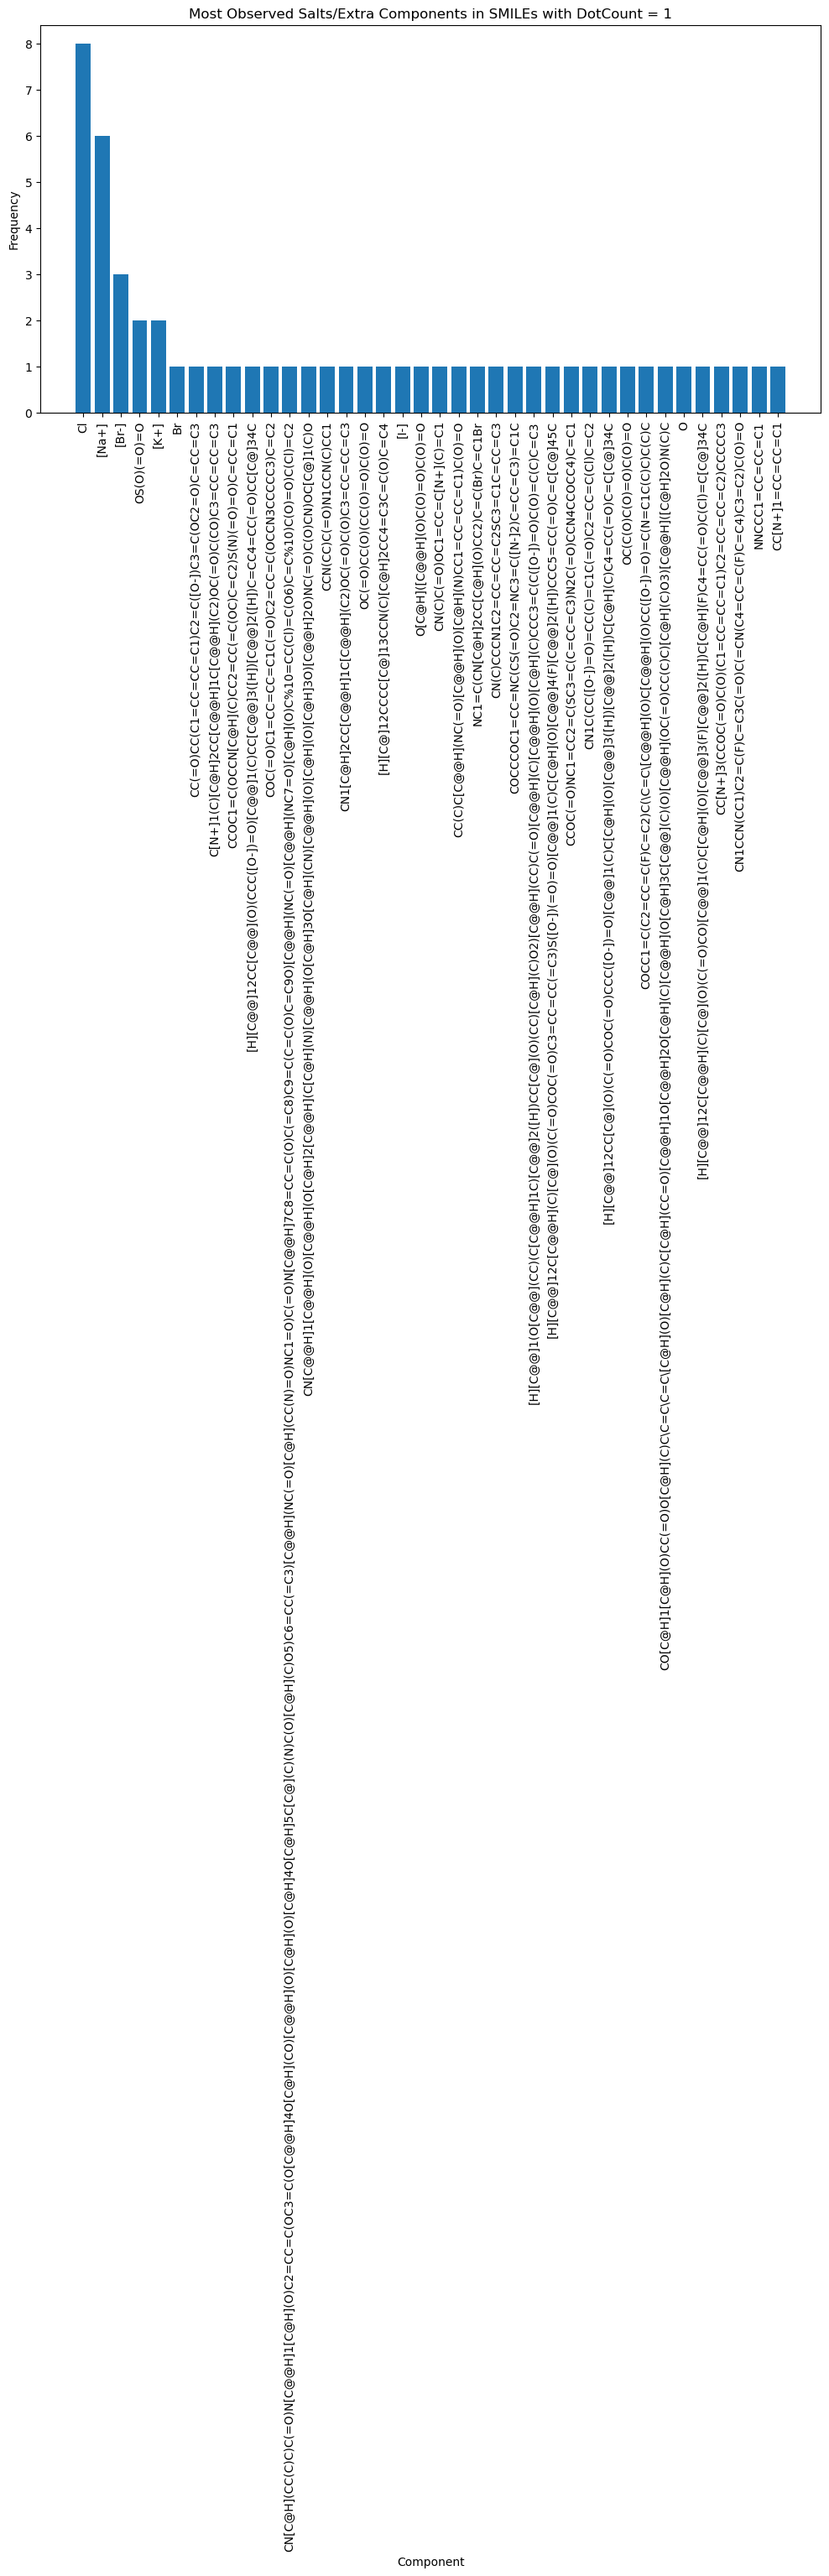

In [51]:
import matplotlib.pyplot as plt


# Plotting component frequencies
plt.figure(figsize=(12, 6))
plt.bar(component_counts_df['Component'], component_counts_df['Frequency'])
plt.xlabel('Component')
plt.ylabel('Frequency')
plt.title('Most Observed Salts/Extra Components in SMILEs with DotCount = 1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [52]:
# Cl , Na+ , Br- , # OS(O)(=O)=O , K+ , Br, I-, O (Extra components) dotCount 1
# O[C@H]([C@@H](O)C(O)=O)C(O)=O , OC(=O)CC(O)(CC(O)=O)C(O)=O ( Manual Check Excel)

In [53]:
# For DotCount 2 (Manual Check )
# Cl , Na+ , [O-]S(=O)(=O)C1=CC=CC=C1, [O-]S(=O)(=O)C2=CC=CC=C2, OS(O)(=O)=O

In [54]:
# Salts into one list from above
all_salts = set([
    'Cl', 'Na+', 'Br-', 'OS(O)(=O)=O', 'K+', 'Br', 'I-', 'O',
    'O[C@H]([C@@H](O)C(O)=O)C(O)=O', 'OC(=O)CC(O)(CC(O)=O)C(O)=O',
    '[O-]S(=O)(=O)C1=CC=CC=C1', '[O-]S(=O)(=O)C2=CC=CC=C2'
])


In [55]:
#Filter initial_data for activating SMILES with DotCount between 0 and 2
filtered_data = initial_data[(initial_data['Function'] == 1) & (initial_data['DotCount'].between(0, 2))]

In [56]:
# Function to remove all salts and validate the resulting SMILE
def remove_all_salts_and_validate(smile, salts):
    components = smile.split('.')
    cleaned_smile = '.'.join([comp for comp in components if comp not in salts])
    mol = Chem.MolFromSmiles(cleaned_smile)
    return cleaned_smile if mol is not None else None


In [57]:
filtered_data['Valid_SMILE'] = filtered_data['SMILE'].apply(
    lambda x: remove_all_salts_and_validate(x, all_salts)
)

# Retain only valid SMILES
valid_smiles = filtered_data[filtered_data['Valid_SMILE'].notnull()]

# Select required columns and save
activating_molecules = valid_smiles[['Valid_SMILE', 'ID', 'Function']]
activating_molecules.columns = ['SMILE', 'ID', 'Function']
activating_molecules.to_csv("Activating_Molecules.txt", sep='\t', index=False)

"File 'Activating_Molecules.txt' has been created successfully."

/var/folders/93/kkjjknp12k582b4gm6fvlsxc0000gn/T/ipykernel_13661/2828870087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Valid_SMILE'] = filtered_data['SMILE'].apply(


"File 'Activating_Molecules.txt' has been created successfully."

In [58]:
# Have edited some molecules in the file. 

In [59]:
# Combining the activated molecules and the molecules with 0 Dotcount 
# We run the feature generation again to remove molecules for which features cannot be generated

In [64]:
combined_file_path = "Combined_Data.txt"
combined_data = pd.read_csv(combined_file_path, sep='\t')

combined_data.head()

,SMILE,ID,Function
0,ClC1=CC=C(NC(=N)NC(=N)NCCCCCCNC(=N)NC(=N)NC2=C...,NCGC00258955-01,1
1,CCN(CC)C1=CC=C2C(C)=CC(=O)OC2=C1,NCGC00259338-01,1
2,OC1=CC(=CC(O)=C1O)C(=O)OC2=CC(=CC(O)=C2O)C(=O)...,NCGC00095101-01,1
3,[H][C@@]12OC\C3=C/C=C/[C@H](C)C\C(C)=C\C[C@]4(...,NCGC00183118-01,1
4,COCC1=C(C2=CC=C(F)C=C2)C(\C=C\[C@@H](O)C[C@@H]...,NCGC00164625-02,1


In [78]:
function_counts = combined_data['Function'].value_counts()
print("Function counts:\n", function_counts)

# Duplicates were removed 


Function counts:
 0    5726
1     306
Name: Function, dtype: int64


In [79]:
smiles_list = combined_data['SMILE'].tolist()
id_list = combined_data['ID'].tolist()
function_list = combined_data['Function'].tolist()


In [80]:
processed_data, failed_entries = process_smiles_extended(smiles_list, id_list, function_list)


Processing 1/6032: ClC1=CC=C(NC(=N)NC(=N)NCCCCCCNC(=N)NC(=N)NC2=CC=C(Cl)C=C2)C=C1 (ID: NCGC00258955-01, Function: 1)
Processing 2/6032: CCN(CC)C1=CC=C2C(C)=CC(=O)OC2=C1 (ID: NCGC00259338-01, Function: 1)
Processing 3/6032: OC1=CC(=CC(O)=C1O)C(=O)OC2=CC(=CC(O)=C2O)C(=O)OC[C@H]3O[C@@H](OC(=O)C4=CC(O)=C(O)C(OC(=O)C5=CC(O)=C(O)C(O)=C5)=C4)[C@H](OC(=O)C6=CC(O)=C(O)C(OC(=O)C7=CC(O)=C(O)C(O)=C7)=C6)[C@@H](OC(=O)C8=CC(O)=C(O)C(OC(=O)C9=CC(O)=C(O)C(O)=C9)=C8)[C@@H]3OC(=O)C%10=CC(O)=C(O)C(OC(=O)C%11=CC(O)=C(O)C(O)=C%11)=C%10 (ID: NCGC00095101-01, Function: 1)
Failed to generate initial conformer.
Conformer generation failed for SMILES: OC1=CC(=CC(O)=C1O)C(=O)OC2=CC(=CC(O)=C2O)C(=O)OC[C@H]3O[C@@H](OC(=O)C4=CC(O)=C(O)C(OC(=O)C5=CC(O)=C(O)C(O)=C5)=C4)[C@H](OC(=O)C6=CC(O)=C(O)C(OC(=O)C7=CC(O)=C(O)C(O)=C7)=C6)[C@@H](OC(=O)C8=CC(O)=C(O)C(OC(=O)C9=CC(O)=C(O)C(O)=C9)=C8)[C@@H]3OC(=O)C%10=CC(O)=C(O)C(OC(=O)C%11=CC(O)=C(O)C(O)=C%11)=C%10
Processing 4/6032: [H][C@@]12OC\C3=C/C=C/[C@H](C)C\C(C)=C\C[C@]4([H]

Processing 56/6032: COC3=CC=C(CC4C5=CC(OC)=C(OC)C=C5CC[N+]4(C)CCC(=O)OCCCCCOC(=O)CC[N+]6(C)CCC7=CC(OC)=C(OC)C=C7C6CC8=CC=C(OC)C(OC)=C8)C=C3OC (ID: NCGC00017127-01, Function: 1)
Processing 57/6032: [H][C@@]12C[C@@]3([H])[C@]4([H])CCC5=CC(=O)C=C[C@]5(C)[C@@]4([H])[C@@H](O)C[C@]3(C)[C@@]1(O[C@@H](O2)C6CCCCC6)C(=O)COC(=O)C(C)C (ID: NCGC00167484-01, Function: 1)
Processing 58/6032: [H][C@@]12C[C@@H](C)[C@](OC(=O)CC)(C(=O)COC(=O)CC)[C@@]1(C)C[C@H](O)[C@@]3([H])[C@@]2([H])[C@H](Cl)CC4=CC(=O)C=C[C@]34C (ID: NCGC00016984-01, Function: 1)
Processing 59/6032: [H][C@@]12C[C@H](C)[C@](OC(=O)CCC)(C(=O)COC(=O)CC)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])CCC4=CC(=O)C=C[C@]34C (ID: NCGC00183597-01, Function: 1)
Processing 60/6032: [H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=C(Cl)C(=O)CC[C@]34C (ID: NCGC00160498-01, Function: 1)
Processing 61/6032: COC1=CC=CC(=N1)N(C)C(=S)OC2=CC3=C(CCCC3)C=C2 (ID: NCGC00164601-01, Function: 1)
Processing 62/6032: [H][C@@]12CC[C@H](C(=O)NC3=CC(=CC=C3C(F)(F)F)C(

Processing 116/6032: CC(=O)OCC(=O)[C@@]1(O)CCC2C3CCC4=CC(=O)CC[C@]4(C)C3[C@@H](O)C[C@]12C (ID: NCGC00183367-01, Function: 1)
Processing 117/6032: CCOC1=CC=C(C=C1)N=NC2=C(N)C=C(N)C=C2 (ID: NCGC00160548-01, Function: 1)
Processing 118/6032: [H][C@@]12C[C@@H](C)[C@](OC(=O)C3=CC=CO3)(C(=O)CCl)[C@@]1(C)C[C@H](O)[C@@]4(Cl)[C@@]2([H])CCC5=CC(=O)C=C[C@]45C (ID: NCGC00016950-01, Function: 1)
Processing 119/6032: [H][C@@]12C[C@@H](C)[C@](O)(C(=O)CO)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])C[C@H](F)C4=CC(=O)C(Cl)=C[C@]34C (ID: NCGC00164585-01, Function: 1)
Processing 120/6032: [H][C@@]12C[C@@H](C)[C@](OC(=O)CC)(C(=O)SCF)[C@@]1(C)C[C@H](O)[C@@]3(F)C2C[C@H](F)C4=CC(=O)C=C[C@]34C (ID: NCGC00016943-01, Function: 1)
Processing 121/6032: [H][C@@]12CCC(=O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00023902-06, Function: 1)
Processing 122/6032: [H][C@@]12C[C@@H](C)[C@](O)(C(=O)CO)[C@@]1(C)C[C@H](O)[C@@]3(F)[C@@]2([H])C[C@H](F)C4=CC(=O)C=C[C@]34C (ID: NCGC00016604-01, Function: 1)
Process

Processing 182/6032: [H][C@@]12CC[C@H]([C@H](C)CCC(O)=O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])[C@H](O)C[C@]4([H])C[C@H](O)CC[C@]34C (ID: NCGC00016387-02, Function: 1)
Processing 183/6032: [H][C@@]12CCC(O)(C#C)[C@@]1(CC)CC[C@]3([H])[C@@]4([H])CCC(=O)C=C4CC[C@@]23[H] (ID: NCGC00256735-01, Function: 1)
Processing 184/6032: [H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3([H])C4=CC=C(O)C=C4CC[C@@]23[H] (ID: NCGC00013235-01, Function: 1)
Processing 185/6032: [H][C@@]12CC3=CNC4=CC=CC(=C34)C1=C[C@H](CN2C)C(=O)N[C@@H](C)CO (ID: NCGC00163165-01, Function: 1)
Processing 186/6032: C[C@H]1CN(C[C@@H](C)N1)C2=C(F)C3=C(C(=O)C(=CN3C4CC4)C(O)=O)C(N)=C2F (ID: NCGC00159333-02, Function: 1)
Processing 187/6032: C\C=C\C=C\C(O)=O (ID: NCGC00091737-01, Function: 1)
Processing 188/6032: OC1=CC(Cl)=C(C=C1)C2=CC=CC=C2 (ID: NCGC00255214-01, Function: 1)
Processing 189/6032: OC1=CC2=C(OCO2)C=C1 (ID: NCGC00258763-01, Function: 1)
Processing 190/6032: CC(C)(O)C(=O)NC1=CC(=C(C=C1)[N+]([O-])=O)C(F)(F)F (ID: NCGC00257382-01, 

[13:03:09] UFFTYPER: Warning: hybridization set to SP3 for atom 20
[13:03:09] UFFTYPER: Warning: hybridization set to SP3 for atom 20


Processing 232/6032: NS(=O)(=O)C1=C(OC2=CC=CC=C2)C(=CC(=C1)C(O)=O)N3CCCC3 (ID: NCGC00016878-01, Function: 1)
Processing 233/6032: [H][C@@]12CCC(=O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=C(O)C(=O)CC[C@]34C (ID: NCGC00164380-02, Function: 1)
Processing 234/6032: [H][C@@]12CCC3=CC(=O)C=C[C@]3(C)[C@@]1([H])CC[C@]4(C)OC(=O)CC[C@@]24[H] (ID: NCGC00159329-02, Function: 1)
Processing 235/6032: CC1(C)S[C@@H]2[C@H](\N=C\N3CCCCCC3)C(=O)N2[C@H]1C(O)=O (ID: NCGC00164583-01, Function: 1)
Processing 236/6032: [H][C@@]12CC[C@H](C(=O)CO)[C@@]1(C)C[C@H](O)[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00022472-05, Function: 1)
Processing 237/6032: [H][C@@]12CC[C@@](O)(CCC([O-])=O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])C=CC4=CC(=O)CC[C@]34C (ID: NCGC00017146-01, Function: 1)
Processing 238/6032: S1C=CC=C1C2=CC=C(S2)C3=CC=CS3 (ID: NCGC00254556-01, Function: 1)
Processing 239/6032: [H][C@@]12CC[C@H](C(=O)COC(C)=O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00022043-04, Function: 1)
Process

Processing 312/6032: OC1(CCN(CCCC(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3)CC1)C4=CC=C(Cl)C(=C4)C(F)(F)F (ID: NCGC00165865-01, Function: 0)
Processing 313/6032: CC(C)OC(=O)C1=C(C)NC(N)=C(C1C2=CC(=CC=C2)[N+]([O-])=O)C(=O)OC3CN(C3)C(C4=CC=CC=C4)C5=CC=CC=C5 (ID: NCGC00167436-01, Function: 0)
Processing 314/6032: CC(C)(C1=CC=CC=C1)C2=CC(=C(O)C=C2)C(C)(C)C3=CC=CC=C3 (ID: NCGC00260005-01, Function: 0)
Processing 315/6032: [H][C@]12CC[C@H](C)CN1[C@@]3([H])C[C@@]4([H])[C@]5([H])CC=C6CC(CC[C@]6(C)[C@@]5([H])CC[C@]4(C)[C@@]3([H])[C@@H]2C)O[C@@H]7O[C@H](CO)[C@H](O)[C@H](O[C@@H]8O[C@H](CO)[C@@H](O)[C@H](O)[C@H]8O)[C@H]7O[C@H]9O[C@@H](C)[C@H](O)[C@@H](O)[C@H]9O (ID: NCGC00091441-01, Function: 0)
Processing 316/6032: ClC1=CC=C(NC(=N)NC(=N)NCCCCCCNC(=N)NC(=N)NC2=CC=C(Cl)C=C2)C=C1 (ID: NCGC00257242-01, Function: 0)
Processing 317/6032: [H][C@@]12OC\C3=C/C=C/[C@H](C)[C@H](O[C@@]4([H])C[C@H](OC)[C@@H](O[C@@]5([H])C[C@H](OC)[C@@H](O)[C@H](C)O5)[C@H](C)O4)\C(C)=C\C[C@]6([H])C[C@@]([H])(C[C@]7(CC[C@H](C)[C@]([H])(O7)

[13:09:24] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[13:09:24] UFFTYPER: Unrecognized charge state for atom: 1
[13:09:24] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[13:09:24] UFFTYPER: Unrecognized charge state for atom: 1


Processing 320/6032: CC1=CC(=C(O)C=C1)C(C)(C)C (ID: NCGC00259487-01, Function: 0)
Processing 321/6032: C[N+]1=CC2=C(C=CC3=C2OCO3)C4=C1C5=C(C=C4)C=C6OCOC6=C5 (ID: NCGC00015959-03, Function: 0)
Processing 322/6032: OC1=C([Hg]Cl)C=CC=C1 (ID: NCGC00181158-01, Function: 0)
Processing 323/6032: CCCCCCCCCCCC(=O)NCCCN(C)C (ID: NCGC00256156-01, Function: 0)
Processing 324/6032: CCCN(CCC)C1=C(C(N)=C(C=C1[N+]([O-])=O)C(F)(F)F)[N+]([O-])=O (ID: NCGC00254602-01, Function: 0)
Processing 325/6032: CCCCCCCCNC(C)C(O)C1=CC=C(SC(C)C)C=C1 (ID: NCGC00018301-02, Function: 0)
Processing 326/6032: ClC(Cl)(Cl)SN1C(=O)C2CC=CCC2C1=O (ID: NCGC00254676-01, Function: 0)
Processing 327/6032: COC1=CC=C2[C@H]([C@H](C3=CC=CC=C3)C(C)(C)OC2=C1)C4=CC=C(OCCN5CCCC5)C=C4 (ID: NCGC00181100-01, Function: 0)
Processing 328/6032: O=C1C=CC(=O)N1C2=CC=CC=C2 (ID: NCGC00254580-01, Function: 0)
Processing 329/6032: OC1=CC=CC(=C1)C2=C3NC(C=C3)=C(C4=NC(C=C4)=C(C5=CC=C(N5)C(=C6CCC2=N6)C7=CC(O)=CC=C7)C8=CC(O)=CC=C8)C9=CC(O)=CC=C9 (ID: NC

[13:09:30] UFFTYPER: Unrecognized atom type: Au6+3 (7)
[13:09:31] UFFTYPER: Unrecognized atom type: Au6+3 (7)


Processing 348/6032: [H][C@@]12OC\C3=C/C=C/[C@H](C)C\C(C)=C\C[C@]4([H])C[C@@H](C[C@]5(C\C(=N\OC)[C@H](C)[C@H](O5)C(\C)=C\C(C)C)O4)OC(=O)[C@]([H])(C=C(C)[C@H]1O)[C@@]23O (ID: NCGC00182083-02, Function: 0)
Processing 349/6032: [O-][N+](=O)C1=CC(=C(Cl)C(=C1Cl)[N+]([O-])=O)C(F)(F)F (ID: NCGC00256855-01, Function: 0)
Processing 350/6032: C\C=C\C(=O)OC1=C(C=C(C=C1CCCCCC(C)C)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00255514-01, Function: 0)
Processing 351/6032: CCCCCCCCCCCCN(CCO)CCO (ID: NCGC00255856-01, Function: 0)
Processing 352/6032: CCC(C)NC1=CC=C(NC(C)CC)C=C1 (ID: NCGC00257925-01, Function: 0)
Processing 353/6032: OC1=C(C=C(Cl)C=C1)C(=O)NC2=CC=C(C=C2Cl)[N+]([O-])=O (ID: NCGC00254654-01, Function: 0)
Processing 354/6032: [H][C@@]12OC\C3=C/C=C/[C@H](C)C\C(C)=C\C[C@]4([H])C[C@@H](C[C@]5(CC[C@H](C)[C@@H](CC)O5)O4)OC(=O)[C@]([H])(C=C(C)[C@H]1O)[C@@]23O (ID: NCGC00254847-01, Function: 0)
Processing 355/6032: [H][C@@]12N3CC[C@@]14C5=C(C=C(OC)C(=C5)[C@]6(C[C@@H]7C[N@@](C[C@](O)(CC)C7)CCC8=C6NC9=C8C=C

Processing 419/6032: [H][C@]1(C[C@@H](C)C[C@H](C)C1=O)[C@H](O)CC2CC(=O)NC(=O)C2 (ID: NCGC00024910-01, Function: 0)
Processing 420/6032: OC1=CC2=C(C=C1)C3(OC(=O)C4=C3C=CC=C4)C5=C(O2)C=C(O)C=C5 (ID: NCGC00161643-03, Function: 0)
Processing 421/6032: ClC1=CC=CC(NN=C(C#N)C#N)=C1 (ID: NCGC00255699-01, Function: 0)
Processing 422/6032: CC(C)N(C(=O)CCl)C1=CC=CC=C1 (ID: NCGC00259283-01, Function: 0)
Processing 423/6032: CCCCCCCC[Sn](Cl)(Cl)CCCCCCCC (ID: NCGC00258036-01, Function: 0)
Processing 424/6032: [H][C@]12C[C@H](OC(C)=O)C(C)(C)[C@](O)(C[C@]3([H])C\C(C[C@@]([H])(O3)\C=C\C(C)(C)[C@]4(O)O[C@@]([H])(C\C(=C/C(=O)OC)[C@@H]4OC(=O)\C=C\C=C\CCC)C[C@@]([H])(OC(=O)C[C@H](O)C1)[C@@H](C)O)=C\C(=O)OC)O2 (ID: NCGC00181150-01, Function: 0)
Processing 425/6032: CCCC[Sn](Cl)(Cl)CCCC (ID: NCGC00259224-01, Function: 0)
Processing 426/6032: ClC(Cl)C(C1=CC=C(Cl)C=C1)C2=CC=C(Cl)C=C2 (ID: NCGC00258848-01, Function: 0)
Processing 427/6032: COC(=O)N(C(=O)N1CO[C@]2(CC3=C(C=CC(Cl)=C3)C2=N1)C(=O)OC)C4=CC=C(OC(F)(F)

[13:19:45] UFFTYPER: Unrecognized atom type: Zn1+2 (8)
[13:19:45] UFFTYPER: Unrecognized atom type: Zn1+2 (8)


Processing 472/6032: [H][C@]12[C@H](C[C@@H](C)C=C1C=C[C@H](C)[C@@H]2CC[C@@H]3C[C@@H](O)CC(=O)O3)OC(=O)[C@@H](C)CC (ID: NCGC00259026-01, Function: 0)
Processing 473/6032: C1=CC2=CC3=C(C=C2C=C1)C4=C5C3=CC=CC5=CC=C4 (ID: NCGC00258275-01, Function: 0)
Processing 474/6032: CO[C@H]1[C@@H](CC(=O)O[C@H](C)CC2OC2\C=C\C(=O)[C@H](C)C[C@H](CC=O)[C@@H]1O[C@@H]3O[C@H](C)[C@@H](O[C@H]4C[C@@](C)(O)[C@@H](OC(=O)CC(C)C)[C@H](C)O4)[C@@H]([C@H]3O)N(C)C)OC(C)=O (ID: NCGC00181116-01, Function: 0)
Processing 475/6032: CCCC[Sn](CCCC)(CCCC)OC(=O)C(C)=C (ID: NCGC00254380-01, Function: 0)
Processing 476/6032: ClC1(Cl)CS(=O)(=O)CC1(Cl)Cl (ID: NCGC00255452-01, Function: 0)
Processing 477/6032: ClC1=C(C=CC=C1)C(N2C=CN=C2)(C3=CC=CC=C3)C4=CC=CC=C4 (ID: NCGC00254538-01, Function: 0)
Processing 478/6032: ClC1=CC(Cl)=C(C=C1)[C@@H]2CS\C(S2)=C(\C#N)N3C=CN=C3 (ID: NCGC00182704-01, Function: 0)
Processing 479/6032: NC(=O)N1C(=O)C(C(=O)C2=CC(Cl)=CS2)C3=C1C=C(Cl)C(F)=C3 (ID: NCGC00254304-01, Function: 0)
Processing 480/6032: 

[13:28:02] UFFTYPER: Unrecognized hybridization for atom: 1
[13:28:02] UFFTYPER: Unrecognized atom type: Au+3 (1)
[13:28:02] UFFTYPER: Unrecognized hybridization for atom: 1
[13:28:02] UFFTYPER: Unrecognized atom type: Au+3 (1)


Processing 515/6032: ClC1=CC=C(C=C1)C(C2=CC=C(Cl)C=C2)C(Cl)(Cl)Cl (ID: NCGC00254176-01, Function: 0)
Processing 516/6032: OC1=C(I)C=C(C=C1I)C#N (ID: NCGC00255309-01, Function: 0)
Processing 517/6032: ClCC(=O)C1=CC=CC=C1 (ID: NCGC00254035-01, Function: 0)
Processing 518/6032: CC(C)(C)C(=O)OCOC(=O)C1N2C(CC2=O)S(=O)(=O)C1(C)C (ID: NCGC00249610-01, Function: 0)
Processing 519/6032: OC(C1=CC=C(Cl)C=C1)(C2=CC=C(Cl)C=C2)C(Cl)(Cl)Cl (ID: NCGC00254890-01, Function: 0)
Processing 520/6032: OC1=C(Br)C=C(C=C1Br)C#N (ID: NCGC00255099-01, Function: 0)
Processing 521/6032: ClC1=CC2=CC3=CC=CC=C3C=C2C=C1 (ID: NCGC00260506-01, Function: 0)
Processing 522/6032: ClC1=CC(Cl)=C(C=C1)C(CN2C=CN=C2)OCC=C (ID: NCGC00259100-01, Function: 0)
Processing 523/6032: COP(=S)(OC)OC1=CC=C(SC2=CC=C(OP(=S)(OC)OC)C=C2)C=C1 (ID: NCGC00255338-01, Function: 0)
Processing 524/6032: OC1=C(Cl)C(Cl)=CC(Cl)=C1Cl (ID: NCGC00258464-01, Function: 0)
Processing 525/6032: CCCC(CN1C=NC=N1)C2=C(Cl)C=C(Cl)C=C2 (ID: NCGC00255892-01, Functi

Processing 595/6032: COC(=O)C1=C(C)NC(C)=C(C1C2=CC=CC=C2[N+]([O-])=O)C(=O)OC (ID: NCGC00257858-01, Function: 0)
Processing 596/6032: CC(\C=C\C=C(C)\C=C\C1=C(C)C[C@@H](O)CC1(C)C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)C[C@@H](O)CC2(C)C (ID: NCGC00181020-01, Function: 0)
Processing 597/6032: CC1=CC(NC2=C(C=CC=C2)C(O)=O)=CC=C1Cl (ID: NCGC00160431-01, Function: 0)
Processing 598/6032: C[C@H]1CCC[C@@]2(C)O[C@H]2C[C@@H](OC(=O)C[C@H](O)C(C)(C)C(=O)[C@H](C)C1O)C(\C)=C\C3=CSC(C)=N3 (ID: NCGC00181131-01, Function: 0)
Processing 599/6032: CCC1=CC(CC2=CC(CC)=C(N)C(CC)=C2)=CC(CC)=C1N (ID: NCGC00257494-01, Function: 0)
Processing 600/6032: CCCCOCCOP(=O)(OCCOCCCC)OCCOCCCC (ID: NCGC00259142-01, Function: 0)
Processing 601/6032: CCCCC1=C(C(=O)C2=CC(I)=C(OCCN(CC)CC)C(I)=C2)C3=CC=CC=C3O1 (ID: NCGC00015096-07, Function: 0)
Processing 602/6032: Cl[Hg]C1=CC=CC=C1 (ID: NCGC00254782-01, Function: 0)
Processing 603/6032: OC1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1 (ID: NCGC00257659-01, Function: 0)
Processing 604/6032: OCC(C1=CC

Processing 674/6032: CC1=C(C)C(NC2=C(C=CC=C2)C(O)=O)=CC=C1 (ID: NCGC00255401-01, Function: 0)
Processing 675/6032: O=C(OCC(COC(=O)C1=CC=CC=C1)(COC(=O)C2=CC=CC=C2)COC(=O)C3=CC=CC=C3)C4=CC=CC=C4 (ID: NCGC00258541-01, Function: 0)
Processing 676/6032: ClC1=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl (ID: NCGC00259828-01, Function: 0)
Processing 677/6032: [O-][N+]1=C(SSC2=[N+]([O-])C=CC=C2)C=CC=C1 (ID: NCGC00164493-01, Function: 0)
Processing 678/6032: CCOCN1C(=C(C#N)C(Br)=C1C(F)(F)F)C2=CC=C(Cl)C=C2 (ID: NCGC00255354-01, Function: 0)
Processing 679/6032: OC1=CC=C(C2=C1N=CC=C2)[N+]([O-])=O (ID: NCGC00160664-01, Function: 0)
Processing 680/6032: [O-][N+](=O)C1=CC(=C(Cl)C(=C1NC2=C(Cl)C=C(C=N2)C(F)(F)F)[N+]([O-])=O)C(F)(F)F (ID: NCGC00255075-01, Function: 0)
Processing 681/6032: CCC(C)(C)C1=CC=C(CC(C)CN2C[C@H](C)O[C@H](C)C2)C=C1 (ID: NCGC00167524-01, Function: 0)
Processing 682/6032: C(OC1=CC=C(C=C1)C(C2=CC=C(OCC3CO3)C=C2)C4=CC=C(OCC5CO5)C=C4)C6CO6 (ID: NCGC00256272-01, Function: 0)
Processing 683/6032: CC(C)(C)

Processing 751/6032: CC1=C2C(O)=CC3=C4C2=C(C(O)=C1)C(=O)C5=C4C(=C(O)C=C5O)C(=O)C3(C)C (ID: NCGC00160275-02, Function: 0)
Processing 752/6032: [O-][N+](=O)C=CC1=CC=CC=C1 (ID: NCGC00254585-01, Function: 0)
Processing 753/6032: OC1=C(Br)C(Br)=C(Br)C(Br)=C1Br (ID: NCGC00257893-01, Function: 0)
Processing 754/6032: CCNC(=O)\C=C\C1=CC=CC(Br)=C1 (ID: NCGC00164530-01, Function: 0)
Processing 755/6032: C=CC(=O)OCCN1C(=O)N(CCOC(=O)C=C)C(=O)N(CCOC(=O)C=C)C1=O (ID: NCGC00256218-01, Function: 0)
Processing 756/6032: C1=CC2=C3C=CC=C4C=CC5=CC=CC(=C2C=C1)C5=C34 (ID: NCGC00259273-01, Function: 0)
Processing 757/6032: CC(=O)OC1=CC=C(C=C1)C2(C(=O)NC3=CC=CC=C23)C4=CC=C(OC(C)=O)C=C4 (ID: NCGC00159420-02, Function: 0)
Processing 758/6032: CCOC1=C(C=CC(=C1)C(C)(C)C)C2COC(=N2)C3=C(F)C=CC=C3F (ID: NCGC00254926-01, Function: 0)
Processing 759/6032: CC(C)[C@H](NC(=O)N(C)CC1=CSC(=N1)C(C)C)C(=O)N[C@H](C[C@H](O)[C@H](CC2=CC=CC=C2)NC(=O)OCC3=CN=CS3)CC4=CC=CC=C4 (ID: NCGC00183130-01, Function: 0)
Processing 760/6032:

[13:31:25] UFFTYPER: Unrecognized atom type: Cd1+2 (4)
[13:31:25] UFFTYPER: Unrecognized atom type: Cd1+2 (4)


Processing 784/6032: CC(\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C)=C\C=O (ID: NCGC00258629-01, Function: 0)
Processing 785/6032: CC1=CC(=CC(C)=C1O)C(C)(C)C2=CC(C)=C(O)C(C)=C2 (ID: NCGC00258762-01, Function: 0)
Processing 786/6032: CC(\C=C\C=C(C)\C=C\[C@H]1C(C)=C[C@H](O)CC1(C)C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)C[C@@H](O)CC2(C)C (ID: NCGC00167965-01, Function: 0)
Processing 787/6032: CC1=C(CNC2=NC=NC3=C2N=CN3[C@@H]4O[C@H](CO)[C@@H](O)[C@H]4O)C=CC=C1 (ID: NCGC00015640-02, Function: 0)
Processing 788/6032: CCCNCC(O)COC1=C(C=CC=C1)C(=O)CCC2=CC=CC=C2 (ID: NCGC00015819-06, Function: 0)
Processing 789/6032: CCOC1=CC=C(C=C1)[N+]([O-])=O (ID: NCGC00258283-01, Function: 0)
Processing 790/6032: CN1CCCN(CC1)C(C2=CC=CC=C2)C3=CC=C(Cl)C=C3 (ID: NCGC00018271-03, Function: 0)
Processing 791/6032: ClC1=CC=C2N(CC3CC3)C(=O)CN=C(C4=CC=CC=C4)C2=C1 (ID: NCGC00168256-01, Function: 0)
Processing 792/6032: CCCCOCN(C(=O)CCl)C1=C(CC)C=CC=C1CC (ID: NCGC00254842-01, Function: 0)
Processing 793/6032: [H][C@@]1(C[C@H]2CC[N@

[13:31:35] UFFTYPER: Unrecognized atom type: Au6+3 (6)
[13:31:35] UFFTYPER: Unrecognized atom type: Au6+3 (6)


Processing 836/6032: OC1=CC=C(C=C1)C2(OC(=O)C3=C2C=CC=C3)C4=CC=C(O)C=C4 (ID: NCGC00018200-07, Function: 0)
Processing 837/6032: OC1=CC=C(C=C1)S(O)(=O)=O (ID: NCGC00164534-01, Function: 0)
Processing 838/6032: [H][C@@]12CC[C@@](O)(C#C)[C@@]1(C)CC[C@]3([H])C4=CC=C(O)C=C4CC[C@@]23[H] (ID: NCGC00091533-04, Function: 0)
Processing 839/6032: CNC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(C)C)CC(=O)NO (ID: NCGC00163450-02, Function: 0)
Processing 840/6032: CC(C)(C1=CC(Br)=C(O)C(Br)=C1)C2=CC(Br)=C(O)C(Br)=C2 (ID: NCGC00258734-01, Function: 0)
Processing 841/6032: OC1=C(Br)C2=C(C=C1Br)C3(OC(=O)C4=C3C(Cl)=C(Cl)C(Cl)=C4Cl)C5=C(O2)C(Br)=C(O)C(Br)=C5 (ID: NCGC00259714-01, Function: 0)
Processing 842/6032: COC(=O)N[C@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@@H](O)CN(CC2=CC=C(C=C2)C3=NC=CC=C3)NC(=O)[C@@H](NC(=O)OC)C(C)(C)C)C(C)(C)C (ID: NCGC00182552-01, Function: 0)
Processing 843/6032: CCOC(=O)C1=C(C)NC(C)=C(C1C2=CC=CC(=C2)[N+]([O-])=O)C(=O)OC (ID: NCGC00015713-07, Function: 0)
Processing 844/6032: CCC1=C(C)

Processing 915/6032: COC1=C2C(=O)C3=C(C(=O)C2=CC=C1)C(O)=C4C[C@](O)(C[C@H](O[C@H]5C[C@H](N)[C@H](O)[C@H](C)O5)C4=C3O)C(C)=O (ID: NCGC00024246-05, Function: 0)
Processing 916/6032: CC(C)OC(=O)NC1=CC2=C(NC(=N2)C3=CSC=N3)C=C1 (ID: NCGC00181110-01, Function: 0)
Processing 917/6032: CCCCC(=O)OCC(=O)[C@@]1(O)C[C@H](O[C@H]2C[C@H](NC(=O)C(F)(F)F)[C@H](O)[C@H](C)O2)C3=C(C1)C(O)=C4C(=O)C5=C(C(=O)C4=C3O)C(OC)=CC=C5 (ID: NCGC00164738-01, Function: 0)
Processing 918/6032: CCOC1=CC(=CC(OCC)=C1OCC)C2=NC=CC3=C2C=C(OC)C(OC)=C3 (ID: NCGC00160538-01, Function: 0)
Processing 919/6032: FC(F)(F)[C@]1(OC(=O)NC2=CC=C(Cl)C=C12)C#CC3CC3 (ID: NCGC00159337-02, Function: 0)
Processing 920/6032: CC(=O)NC1=CC=C(C=C1)C(=O)CCl (ID: NCGC00256406-01, Function: 0)
Processing 921/6032: O=C1N([Se]C2=C1C=CC=C2)C3=CC=CC=C3 (ID: NCGC00015412-06, Function: 0)
Processing 922/6032: OC1=CC=CC2=CC=CN=C12 (ID: NCGC00090708-03, Function: 0)
Processing 923/6032: OC1=CC=C(OCC2=CC=CC=C2)C=C1 (ID: NCGC00016360-01, Function: 0)
Processin

[13:31:45] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[13:31:45] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[13:31:45] UFFTYPER: Unrecognized atom type: Se2+2 (3)


Processing 928/6032: C[Hg]Cl (ID: NCGC00260073-01, Function: 0)
Processing 929/6032: C(C1CN2CCC1CC2)N3C4=CC=CC=C4SC5=C3C=CC=C5 (ID: NCGC00183046-01, Function: 0)
Processing 930/6032: CCCCCCCCS(=O)C(C)CC1=CC2=C(OCO2)C=C1 (ID: NCGC00257949-01, Function: 0)
Processing 931/6032: CCN(CC)CCC(=O)N1C2=CC=CC=C2SC3=CC=C(Cl)C=C13 (ID: NCGC00160486-01, Function: 0)
Processing 932/6032: ClCC1(CCl)C(=C)C2(Cl)C(Cl)C(Cl)C1(Cl)C2(Cl)Cl (ID: NCGC00258466-01, Function: 0)
Processing 933/6032: CC1=CC(C(C#N)C2=CC=C(Cl)C=C2)=C(Cl)C=C1NC(=O)C3=CC(I)=CC(I)=C3O (ID: NCGC00166312-01, Function: 0)
Processing 934/6032: ClC1=CC2=C(C=C1)N(C3CCN(CCCN4C(=O)NC5=C4C=CC=C5)CC3)C(=O)N2 (ID: NCGC00014670-01, Function: 0)
Processing 935/6032: CN(C)CC\C=C1/C2=CC=CC=C2SC3=C1C=C(Cl)C=C3 (ID: NCGC00013683-01, Function: 0)
Processing 936/6032: COC1=CC=C(C=C1)[C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O (ID: NCGC00024309-05, Function: 0)
Processing 937/6032: FC(F)(F)C1=CC=CC(C(=O)N[C@H]([C@@H]2CCCCN2)C3=CC=CC=C3)=C1Cl (ID: N

Processing 1006/6032: CCC(C)C1=CC(=CC(=C1OC(=O)C=C(C)C)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00255512-01, Function: 0)
Processing 1007/6032: CCOC(=O)C1=CC=C(N=C1)C#CC2=CC=C3SCCC(C)(C)C3=C2 (ID: NCGC00167525-01, Function: 0)
Processing 1008/6032: CC1=CC2=C(C=C1C)N(C[C@H](O)[C@H](O)[C@H](O)CO)C3=NC(=O)NC(=O)C3=N2 (ID: NCGC00256408-01, Function: 0)
Processing 1009/6032: OC[C@@H](O)CONC(=O)C1=C(NC2=CC=C(I)C=C2F)C(F)=C(F)C=C1 (ID: NCGC00189075-01, Function: 0)
Processing 1010/6032: OC1=C(Cl)C=C(Cl)C=C1S(=O)C2=CC(Cl)=CC(Cl)=C2O (ID: NCGC00160554-01, Function: 0)
Processing 1011/6032: CC(C)CCCCCCC1=CC=C(O)C=C1 (ID: NCGC00254520-01, Function: 0)
Processing 1012/6032: S=C(SSSSSSC(=S)N1CCCCC1)N2CCCCC2 (ID: NCGC00260329-01, Function: 0)
Processing 1013/6032: CC(C)(C1=CC(Br)=C(OCCO)C(Br)=C1)C2=CC(Br)=C(OCCO)C(Br)=C2 (ID: NCGC00255549-01, Function: 0)
Processing 1014/6032: COC1=C(OCCCN2CCC(CC2)C3=NOC4=C3C=CC(F)=C4)C=CC(=C1)C(C)=O (ID: NCGC00188864-01, Function: 0)
Processing 1015/6032: CO[C@H]1\C=C\O[

[13:31:52] UFFTYPER: Unrecognized atom type: Co5+3 (17)


Failed to generate initial conformer.
Conformer generation failed for SMILES: CC(CNC(=O)CCC1(C)C(CC(N)=O)C2N([Co+]C[C@H]3O[C@H]([C@H](O)[C@@H]3O)N4C=NC5=C4N=CN=C5N)C1=C(C)C6=NC(=CC7=NC(=C(C)C8=NC2(C)C(C)(CC(N)=O)C8CCC(N)=O)C(C)(CC(N)=O)C7CCC(N)=O)C(C)(C)C6CCC(N)=O)OP([O-])(=O)O[C@@H]9[C@@H](CO)O[C@@H]([C@@H]9O)N%10C=NC%11=C%10C=C(C)C(C)=C%11
Processing 1036/6032: CO[C@H]1C[C@H](C)CC2=C(NCC=C)C(=O)C=C(NC(=O)\C(C)=C\C=C[C@H](OC)[C@@H](OC(N)=O)\C(C)=C\[C@H](C)[C@H]1O)C2=O (ID: NCGC00163424-01, Function: 0)
Processing 1037/6032: COC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@@H]3O)C2=NC(N)=N1 (ID: NCGC00181098-01, Function: 0)
Processing 1038/6032: [H][C@@]1(CC2CCN1C[C@@H]2C=C)[C@@H](O)C3=CC=NC4=C3C=CC=C4 (ID: NCGC00013067-01, Function: 0)
Processing 1039/6032: COC(CNC(=O)C1=CC=CC=C1OCC(O)=O)C[Hg]O (ID: NCGC00181320-01, Function: 0)
Processing 1040/6032: OC1=C(C=C(C=C1[N+]([O-])=O)[N+]([O-])=O)C(=O)N\N=C\C2=CC=C(O2)[N+]([O-])=O (ID: NCGC00160555-01, Function: 0)
Processing 1041/6032: [H][C@]12CC

Processing 1110/6032: [H]\C(=C1/C(C)=C(CC(O)=O)C2=C1C=CC(F)=C2)C3=CC=C(C=C3)S(C)(=O)=O (ID: NCGC00015928-04, Function: 0)
Processing 1111/6032: CSC1=N[C@](C)(C(=O)N1NC2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00254993-01, Function: 0)
Processing 1112/6032: CC(C(O)=O)C1=CC=C(C(F)=C1)C2=CC=CC=C2 (ID: NCGC00016654-01, Function: 0)
Processing 1113/6032: CC1=C(C=C(C#N)C(=O)N1)C2=CC=NC=C2 (ID: NCGC00164390-01, Function: 0)
Processing 1114/6032: NC(=O)N(O)[C@@H]1COC2=C1C=CC(OCC3=CC=CC=C3)=C2 (ID: NCGC00254171-01, Function: 0)
Processing 1115/6032: NC(=O)NO (ID: NCGC00015520-03, Function: 0)
Processing 1116/6032: NC(=S)NS(=O)(=O)C1=CC=C(N)C=C1 (ID: NCGC00181137-01, Function: 0)
Processing 1117/6032: NC1=CC=C(N)C=C1 (ID: NCGC00256482-01, Function: 0)
Processing 1118/6032: CC1=C(C(=NO1)C2=CC=CC=C2)C3=CC=C(C=C3)S(N)(=O)=O (ID: NCGC00095129-01, Function: 0)
Processing 1119/6032: [O-][N+](=O)C1(Br)COCOC1 (ID: NCGC00255969-01, Function: 0)
Processing 1120/6032: CC1=CC=C(C(=C1)[N+]([O-])=O)[N+]([O-])=O (ID: NC

[13:34:41] UFFTYPER: Unrecognized charge state for atom: 1
[13:34:41] UFFTYPER: Unrecognized charge state for atom: 1


Processing 1153/6032: O=C(OCC1=CC=CC=C1)C=CC2=CC=CC=C2 (ID: NCGC00254607-01, Function: 0)
Processing 1154/6032: OC(C1=CC=C(Cl)C=C1)(C2=CN=CN=C2)C3=CC=CC=C3Cl (ID: NCGC00259180-01, Function: 0)
Processing 1155/6032: OC1=CC=C(C=C1)C2(C(=O)NC3=CC=CC=C23)C4=CC=C(O)C=C4 (ID: NCGC00255866-01, Function: 0)
Processing 1156/6032: S=C=NCCC1=CC=CC=C1 (ID: NCGC00257654-01, Function: 0)
Processing 1157/6032: [H][C@@]12CC(=O)\C(=C/C)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CCC4=CC(=O)CC[C@]34C (ID: NCGC00260067-01, Function: 0)
Processing 1158/6032: C1=CC2=CC=C3C=C4C(C=CC5=CC=CC=C45)=CC3=C2C=C1 (ID: NCGC00260054-01, Function: 0)
Processing 1159/6032: CC(=O)OC1=CC=C(C=C1)C2(OC3=C(NC2=O)C=CC=C3)C4=CC=C(OC(C)=O)C=C4 (ID: NCGC00182998-01, Function: 0)
Processing 1160/6032: CCC1=CC(=C(O)C=C1)C(C)(C)C (ID: NCGC00254521-01, Function: 0)
Processing 1161/6032: CC(C)(C)CC(C)(C)C1=CC(N2N=C3C=CC=CC3=N2)=C(O)C=C1 (ID: NCGC00259007-01, Function: 0)
Processing 1162/6032: [H][C@]12[C@H](C[C@@H](C)C=C1C=C[C@H](C)[C@@H]2CC[C

[13:34:41] UFFTYPER: Unrecognized charge state for atom: 1
[13:34:41] UFFTYPER: Unrecognized atom type: Se2+2 (1)
[13:34:41] UFFTYPER: Unrecognized charge state for atom: 1
[13:34:41] UFFTYPER: Unrecognized atom type: Se2+2 (1)


Processing 1176/6032: OC(=O)C1(CC1)C(=O)NC2=CC=C(Cl)C=C2Cl (ID: NCGC00254977-01, Function: 0)
Processing 1177/6032: CCCCC\C=C/C\C=C/CCCCCCCC(O)=O (ID: NCGC00257024-01, Function: 0)
Processing 1178/6032: OC1=CC(=CC(O)=C1O)C(=O)OC2=CC(=CC(O)=C2O)C(=O)OC[C@H]3O[C@@H](OC(=O)C4=CC(O)=C(O)C(OC(=O)C5=CC(O)=C(O)C(O)=C5)=C4)[C@H](OC(=O)C6=CC(O)=C(O)C(OC(=O)C7=CC(O)=C(O)C(O)=C7)=C6)[C@@H](OC(=O)C8=CC(O)=C(O)C(OC(=O)C9=CC(O)=C(O)C(O)=C9)=C8)[C@@H]3OC(=O)C%10=CC(O)=C(O)C(OC(=O)C%11=CC(O)=C(O)C(O)=C%11)=C%10 (ID: NCGC00253925-01, Function: 0)
Failed to generate initial conformer.
Conformer generation failed for SMILES: OC1=CC(=CC(O)=C1O)C(=O)OC2=CC(=CC(O)=C2O)C(=O)OC[C@H]3O[C@@H](OC(=O)C4=CC(O)=C(O)C(OC(=O)C5=CC(O)=C(O)C(O)=C5)=C4)[C@H](OC(=O)C6=CC(O)=C(O)C(OC(=O)C7=CC(O)=C(O)C(O)=C7)=C6)[C@@H](OC(=O)C8=CC(O)=C(O)C(OC(=O)C9=CC(O)=C(O)C(O)=C9)=C8)[C@@H]3OC(=O)C%10=CC(O)=C(O)C(OC(=O)C%11=CC(O)=C(O)C(O)=C%11)=C%10
Processing 1179/6032: CCOP(=O)(SC1=CC=CC=C1)SC2=CC=CC=C2 (ID: NCGC00255720-01, Function:

Processing 1260/6032: CCCCC[C@H](O)\C=C\[C@H]1[C@H](O)C[C@H](O)[C@@H]1C\C=C/CCCC(O)=O (ID: NCGC00160385-01, Function: 0)
Processing 1261/6032: O=C(CN1CCN(CC2=CC=C3OCOC3=C2)CC1)N4C5=CC=CC=C5SC6=CC=CC=C46 (ID: NCGC00160678-01, Function: 0)
Processing 1262/6032: OC1=CC(C=C(C#N)C#N)=CC(O)=C1O (ID: NCGC00016046-02, Function: 0)
Processing 1263/6032: CCCCCCCC\C=C/CCCCCCCC(=O)NCC1=CC(OC)=C(O)C=C1 (ID: NCGC00024885-01, Function: 0)
Processing 1264/6032: CN1CCC2=C(C=C(O)C(Cl)=C2)[C@@H]3[C@@H]1CCC4=CC=CC=C34 (ID: NCGC00092362-01, Function: 0)
Processing 1265/6032: [H][C@@]12CCCC[C@@]13CCN(CC=C)[C@@H]2CC4=C3C=C(O)C=C4 (ID: NCGC00162247-02, Function: 0)
Processing 1266/6032: [H][C@]12[C@H](CCC=C1C=C[C@H](C)[C@@H]2CC[C@@H]3C[C@@H](O)CC(=O)O3)OC(=O)[C@@H](C)CC (ID: NCGC00095942-01, Function: 0)
Processing 1267/6032: COC1=CC2=CC=C(C=C2C=C1)[C@H](C)CO (ID: NCGC00095068-01, Function: 0)
Processing 1268/6032: CCCCCCCCCCCCCCCCSCC(COC)COP([O-])(=O)OCC[N+](C)(C)C (ID: NCGC00165808-01, Function: 0)
Processi

Processing 1338/6032: [H][C@@]1(CC[C@@]2([H])\C(CCC[C@]12C)=C\C=C3/C[C@@H](O)CC[C@@H]3C)[C@H](C)\C=C\[C@H](C)C(C)C (ID: NCGC00166147-02, Function: 0)
Processing 1339/6032: C1=CC2=CC3=CC=C4C=CC=C5C=CC(=C2C=C1)C3=C45 (ID: NCGC00258264-01, Function: 0)
Processing 1340/6032: CC(=O)C=CC1=CC=C2OCOC2=C1 (ID: NCGC00260013-01, Function: 0)
Processing 1341/6032: [H][C@@]12CCC(=O)[C@@]1(C)CC[C@@]3([H])[C@@]2([H])CC=C4C[C@H](CC[C@]34C)OC(C)=O (ID: NCGC00016544-01, Function: 0)
Processing 1342/6032: CC(C)(C)C1=CC(O)=C(C=C1O)C(C)(C)C (ID: NCGC00254338-01, Function: 0)
Processing 1343/6032: CC(C)OC(=O)C1=CC2=C(OCC(O)CNC(C)(C)C)C=CC=C2N1 (ID: NCGC00025200-01, Function: 0)
Processing 1344/6032: CC(C)(C1=CC=CC=C1)C2=CC=C(O)C=C2 (ID: NCGC00258849-01, Function: 0)
Processing 1345/6032: CC(C)OC(=O)C(C(=O)OC(C)C)=C1SC=CS1 (ID: NCGC00164588-01, Function: 0)
Processing 1346/6032: [H][C@@]12CC3=CNC4=CC=CC(=C34)C1=C[C@H](CN2C)C(=O)N[C@@H](CC)CO (ID: NCGC00017258-04, Function: 0)
Processing 1347/6032: COP(=S)(OC

Processing 1417/6032: CCC[C@@]2(CCC1=CC=CC=C1)CC(O)=C([C@H](CC)C3=CC=CC(NS(=O)(=O)C4=CC=C(C=N4)C(F)(F)F)=C3)C(=O)O2 (ID: NCGC00182028-01, Function: 0)
Processing 1418/6032: [H][C@@]12CC3=CNC4=C3C(=CC=C4)[C@@]1([H])C[C@@H](CN2C)NC(=O)N(CC)CC (ID: NCGC00094476-03, Function: 0)
Processing 1419/6032: CCCCOC1=CC(C(=O)NCCN(CC)CC)=C2C=CC=CC2=N1 (ID: NCGC00016338-01, Function: 0)
Processing 1420/6032: CCN(CC)CCOC1=C(C=CC=C1)C(=O)CCC2=CC=CC=C2 (ID: NCGC00160484-01, Function: 0)
Processing 1421/6032: CCOC1=CC=C(NC(=O)CC(C)O)C=C1 (ID: NCGC00166139-01, Function: 0)
Processing 1422/6032: N[Pt](N)(Cl)Cl (ID: NCGC00178241-02, Function: 0)
Processing 1423/6032: [H][C@@]%14(O[C@H]1[C@@H]2NC(=O)[C@]([H])(NC(=O)[C@]3([H])NC(=O)[C@@]4([H])NC(=O)[C@@H](CC5=CC=C(OC6=C(O[C@@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7NC(=O)CC\C=C/CCCCC)C(OC8=C(Cl)C=C1C=C8)=CC3=C6)C(Cl)=C5)NC(=O)[C@@H](N)C9=CC(OC%10=CC4=CC(O)=C%10)=C(O)C=C9)C%11=CC(=C(O)C=C%11)C%12=C(C=C(O)C=C%12O[C@H]%13O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]%13O)[C@@H](N

[13:38:37] UFFTYPER: Unrecognized hybridization for atom: 1
[13:38:37] UFFTYPER: Unrecognized atom type: Pt+2 (1)
[13:38:37] UFFTYPER: Unrecognized hybridization for atom: 1
[13:38:37] UFFTYPER: Unrecognized atom type: Pt+2 (1)


Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@@]%14(O[C@H]1[C@@H]2NC(=O)[C@]([H])(NC(=O)[C@]3([H])NC(=O)[C@@]4([H])NC(=O)[C@@H](CC5=CC=C(OC6=C(O[C@@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7NC(=O)CC\C=C/CCCCC)C(OC8=C(Cl)C=C1C=C8)=CC3=C6)C(Cl)=C5)NC(=O)[C@@H](N)C9=CC(OC%10=CC4=CC(O)=C%10)=C(O)C=C9)C%11=CC(=C(O)C=C%11)C%12=C(C=C(O)C=C%12O[C@H]%13O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]%13O)[C@@H](NC2=O)C(O)=O)O[C@H](CO)[C@@H](O)[C@H](O)[C@H]%14NC(C)=O
Processing 1424/6032: CN(C(=O)C(Cl)Cl)C1=CC=C(OC(=O)C2=CC=CO2)C=C1 (ID: NCGC00016637-07, Function: 0)
Processing 1425/6032: NS(=O)(=O)C1=CC(Cl)=C(Cl)C(=C1)S(N)(=O)=O (ID: NCGC00016371-01, Function: 0)
Processing 1426/6032: COP(=S)(OC)OC1=C(Cl)C=C(Cl)C(Cl)=C1 (ID: NCGC00163886-02, Function: 0)
Processing 1427/6032: ClC1=CC=C2OC(=O)NC2=C1 (ID: NCGC00015238-02, Function: 0)
Processing 1428/6032: CC(N)C(=O)OC(C)(C)CC1=CC=C(Cl)C=C1 (ID: NCGC00015012-02, Function: 0)
Processing 1429/6032: OCCOCCN1CCN(CC1)C(C2=CC=CC=C2)C3=

[13:39:01] UFFTYPER: Unrecognized hybridization for atom: 7
[13:39:01] UFFTYPER: Unrecognized atom type: Pt+2 (7)
[13:39:01] UFFTYPER: Unrecognized hybridization for atom: 7
[13:39:01] UFFTYPER: Unrecognized atom type: Pt+2 (7)


Processing 1480/6032: OS(=O)(=O)C1=CC2=C(N\C(C2=O)=C3\NC4=C(C=C(C=C4)S(O)(=O)=O)C3=O)C=C1 (ID: NCGC00159432-03, Function: 0)
Processing 1481/6032: OC(=O)CCNC(=O)C1=CC=C(C=C1)\N=N\C2=CC(C(O)=O)=C(O)C=C2 (ID: NCGC00164634-01, Function: 0)
Processing 1482/6032: OC(CCCN1CCCCC1)(C2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00016624-03, Function: 0)
Processing 1483/6032: CN(C)CCC(O)(C1=CC=CC=C1)C2=CC=CC=C2Cl (ID: NCGC00181096-01, Function: 0)
Processing 1484/6032: [H][C@@](CCN(C(C)C)C(C)C)(C1=CC=CC=C1)C2=C(O)C=CC(C)=C2 (ID: NCGC00159519-02, Function: 0)
Processing 1485/6032: CCCCCCCCOC(=O)C1=CC=C(O)C=C1 (ID: NCGC00257503-01, Function: 0)
Processing 1486/6032: COC1=C(O)C=CC(CNC(=O)CCCC\C=C\C(C)C)=C1 (ID: NCGC00257869-01, Function: 0)
Processing 1487/6032: OC1=CC=C(Cl)C2=C1CCC2 (ID: NCGC00160589-01, Function: 0)
Processing 1488/6032: CC1=C(O)C=CC(O)=C1 (ID: NCGC00258060-01, Function: 0)
Processing 1489/6032: CC1=CC(=O)OC2=C1C=CC(O)=C2 (ID: NCGC00016345-01, Function: 0)
Processing 1490/6032: CC(=O)NC1=CC=C

Processing 1558/6032: [H][C@@]12N(C)C3=C(C=CC=C3)[C@]14C[C@H]5[C@@H]([C@H]4O)[C@H]6C[C@]2([H])N5[C@H](O)[C@H]6CC (ID: NCGC00016987-01, Function: 0)
Processing 1559/6032: CNC(=O)NC(O)C(Cl)(Cl)Cl (ID: NCGC00164480-01, Function: 0)
Processing 1560/6032: CNC1(CCCCC1=O)C2=C(Cl)C=CC=C2 (ID: NCGC00159480-03, Function: 0)
Processing 1561/6032: CNC1CCCN(C1)C2=C(F)C=C3C(=O)C(=CN(C4CC4)C3=C2OC)C(O)=O (ID: NCGC00167532-01, Function: 0)
Processing 1562/6032: CNS(=O)(=O)CC1=CC=C2NC=C(CCN(C)C)C2=C1 (ID: NCGC00095838-01, Function: 0)
Processing 1563/6032: COC1=CC(=CC(OC)=C1OC)C(=O)N2CCCCCCC2 (ID: NCGC00164606-01, Function: 0)
Processing 1564/6032: COC1=CC=C(CCNC[C@H](O)C2=CC=C(O)C=C2)C=C1OC (ID: NCGC00094384-01, Function: 0)
Processing 1565/6032: COC1=CC2=C(C=C1OC)C(=O)NC(=O)N2 (ID: NCGC00160264-01, Function: 0)
Processing 1566/6032: CNC(C)CC1=CC=CC=C1OC (ID: NCGC00159469-02, Function: 0)
Processing 1567/6032: CC[C@H](C)COC(=O)\C=C\C1=CC=C(C=C1)\N=C\C2=CC=C(OC)C=C2 (ID: NCGC00260154-01, Function: 0)
P

[13:39:05] UFFTYPER: Unrecognized atom type: Co5+3 (30)
[13:39:09] UFFTYPER: Unrecognized atom type: Co5+3 (30)


Processing 1583/6032: NCCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]2CSSC[C@H](N)C(=O)N[C@@H](CC3=CC=C(O)C=C3)C(=O)N[C@@H](CC4=CC=CC=C4)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N2)C(=O)NCC(N)=O (ID: NCGC00181743-01, Function: 0)
Processing 1584/6032: CC(N(O)C(N)=O)C1=CC2=C(S1)C=CC=C2 (ID: NCGC00159453-02, Function: 0)
Processing 1585/6032: NC(=O)NNC1=CC=CC=C1 (ID: NCGC00159395-02, Function: 0)
Processing 1586/6032: CCCC(C)(COC(N)=O)COC(=O)NC1CC1 (ID: NCGC00160592-01, Function: 0)
Processing 1587/6032: C[C@H]1COC2=C(C(F)=CC3=C2N1C=C(C(O)=O)C3=O)C4(N)CC4 (ID: NCGC00167534-01, Function: 0)
Processing 1588/6032: NC(=O)CC1=C(N)C(=CC=C1)C(=O)C2=CC=CC=C2 (ID: NCGC00185741-01, Function: 0)
Processing 1589/6032: CCN(CC)CCNC(=O)C1=CC(Br)=C(N)C=C1OC (ID: NCGC00016646-02, Function: 0)
Processing 1590/6032: NC1=C(O)C=CC=C1 (ID: NCGC00258486-01, Function: 0)
Processing 1591/6032: [H][C@]12CCCN(CCC)[C@]1([H])CC3=C(C2)N=C(N)N=C3 (ID: NCGC00162319-02, Function: 0)
Processing 1592/6032: CCC1NC(=O)C2=CC

[13:39:10] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[13:39:10] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[13:39:10] UFFTYPER: Unrecognized charge state for atom: 7
[13:39:10] UFFTYPER: Unrecognized charge state for atom: 7


Processing 1598/6032: O[C@@H](C(O)=O)C1=CC=CC=C1 (ID: NCGC00166022-01, Function: 0)
Processing 1599/6032: C[C@@H](C1=C(F)C=NC=N1)[C@](O)(CN2C=NC=N2)C3=CC=C(F)C=C3F (ID: NCGC00164622-01, Function: 0)
Processing 1600/6032: [H][C@]12[C@@H](C)C(S[C@@H]3CN[C@@H](C3)C(=O)N(C)C)=C(N1C(=O)[C@]2([H])[C@@H](C)O)C(O)=O (ID: NCGC00016962-01, Function: 0)
Processing 1601/6032: OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@H]1O (ID: NCGC00159442-02, Function: 0)
Processing 1602/6032: OC[C@H]1OC(=O)[C@H](O)[C@@H](O)[C@@H]1O (ID: NCGC00095002-01, Function: 0)
Processing 1603/6032: O[C@H]([C@H](CC1=CC=CC=C1)NC(=O)C2=CC3=CC(Cl)=CC=C3N2)C(=O)N4C[C@H](O)[C@H](O)C4 (ID: NCGC00253929-01, Function: 0)
Processing 1604/6032: OC[C@H]1O[C@H](O[C@@]2(CO)O[C@@H](O)[C@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O (ID: NCGC00160552-01, Function: 0)
Processing 1605/6032: NC1=CC=C(C=C1)[As](O)(O)=O (ID: NCGC00093366-03, Function: 0)
Processing 1606/6032: NC(=O)C1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00094736-01, Function: 0)
Pr

[13:39:12] UFFTYPER: Unrecognized hybridization for atom: 1
[13:39:12] UFFTYPER: Unrecognized atom type: Pt+2 (1)
[13:39:12] UFFTYPER: Unrecognized hybridization for atom: 1
[13:39:12] UFFTYPER: Unrecognized atom type: Pt+2 (1)


Processing 1660/6032: CCCNC(=O)NS(=O)(=O)C1=CC=C(Cl)C=C1 (ID: NCGC00015216-11, Function: 0)
Processing 1661/6032: NC1=CC=C(C=C1)S(=O)(=O)NC2=CC=C(Cl)N=N2 (ID: NCGC00016323-04, Function: 0)
Processing 1662/6032: COC1=CC=C(C=C1)S(=O)(=O)NC2=NN=C(CC(C)C)S2 (ID: NCGC00160653-01, Function: 0)
Processing 1663/6032: CCC1=NN=C(NS(=O)(=O)C2=CC=C(N)C=C2)S1 (ID: NCGC00160667-01, Function: 0)
Processing 1664/6032: [O-][N+](=O)C1=CC(=CC=C1)S(=O)(=O)NCCNS(=O)(=O)C2=CC=CC(=C2)[N+]([O-])=O (ID: NCGC00160679-01, Function: 0)
Processing 1665/6032: CC1=CC=C(C=C1NC(=O)C2=CC(NC(=O)NC3=CC(=CC=C3)C(=O)NC4=C(C)C=CC(=C4)C(=O)NC5=CC=C(C6=CC(=CC(=C56)S(O)(=O)=O)S(O)(=O)=O)S(O)(=O)=O)=CC=C2)C(=O)NC7=CC=C(C8=C7C(=CC(=C8)S(O)(=O)=O)S(O)(=O)=O)S(O)(=O)=O (ID: NCGC00163318-01, Function: 0)
Processing 1666/6032: OC1=C2N=CC=CC2=C(C=C1I)S(O)(=O)=O (ID: NCGC00160410-01, Function: 0)
Processing 1667/6032: CCOC1=CC=C(C2=C1N=CC=C2)S(O)(=O)=O (ID: NCGC00166018-01, Function: 0)
Processing 1668/6032: CC1=CC=CC(C)=C1NC(=O)C2=CC

[13:39:14] UFFTYPER: Unrecognized atom type: Cu6+1 (0)
[13:39:14] UFFTYPER: Unrecognized atom type: Cu6+1 (0)


Processing 1729/6032: CS\C(C)=N\OC(=O)N(C)SN(C)C(=O)O\N=C(/C)SC (ID: NCGC00254758-01, Function: 0)
Processing 1730/6032: NC1=CC=C(C=C1)C2=CC=C(F)C=C2 (ID: NCGC00255397-01, Function: 0)
Processing 1731/6032: O=C(\C=C\C=C\C1=CC=C2OCOC2=C1)N3CCCCC3 (ID: NCGC00259539-01, Function: 0)
Processing 1732/6032: OC1=CC(O)=C(C=C1)C(=O)C2=CC=C(O)C=C2O (ID: NCGC00259837-01, Function: 0)
Processing 1733/6032: OC(=O)CCOC(=O)C=C (ID: NCGC00259785-01, Function: 0)
Processing 1734/6032: COC(=O)C(C)OC1=CC=C(OC2=NC=C(C=C2Cl)C(F)(F)F)C=C1 (ID: NCGC00257180-01, Function: 0)
Processing 1735/6032: O=P(OC1=CC=CC=C1)(OC2=CC=CC=C2)OC3=CC=CC=C3 (ID: NCGC00260671-01, Function: 0)
Processing 1736/6032: CC(C)(C)C(O)(CCC1=CC=C(Cl)C=C1)CN2C=NC=N2 (ID: NCGC00259880-01, Function: 0)
Processing 1737/6032: OC1=CC(O)=C2C[C@@H](OC(=O)C3=CC(O)=C(O)C(O)=C3)[C@H](OC2=C1)C4=CC(O)=C(O)C(O)=C4 (ID: NCGC00257243-01, Function: 0)
Processing 1738/6032: OC1=CC(Cl)=CC(Cl)=C1Cl (ID: NCGC00258178-01, Function: 0)
Processing 1739/6032: CC

Processing 1824/6032: CCC(CC1=C(I)C=C(I)C(N)=C1I)C(O)=O (ID: NCGC00257386-01, Function: 0)
Processing 1825/6032: N(NC1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00259872-01, Function: 0)
Processing 1826/6032: NC1=CC(=CNC1=O)C2=CC=NC=C2 (ID: NCGC00255137-01, Function: 0)
Processing 1827/6032: CC1=C(N)C=C(N)C=C1 (ID: NCGC00258962-01, Function: 0)
Processing 1828/6032: NC1=CC=C(C=C1)S(N)(=O)=O (ID: NCGC00258883-01, Function: 0)
Processing 1829/6032: NC1=CC(N)=C(Cl)C=C1 (ID: NCGC00259245-01, Function: 0)
Processing 1830/6032: CCN1C2=C(C=CC=C2)C3=C1C=CC(N)=C3 (ID: NCGC00259947-01, Function: 0)
Processing 1831/6032: OC(=O)C(=O)CC1=CC=CC=C1 (ID: NCGC00255726-01, Function: 0)
Processing 1832/6032: NC(=O)C1=C(C=CC=C1)C(N)=O (ID: NCGC00258066-01, Function: 0)
Processing 1833/6032: CC1CC(CC(C)(C)C1)OC(=O)C2=C(O)C=CC=C2 (ID: NCGC00257063-01, Function: 0)
Processing 1834/6032: CN(C1CCCCC1)S(=O)(=O)C2=CC=CC=C2N (ID: NCGC00256293-01, Function: 0)
Processing 1835/6032: CS(=O)(=O)OCCCCOS(C)(=O)=O (ID: NCGC00259397

Processing 1920/6032: OCCOCCOC(=O)C1=C(NC2=CC=CC(=C2)C(F)(F)F)C=CC=C1 (ID: NCGC00016804-01, Function: 0)
Processing 1921/6032: FC1=CNC(=O)NC1=O (ID: NCGC00015442-02, Function: 0)
Processing 1922/6032: NC1=C(Cl)C=C(CC2=CC(Cl)=C(N)C=C2)C=C1 (ID: NCGC00258205-01, Function: 0)
Processing 1923/6032: NC1=NC(Cl)=NC2=C1N=CN2[C@H]3C[C@H](O)[C@@H](CO)O3 (ID: NCGC00018167-03, Function: 0)
Processing 1924/6032: CC1=C2C(=O)C3=C(C(=O)C2=CC(O)=C1C(O)=O)C(O)=C(O)C([C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)=C3O (ID: NCGC00091708-04, Function: 0)
Processing 1925/6032: O=C(N1CCN(CC2=CC=CC=C2)CC1)C3=CC4=C(O3)C=CC=C4 (ID: NCGC00160526-01, Function: 0)
Processing 1926/6032: N[C@H](CCC(N)=O)C(O)=O (ID: NCGC00163333-01, Function: 0)
Processing 1927/6032: CCC(CC)(CC(=O)NC1=CC=CC(\C=C\C2=NC(=CS2)C3CCC3)=C1)C(O)=O (ID: NCGC00092300-01, Function: 0)
Processing 1928/6032: CCCCCCCCCCCCCCCC(=O)O[C@@H]1CC(C)=C(\C=C\C(C)=C\C=C\C(C)=C\C=C\C=C(C)\C=C\C=C(C)\C=C\C2=C(C)C[C@H](CC2(C)C)OC(=O)CCCCCCCCCCCCCCC)C(C)(C)C1 (ID: 

Processing 2000/6032: CC(C)=CCC\C(C)=C\CCC(C)(O)C=C (ID: NCGC00095837-01, Function: 0)
Processing 2001/6032: CC(C)=CCOC1=C2OC(=O)C=CC2=CC3=C1OC=C3 (ID: NCGC00095209-01, Function: 0)
Processing 2002/6032: CC(C)CC1=CC=C(C=C1)[C@@H](C)C(=O)NS(C)(=O)=O (ID: NCGC00165968-01, Function: 0)
Processing 2003/6032: C[C@H]1N2CC3=C(Cl)C=CC=C3NC2=NC1=O (ID: NCGC00094280-01, Function: 0)
Processing 2004/6032: CCC(=O)O[C@@]1(CCN(C)C[C@H]1C)C2=CC=CC=C2 (ID: NCGC00168347-01, Function: 0)
Processing 2005/6032: NC1=NC2=C(CCN(CC=C)CC2)S1 (ID: NCGC00163160-01, Function: 0)
Processing 2006/6032: COC1=C(OC)C(=CC(=C1)S(N)(=O)=O)C(=O)NCC2CCCN2CC=C (ID: NCGC00160642-01, Function: 0)
Processing 2007/6032: N1C=CC2=C1C=CC=C2 (ID: NCGC00167539-01, Function: 0)
Processing 2008/6032: S1C2=C(C=CC=C2)C3=C1C=CC=C3 (ID: NCGC00094646-01, Function: 0)
Processing 2009/6032: CC(=O)CC(C1=CC=CC=C1)C2=C(O)C3=CC=CC=C3OC2=O (ID: NCGC00094810-01, Function: 0)
Processing 2010/6032: [H][C@@]12CC=C(C3=CN=CC=C3)[C@@]1(C)CC[C@@]4([H])[C

Processing 2078/6032: NC1=NC=NC2=C1N=CN2[C@H]3CC[C@@H](CO)O3 (ID: NCGC00090791-03, Function: 0)
Processing 2079/6032: NCCS(O)(=O)=O (ID: NCGC00015997-06, Function: 0)
Processing 2080/6032: NNC1=NC(=CS1)C2=CC=C(N)C=C2 (ID: NCGC00255202-01, Function: 0)
Processing 2081/6032: NS(=O)(=O)C1=C(Cl)C=C(NCC2=CC=CO2)C(=C1)C(O)=O (ID: NCGC00016241-06, Function: 0)
Processing 2082/6032: NS(=O)(=O)C1=CC2=C(NC(CC3=CC=CC=C3)NS2(=O)=O)C=C1Cl (ID: NCGC00014617-01, Function: 0)
Processing 2083/6032: OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO (ID: NCGC00164246-01, Function: 0)
Processing 2084/6032: [H][C@@]1(OC[C@H](O)[C@H]1O)[C@H](O)COC(=O)CCCCCCC\C=C/CCCCCCCC (ID: NCGC00164240-01, Function: 0)
Processing 2085/6032: NC(=O)[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O (ID: NCGC00160614-01, Function: 0)
Processing 2086/6032: CC(=O)NC1=CC=C(\C=N\NC(N)=S)C=C1 (ID: NCGC00159389-02, Function: 0)
Processing 2087/6032: CC(=O)OC1=CC=CC(O)=C1 (ID: NCGC00095054-01, Function: 0)
Processing 2088/6032: COC1=CC=C(C(=O)C2=C(O)

[13:39:50] UFFTYPER: Unrecognized charge state for atom: 11
[13:39:50] UFFTYPER: Unrecognized charge state for atom: 11


Processing 2153/6032: OCCN(C(=O)CO)C1=C(I)C(C(=O)NCC(O)CO)=C(I)C(C(=O)NCC(O)CO)=C1I (ID: NCGC00016956-01, Function: 0)
Processing 2154/6032: CCCCCCCCCCCCCCCCCC(=O)OCC(O)CO (ID: NCGC00164529-01, Function: 0)
Processing 2155/6032: CC(C)(C)NCC(O)C1=CC=C(O)C(CO)=C1 (ID: NCGC00015955-09, Function: 0)
Processing 2156/6032: COC1=CC(=CC=C1O)C(=S)N2CCOCC2 (ID: NCGC00160361-01, Function: 0)
Processing 2157/6032: CC(C)CC1NC(=S)N(CC=C)C1=O (ID: NCGC00159495-03, Function: 0)
Processing 2158/6032: [Cl-][Pt]1([Cl-])NCCN1 (ID: NCGC00186461-01, Function: 0)


[13:39:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted


Cannot generate mol from SMILES: [Cl-][Pt]1([Cl-])NCCN1
Processing 2159/6032: CC(C)NCC1CCC2=CC(CO)=C(C=C2N1)[N+]([O-])=O (ID: NCGC00016755-01, Function: 0)
Processing 2160/6032: [O-][N+](=O)C1=CC=C2NC(=O)CN=C(C3=CC=CC=C3)C2=C1 (ID: NCGC00159358-02, Function: 0)
Processing 2161/6032: CS(=O)(=O)NC1=CC=C(C=C1OC2=CC=CC=C2)[N+]([O-])=O (ID: NCGC00015725-02, Function: 0)
Processing 2162/6032: CC1=[N+]([O-])C=C(N=C1)C(O)=O (ID: NCGC00160519-01, Function: 0)
Processing 2163/6032: [H][C@]12[C@@H](C)C(SC3CN4C=NC=[N+]4C3)=C(N1C(=O)[C@]2([H])[C@@H](C)O)C([O-])=O (ID: NCGC00164551-01, Function: 0)
Processing 2164/6032: CCCCCCCCCCCCCCCCCCOP([O-])(=O)OC1CC[N+](C)(C)CC1 (ID: NCGC00187909-01, Function: 0)
Processing 2165/6032: CC(C)=CCC\C(C)=C\C=C\C(C)=C\C=C\C(C)=C\C=C\C=C(C)\C=C\C=C(C)\C=C\C=C(/C)CCC=C(C)C (ID: NCGC00166291-01, Function: 0)
Processing 2166/6032: CC1(C)[C@H]2CC[C@]1(C)[C@H](O)C2 (ID: NCGC00167417-01, Function: 0)
Processing 2167/6032: [H][C@]1(C)[C@@]([H])(OC)O[C@]2([H])O[C@]3(C)CC[C@@

Processing 2237/6032: CCOC(C)OCC (ID: NCGC00091076-01, Function: 0)
Processing 2238/6032: CC[C@]1(NC(=O)N(C)C1=O)C2=CC=CC=C2 (ID: NCGC00160394-01, Function: 0)
Processing 2239/6032: CC(\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)CCCC2(C)C (ID: NCGC00096081-01, Function: 0)
Processing 2240/6032: [H][C@]12SCC(C)=C(N1C(=O)[C@@]2([H])NC(=O)[C@H](N)C3=CCC=CC3)C(O)=O (ID: NCGC00183036-01, Function: 0)
Processing 2241/6032: CC1=C(CCN2CCC(CC2)C3=NOC4=CC(F)=CC=C34)C(=O)N5CCC[C@@H](O)C5=N1 (ID: NCGC00183874-01, Function: 0)
Processing 2242/6032: CN1C(O)=NC(=O)C(C)(C1=O)C2=CCCCC2 (ID: NCGC00159430-02, Function: 0)
Processing 2243/6032: CC1CC(O)CC(C)(C)C1 (ID: NCGC00160581-01, Function: 0)
Processing 2244/6032: CCC1(C)CC(=O)NC1=O (ID: NCGC00016320-01, Function: 0)
Processing 2245/6032: CC(C)(O)C1CCC(C)(O)CC1 (ID: NCGC00159414-02, Function: 0)
Processing 2246/6032: CC1(OC(=CC1=O)C(O)=O)C2=CC=CC=C2 (ID: NCGC00025283-01, Function: 0)
Processing 2247/6032: CC1=CN([C@H]2C[C@H](

Processing 2329/6032: CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)C(C)[C@@H](O[C@@H]3O[C@H](C)C[C@@H]([C@H]3O)N(C)C)[C@@](C)(C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@]1(C)O)OC (ID: NCGC00095117-01, Function: 0)
Processing 2330/6032: [H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[C@H](O[C@@H]3O[C@H](C)C[C@@H]([C@H]3O)N(C)C)[C@@H](C)C(=O)[C@@H](C)C(=O)O[C@H](CC)[C@@]1(C)OC(=O)N2CCCCN4C=NC(=C4)C5=CN=CC=C5 (ID: NCGC00095154-01, Function: 0)
Processing 2331/6032: CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C (ID: NCGC00015100-02, Function: 0)
Processing 2332/6032: CN(C)CC1=CC=CC=C1 (ID: NCGC00090991-02, Function: 0)
Processing 2333/6032: CNC(NCCSCC1=CSC(CN(C)C)=N1)=C[N+]([O-])=O (ID: NCGC00016934-01, Function: 0)
Processing 2334/6032: CN(C)CCC1=CNC2=CC=C(CN3C=NC=N3)C=C12 (ID: NCGC00095899-01, Function: 0)
Processing 2335/6032: CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C=C(C=C4)S(=O)(=O)N(C)C)C=CC=C3)CC1 (ID: NCGC00182048-01, Function: 0)
Processing 2336/6032: CN(C(=O)C1=C(O)C2=C(C=CC=

Processing 2407/6032: [H][C@@](CCCCN)(NC(=O)[C@]1([H])CCCN1C(=O)[C@]2([H])CSSC[C@]([H])(NC(=O)CNC(=O)CNC(=O)CN)C(=O)N[C@@]([H])(CC3=CC=C(O)C=C3)C(=O)N[C@@]([H])(CC4=CC=CC=C4)C(=O)N[C@@]([H])(CCC(N)=O)C(=O)N[C@@]([H])(CC(N)=O)C(=O)N2)C(=O)NCC(N)=O (ID: NCGC00185754-01, Function: 0)
Processing 2408/6032: CCOC1=CC=C(C[C@H]2NC(=O)CCSSC[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)[C@@H](C)CC)[C@@H](C)O)C(=O)N3CCC[C@H]3C(=O)N[C@@H](CCCN)C(=O)NCC(N)=O)C=C1 (ID: NCGC00165718-01, Function: 0)
Processing 2409/6032: NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC3=CC=C(O)C=C3)NC(=O)CCSSC[C@H](NC(=O)[C@H](CC(N)=O)NC1=O)C(=O)N4CCC[C@H]4C(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(N)=O (ID: NCGC00181133-02, Function: 0)
Processing 2410/6032: CN1CC(O)C2=C\C(=N\NC(N)=O)C(=O)C=C12 (ID: NCGC00164521-01, Function: 0)
Processing 2411/6032: CCOC(N)=O (ID: NCGC00095041-01, Function: 0)
Processing 2412/6032: NC(=O)OCC(COC(N)=O)C1=CC=CC=C1 (ID: NCGC00015429-08, Function: 0)
Processing 2413/6032: COC1=

Processing 2481/6032: CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO (ID: NCGC00166125-01, Function: 0)
Processing 2482/6032: OC[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO (ID: NCGC00159410-03, Function: 0)
Processing 2483/6032: CC(=O)N[C@H]([C@@H](O)CC(=O)C(O)=O)[C@@H](O)[C@H](O)[C@H](O)CO (ID: NCGC00166276-01, Function: 0)
Processing 2484/6032: [H][C@]12CC(SCCNC=N)=C(N1C(=O)[C@]2([H])[C@@H](C)O)C(O)=O (ID: NCGC00016928-01, Function: 0)
Processing 2485/6032: OC[C@@H](O)C(O)[C@H](O)CO (ID: NCGC00095537-01, Function: 0)
Processing 2486/6032: CC(C)(C)NC[C@H](O)COC1=NSN=C1N2CCOCC2 (ID: NCGC00016798-06, Function: 0)
Processing 2487/6032: OCC(CO)N[C@H]1C[C@](O)(CO)[C@@H](O)[C@H](O)[C@H]1O (ID: NCGC00164595-01, Function: 0)
Processing 2488/6032: OC[C@]1(O)OC[C@@H](O)[C@H](O)[C@@H]1O (ID: NCGC00164599-01, Function: 0)
Processing 2489/6032: OC[C@H]1O[C@](O)(CO)[C@@H](O)[C@@H]1O (ID: NCGC00160604-01, Function: 0)
Processing 2490/6032: O[C@@H]1COC(O)[C@@H](O)[C@H]1O (ID: NCGC00166103-01, Function: 0)
Processin

[13:40:18] UFFTYPER: Unrecognized charge state for atom: 1
[13:40:18] UFFTYPER: Unrecognized charge state for atom: 1


Processing 2501/6032: C[C@@H](CSC(=O)C1=CC=CC=C1)C(=O)N2C[C@H](C[C@H]2C(O)=O)SC3=CC=CC=C3 (ID: NCGC00167455-01, Function: 0)
Processing 2502/6032: CC(=O)NC(CCC(N)=O)C(O)=O (ID: NCGC00183120-01, Function: 0)
Processing 2503/6032: CC(=O)NCC1=C(I)C(C(O)=O)=C(I)C(NC(C)=O)=C1I (ID: NCGC00094851-01, Function: 0)
Processing 2504/6032: CC(=O)NC1=CC=C(CC(O)=O)C=C1 (ID: NCGC00160450-01, Function: 0)
Processing 2505/6032: CC(=O)NC1=CC=C(OC(C)=O)C=C1 (ID: NCGC00160605-01, Function: 0)
Processing 2506/6032: COC1=CC(=CC(OC)=C1OC)C(=O)N2CCOCC2 (ID: NCGC00159396-02, Function: 0)
Processing 2507/6032: CC(C(O)=O)C1=CC=C(C=C1)C(=O)C2=CC=CS2 (ID: NCGC00016846-01, Function: 0)
Processing 2508/6032: CCN(CC)C1=CC(O)=C(C=C1)C(=O)C2=C(C=CC=C2)C(O)=O (ID: NCGC00257163-01, Function: 0)
Processing 2509/6032: CCC(=O)C1=C(O)C=C(O)C=C1O (ID: NCGC00094817-01, Function: 0)
Processing 2510/6032: CCC(=O)C1=CC=C(O)C=C1 (ID: NCGC00018097-04, Function: 0)
Processing 2511/6032: NC(=O)NC(=O)CC1=CC=CC=C1 (ID: NCGC00094754-01,

[13:40:19] UFFTYPER: Unrecognized charge state for atom: 10
[13:40:19] UFFTYPER: Unrecognized charge state for atom: 10


Processing 2533/6032: CNC(=N)NC(=O)NC1=C(C)C=CC=C1C (ID: NCGC00160661-01, Function: 0)
Processing 2534/6032: CCC1=CC=CC(CC)=C1NC(=O)CN(CC(O)=O)CC(O)=O (ID: NCGC00016902-01, Function: 0)
Processing 2535/6032: OC(=O)C1=C(I)C=C(I)C(NC(=O)CCCCC(=O)NC2=C(I)C=C(I)C(C(O)=O)=C2I)=C1I (ID: NCGC00016523-03, Function: 0)
Processing 2536/6032: CC1(C)CCC(CC1)NC(=O)[C@@H](N)CCC(O)=O (ID: NCGC00094157-01, Function: 0)
Processing 2537/6032: CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NC2CCCCC2 (ID: NCGC00160649-01, Function: 0)
Processing 2538/6032: CC(=O)C1=CC=C(C=C1)S(=O)(=O)NC(=O)NC2CCCCC2 (ID: NCGC00015014-05, Function: 0)
Processing 2539/6032: COC1=CC(=CC(OC)=C1OC)C(=O)NC2CCCNC2 (ID: NCGC00183029-01, Function: 0)
Processing 2540/6032: N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(O)=O)C(O)=O (ID: NCGC00094976-01, Function: 0)
Processing 2541/6032: NC1=CC=C(C=C1)C(=O)NCC(O)=O (ID: NCGC00016279-01, Function: 0)
Processing 2542/6032: OC(=O)CNC(=O)C1=CC=CC=C1 (ID: NCGC00159486-02, Function: 0)
Processing 2543/6032: OC(=O)CNC(

Processing 2607/6032: [H][C@@]12CC[C@@]3(C)C=CC(=O)C(C)=C3[C@@]1([H])OC(=O)[C@H]2C (ID: NCGC00016461-01, Function: 0)
Processing 2608/6032: O=C1N2CC3=C(C=CC=C3)C(=O)N2CC4=CC=CC=C14 (ID: NCGC00160358-01, Function: 0)
Processing 2609/6032: OC1=C2O[C@H]3C(=O)CC[C@@]4(O)[C@H]5CC(C=C1)=C2[C@@]34CCN5CC=C (ID: NCGC00162267-02, Function: 0)
Processing 2610/6032: [H][C@@]12CC3=C4C(O[C@H]5C(=O)CC[C@]1(O)[C@@]45CCN2CC6CC6)=C(O)C=C3 (ID: NCGC00162274-02, Function: 0)
Processing 2611/6032: O=C(N[C@H]1C[C@@H]1C2=CC=CC=C2)[C@@H]3CCC(=O)N3 (ID: NCGC00160608-01, Function: 0)
Processing 2612/6032: O=C1CCC(=NN1)C2=CC=C(C=C2)N3C=CN=C3 (ID: NCGC00015547-02, Function: 0)
Processing 2613/6032: CCC(N1CCCC1=O)C(N)=O (ID: NCGC00165970-01, Function: 0)
Processing 2614/6032: CCN1CCCC1=O (ID: NCGC00160611-01, Function: 0)
Processing 2615/6032: NC(=O)CN1CCCC1=O (ID: NCGC00015821-02, Function: 0)
Processing 2616/6032: CN1C(C2=CC=C(Cl)C=C2)S(=O)(=O)CCC1=O (ID: NCGC00015191-06, Function: 0)
Processing 2617/6032: O=C1N

Processing 2696/6032: COC1=C(OCC(O)CN2CCN(CC(=O)NC3=C(C)C=CC=C3C)CC2)C=CC=C1 (ID: NCGC00015897-02, Function: 0)
Processing 2697/6032: OC(CN1C=NC=N1)(CN2C=NC=N2)C3=C(F)C=C(F)C=C3 (ID: NCGC00095089-01, Function: 0)
Processing 2698/6032: CCCCNCC(O)C1=CC=C(O)C=C1 (ID: NCGC00160423-01, Function: 0)
Processing 2699/6032: CCOC(=O)NC(O)C(Cl)(Cl)Cl (ID: NCGC00160563-01, Function: 0)
Processing 2700/6032: OC[C@@H](O)[C@H]1O[C@@H]2O[C@@H](O[C@@H]2[C@H]1O)C(Cl)(Cl)Cl (ID: NCGC00159484-02, Function: 0)
Processing 2701/6032: OC[C@@H](O)[C@H]1O[C@@H]2O[C@H](O[C@@H]2[C@H]1O)C(Cl)(Cl)Cl (ID: NCGC00166244-01, Function: 0)
Processing 2702/6032: CCCCN1C[C@H](O)[C@@H](O)[C@H](O)[C@H]1CO (ID: NCGC00018140-02, Function: 0)
Processing 2703/6032: OC[C@H](O)[C@@H](O)[C@H](O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O)[C@H](O)CO (ID: NCGC00166295-01, Function: 0)
Processing 2704/6032: OC1=C(O)C(=O)C(O)=C(O)C1=O (ID: NCGC00095043-01, Function: 0)
Processing 2705/6032: CN1C(C(=O)NC2=CC=CC=N2)=C(O)C3=C(C=CS3)S1(=O)=O (

Processing 2792/6032: CCOP(=S)(NC(C)C)OC1=CC=CC=C1C(=O)OC(C)C (ID: NCGC00255226-01, Function: 0)
Processing 2793/6032: COP(=O)(OC)OC1=CC=C(C=C1)[N+]([O-])=O (ID: NCGC00255563-01, Function: 0)
Processing 2794/6032: C=CC(=O)NCNC(=O)C=C (ID: NCGC00090721-03, Function: 0)
Processing 2795/6032: C1=CC=C(C=C1)B(C2=CC=CC=C2)C3=CC=CC=C3 (ID: NCGC00256959-01, Function: 0)
Processing 2796/6032: CCOP(=S)(OCC)SC(CCl)N1C(=O)C2=C(C=CC=C2)C1=O (ID: NCGC00254698-01, Function: 0)
Processing 2797/6032: Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@H](Cl)[C@H](Cl)[C@H]1Cl (ID: NCGC00258230-01, Function: 0)
Processing 2798/6032: CCOP(=S)(OCC)OC1=C(Cl)C=C(Br)C(Cl)=C1 (ID: NCGC00254999-01, Function: 0)
Processing 2799/6032: ClC1=CC(Cl)=C(OS(=O)(=O)C2=CC=CC=C2)C=C1 (ID: NCGC00256584-01, Function: 0)
Processing 2800/6032: CCOP(Cl)(=S)OCC (ID: NCGC00258530-01, Function: 0)
Processing 2801/6032: CC1=CC2=C(OC(CN(CC3=CC=CC=C3)C(=O)NC4=C(F)C=C(F)C=C4F)=C2C5=CC=C(Cl)C=C5)C=C1 (ID: NCGC00257446-01, Function: 0)
Processing 2802/6032:

Processing 2888/6032: CCC(Cl)C(Cl)C(Cl)CC(Cl)C(Cl)C(C)Cl (ID: NCGC00255013-01, Function: 0)
Processing 2889/6032: CC1=C(OCCCC(O)=O)C=CC(Cl)=C1 (ID: NCGC00258871-01, Function: 0)
Processing 2890/6032: OC1=NC(Cl)=C(Cl)C=C1Cl (ID: NCGC00255593-01, Function: 0)
Processing 2891/6032: OC1=C(Cl)C=C(Cl)C=C1Cl (ID: NCGC00259586-01, Function: 0)
Processing 2892/6032: OC(=O)C1C(C(O)=O)C2(Cl)C(Cl)=C(Cl)C1(Cl)C2(Cl)Cl (ID: NCGC00259888-01, Function: 0)
Processing 2893/6032: CN1C=C(C2=CC=CC=C2)C(=O)C(=C1)C3=CC(=CC=C3)C(F)(F)F (ID: NCGC00254102-01, Function: 0)
Processing 2894/6032: COC1=CC2=C(C=C1)N=C(N)S2 (ID: NCGC00258976-01, Function: 0)
Processing 2895/6032: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F (ID: NCGC00254315-01, Function: 0)
Processing 2896/6032: NC1=CC=C(F)C=C1 (ID: NCGC00260374-01, Function: 0)
Processing 2897/6032: N1C2=CC=CC=C2N=C1C3=CC=CO3 (ID: NCGC00255946-01, Function: 0)
Processing 2898/6032: NC1=CC(Cl)=CC=C1O (ID: NCGC00258600-01, Function: 0)
Processing 2

[13:40:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[13:40:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 2985/6032: NC(=O)NNC(N)=O (ID: NCGC00254891-01, Function: 0)
Processing 2986/6032: NC1=C(O)C(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00260433-01, Function: 0)
Processing 2987/6032: CC(C)(C)OC(=O)C1=CC(N)=CC=C1 (ID: NCGC00260450-01, Function: 0)
Processing 2988/6032: NC1=CC(Cl)=C(Cl)C=C1 (ID: NCGC00256341-01, Function: 0)
Processing 2989/6032: NC1=CC=C(SC2=CC=C(N)C=C2)C=C1 (ID: NCGC00091380-04, Function: 0)
Processing 2990/6032: CCCCOC1=CC=C(N)C=C1 (ID: NCGC00257345-01, Function: 0)
Processing 2991/6032: NC1=CC=CC2=C1C=CC=C2 (ID: NCGC00256472-01, Function: 0)
Processing 2992/6032: NC1=C(C=CC=C1)C2=CC=CC=C2 (ID: NCGC00258512-01, Function: 0)
Processing 2993/6032: NNC1=CC=CC=C1 (ID: NCGC00259526-01, Function: 0)
Processing 2994/6032: CC(=O)OC1=C(CCl)C=C(C=C1)[N+]([O-])=O (ID: NCGC00256647-01, Function: 0)
Processing 2995/6032: O=C(CC1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00255911-01, Function: 0)
Processing 2996/6032: CCCCCCCC\C=C/CCCCCCCC(=O)OCCCC (ID: NCGC00260292-01, Function: 0

Processing 3082/6032: NC(=O)C1=CC=CC=C1[N+]([O-])=O (ID: NCGC00258359-01, Function: 0)
Processing 3083/6032: BrCC(=O)C1=CC=CC=C1 (ID: NCGC00260487-01, Function: 0)
Processing 3084/6032: CCCCCCC(=O)OCC (ID: NCGC00254287-01, Function: 0)
Processing 3085/6032: CS(=O)(=O)C1=CC=C(C=C1Cl)[C@@H](C[C@H]2CCC(=O)C2)C(=O)NC3=NC=CN=C3 (ID: NCGC00257426-01, Function: 0)
Processing 3086/6032: OC(=O)C(O)=O (ID: NCGC00257376-01, Function: 0)
Processing 3087/6032: CC(O)C(O)=O (ID: NCGC00260004-01, Function: 0)
Processing 3088/6032: CCCCCCCCCCCCCCC(O)=O (ID: NCGC00258749-01, Function: 0)
Processing 3089/6032: CCOC(=O)C(Cl)CC1=C(Cl)C=C(F)C(=C1)N2N=C(C)N(C(F)F)C2=O (ID: NCGC00254896-01, Function: 0)
Processing 3090/6032: CN1C(=O)N(C(=O)C=C1C(F)(F)F)C2=CC(C(=O)OC(C)(C)C(=O)OCC=C)=C(Cl)C=C2 (ID: NCGC00255044-01, Function: 0)
Processing 3091/6032: O=C1C=CC(=O)C=C1 (ID: NCGC00256505-01, Function: 0)
Processing 3092/6032: O=C1CCC(CC1)C2CCCCC2 (ID: NCGC00255565-01, Function: 0)
Processing 3093/6032: CC1(C)N(Br)

[13:40:53] UFFTYPER: Unrecognized atom type: Ca1+2 (1)
[13:40:53] UFFTYPER: Unrecognized atom type: Ca1+2 (1)


Processing 3143/6032: CC(C)COC(=O)C1=C(C=CC=C1)C(=O)OCC(C)C (ID: NCGC00254487-01, Function: 0)
Processing 3144/6032: CC(C)CON=O (ID: NCGC00259960-01, Function: 0)
Processing 3145/6032: CCOC(=O)\C=C(/C)O[Ti](OC(C)C)(OC(C)C)O\C(C)=C\C(=O)OCC (ID: NCGC00256087-01, Function: 0)
Processing 3146/6032: CC(CC=O)C1=CC=CC=C1 (ID: NCGC00256260-01, Function: 0)
Processing 3147/6032: CC(Cl)Cl (ID: NCGC00257759-01, Function: 0)
Processing 3148/6032: CC(O)(P(O)(O)=O)P(O)(O)=O (ID: NCGC00257971-01, Function: 0)
Processing 3149/6032: CC(O)CC(C)(C)O (ID: NCGC00256494-01, Function: 0)
Processing 3150/6032: CC(O)CNCC(C)O (ID: NCGC00259151-01, Function: 0)
Processing 3151/6032: CC(O)CO (ID: NCGC00259361-01, Function: 0)
Processing 3152/6032: CCCCOCC(C)O (ID: NCGC00258234-01, Function: 0)
Processing 3153/6032: CC1=C(O)C(=O)CO1 (ID: NCGC00256780-01, Function: 0)
Processing 3154/6032: CC1=NNC(=O)N(C1)\N=C\C2=CC=CN=C2 (ID: NCGC00254783-01, Function: 0)
Processing 3155/6032: CC=CC(O)=O (ID: NCGC00259279-01, Fun

[13:40:54] UFFTYPER: Unrecognized charge state for atom: 1


Processing 3192/6032: [H][C@@]1(OC(=O)C2=C1C=CC(OC)=C2OC)[C@]3([H])N(C)CCC4=C3C=C5OCOC5=C4 (ID: NCGC00258240-01, Function: 0)
Processing 3193/6032: CNC(=O)OC1=C(C=CC=C1)C2OCCO2 (ID: NCGC00255496-01, Function: 0)
Processing 3194/6032: COC(=O)C1CCC(CC1)C(=O)OC (ID: NCGC00257190-01, Function: 0)
Processing 3195/6032: COC1=CC=C(OC)C(OC)=C1 (ID: NCGC00254895-01, Function: 0)
Processing 3196/6032: COC1=CC(Cl)=C(OC)C=C1Cl (ID: NCGC00254645-01, Function: 0)
Processing 3197/6032: COC1=CC=C(CC=C)C=C1 (ID: NCGC00259936-01, Function: 0)
Processing 3198/6032: COC1=CC=C(NC(=O)CC(C)=O)C=C1 (ID: NCGC00256049-01, Function: 0)
Processing 3199/6032: COC1CCC=CO1 (ID: NCGC00257617-01, Function: 0)
Processing 3200/6032: CCNC1=NC(NC(C)C)=NC(OC)=N1 (ID: NCGC00255627-01, Function: 0)
Processing 3201/6032: CCCSP(=S)(OCC)OC1=CC=C(SC)C=C1 (ID: NCGC00255182-01, Function: 0)
Processing 3202/6032: N#CC(C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00256362-01, Function: 0)
Processing 3203/6032: N#CC1=NC=CC=C1 (ID: NCGC00258895-0

Processing 3293/6032: CC1=C(N)C(O)=CC=C1 (ID: NCGC00260455-01, Function: 0)
Processing 3294/6032: CC1CCCNC1 (ID: NCGC00258431-01, Function: 0)
Processing 3295/6032: CCC1=CC=C(C=C1)C(=O)NN(C(=O)C2=CC(C)=CC(C)=C2)C(C)(C)C (ID: NCGC00254593-01, Function: 0)
Processing 3296/6032: COC1=C(OC2=CC=C(Cl)C=C2Cl)C=CC(Cl)=C1 (ID: NCGC00257753-01, Function: 0)
Processing 3297/6032: CNC(=O)N(C)C1=NC2=C(S1)C=CC=C2 (ID: NCGC00254869-01, Function: 0)
Processing 3298/6032: COC1=CC=CC(O)=C1O (ID: NCGC00258058-01, Function: 0)
Processing 3299/6032: COS(=O)(=O)C(F)(F)F (ID: NCGC00260460-01, Function: 0)
Processing 3300/6032: O[C@@H]1[C@@H](COC2=CC(O)=CC=C12)N3CCC(O)(CC3)C4=CC=C(F)C=C4 (ID: NCGC00254375-01, Function: 0)
Processing 3301/6032: NNC(N)=S (ID: NCGC00256506-01, Function: 0)
Processing 3302/6032: NC1=CC=C(C=C1N)C2=CC(N)=C(N)C=C2 (ID: NCGC00255443-01, Function: 0)
Processing 3303/6032: C=CCOC(=O)\C=C/C(=O)OCC=C (ID: NCGC00256226-01, Function: 0)
Processing 3304/6032: CCCCCCCCCC(O)=O (ID: NCGC002597

[13:40:56] UFFTYPER: Unrecognized atom type: Ni6+2 (1)
[13:40:56] UFFTYPER: Unrecognized atom type: Ni6+2 (1)


Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@]12[C@@H]3C[C@H](C=C3)[C@@]1([H])[C@@]4(Cl)C(Cl)=C(Cl)[C@]2(Cl)C4(Cl)Cl
Processing 3344/6032: [H][C@]12C[C@@H](OC(=O)COC3=CC=C(OC)C=C3)[C@H](OC)[C@@H](C(=O)OC)[C@@]1([H])C[C@@]4([H])N(CCC5=C4NC6=C5C=CC(OC)=C6)C2 (ID: NCGC00167569-01, Function: 0)
Processing 3345/6032: CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F (ID: NCGC00254305-01, Function: 0)
Processing 3346/6032: CNC1=C(Cl)C(=O)N(N=C1)C2=CC=CC(=C2)C(F)(F)F (ID: NCGC00254609-01, Function: 0)
Processing 3347/6032: FC1=CC=C(CC2CCN(CCS(=O)C3=CC=C4NC(=O)OC4=C3)CC2)C=C1 (ID: NCGC00254479-01, Function: 0)
Processing 3348/6032: CCCCCC1=CC=C(N)C=C1 (ID: NCGC00255675-01, Function: 0)
Processing 3349/6032: NC1=CC2=C(C=CC=C2)C=C1 (ID: NCGC00259640-01, Function: 0)
Processing 3350/6032: CC1=C(C)C(=C(C(=C1C)[N+]([O-])=O)C(C)(C)C)[N+]([O-])=O (ID: NCGC00255925-01, Function: 0)
Processing 3351/6032: NC1=CC=CC=C1[N+]([O-])=O (ID: NCGC002599

Processing 3436/6032: OC1CCCCCCCCCCC1 (ID: NCGC00257204-01, Function: 0)
Processing 3437/6032: OC1=C(CC2=C(O)C=CC=C2)C=CC=C1 (ID: NCGC00257306-01, Function: 0)
Processing 3438/6032: OC1=CC=C2C=CC=CC2=C1\N=N\C3=CC=CC=C3 (ID: NCGC00254059-01, Function: 0)
Processing 3439/6032: COP(=S)(NC(C)C)OC1=C(C=C(C)C=C1)[N+]([O-])=O (ID: NCGC00255103-01, Function: 0)
Processing 3440/6032: CCOP(=S)(OCC)SCSP(=S)(OCC)OCC (ID: NCGC00254044-01, Function: 0)
Processing 3441/6032: NC1=NC2=CC=C(C=C2S1)[N+]([O-])=O (ID: NCGC00091632-02, Function: 0)
Processing 3442/6032: BrC(Br)C(Br)Br (ID: NCGC00257918-01, Function: 0)
Processing 3443/6032: BrCCCCCCBr (ID: NCGC00255958-01, Function: 0)
Processing 3444/6032: C(COC1=CC=CC=C1)OC2=CC=CC=C2 (ID: NCGC00258950-01, Function: 0)
Processing 3445/6032: CC(C)=CCC\C(C)=C/CCC(C)(O)C=C (ID: NCGC00256775-01, Function: 0)
Processing 3446/6032: CC(C)=CCC\C(C)=C\C\C=C(/C)C=C (ID: NCGC00256793-01, Function: 0)
Processing 3447/6032: CC(C)[C@@]12CC[C@@](C)(O1)[C@H](C2)OCC3=C(C)C

Processing 3537/6032: CC1=NN(C(=O)C1)C2=CC=C(C=C2)C(O)=O (ID: NCGC00256128-01, Function: 0)
Processing 3538/6032: CC1=C(C2=C(C=CC=C2)N1CCCCC(O)=O)C3=CN=CC=C3 (ID: NCGC00254480-01, Function: 0)
Processing 3539/6032: COC(=O)CS (ID: NCGC00258682-01, Function: 0)
Processing 3540/6032: CNC(=O)OC1=C(C=C(C)C=C1C(C)(C)C)C(C)(C)C (ID: NCGC00255734-01, Function: 0)
Processing 3541/6032: CCOC(=O)C(C)OC1=CC=C(OC2=CN=C3C=C(Cl)C=CC3=N2)C=C1 (ID: NCGC00259556-01, Function: 0)
Processing 3542/6032: O=C(CC1=CC=CC=C1)OCC2=CC=CC=C2 (ID: NCGC00258239-01, Function: 0)
Processing 3543/6032: CCCCOC(=O)[C@@H](C)OC1=CC=C(OC2=CC=C(C=N2)C(F)(F)F)C=C1 (ID: NCGC00255091-01, Function: 0)
Processing 3544/6032: CCCCOC(=O)C(C)CC (ID: NCGC00256298-01, Function: 0)
Processing 3545/6032: CCCCCOC(=O)COC1=C(Cl)C=C(F)C(=C1)N2C(=O)C3=C(CCCC3)C2=O (ID: NCGC00254725-01, Function: 0)
Processing 3546/6032: SCC(=O)OCCOC(=O)CS (ID: NCGC00255777-01, Function: 0)
Processing 3547/6032: COCCOC(=O)C1=C(C=CC=C1)C(=O)OCCOC (ID: NCGC00259

Processing 3658/6032: CC1CCC2(O1)C(C)=CCCC2(C)C (ID: NCGC00256059-01, Function: 0)
Processing 3659/6032: CC\C(C)=N\O[Si](C)(O\N=C(/C)CC)O\N=C(/C)CC (ID: NCGC00258018-01, Function: 0)
Processing 3660/6032: CCC(=O)OC(C)(C)C1CCC(C)=CC1 (ID: NCGC00256174-01, Function: 0)
Processing 3661/6032: CCCCC(CC)C=O (ID: NCGC00259644-01, Function: 0)
Processing 3662/6032: CCC1=CC=CC(CC)=C1N (ID: NCGC00259559-01, Function: 0)
Processing 3663/6032: CCCCOCCOCCOCC1=CC2=C(OCO2)C=C1CCC (ID: NCGC00090874-04, Function: 0)
Processing 3664/6032: CCCCC(CC)COP(=O)(OCC(CC)CCCC)OCC(CC)CCCC (ID: NCGC00254160-01, Function: 0)
Processing 3665/6032: CCCCCCCC=O (ID: NCGC00254427-01, Function: 0)
Processing 3666/6032: CCCCCCCCC=C (ID: NCGC00257749-01, Function: 0)
Processing 3667/6032: CCCCCCCCCCC=C (ID: NCGC00257096-01, Function: 0)
Processing 3668/6032: CCCCCCCCCCCC (ID: NCGC00257481-01, Function: 0)
Processing 3669/6032: CCCCCCCCCCCC#N (ID: NCGC00256610-01, Function: 0)
Processing 3670/6032: CCCCCCCCCCCCOCC1CO1 (ID: 

[13:41:03] UFFTYPER: Unrecognized charge state for atom: 1
[13:41:03] UFFTYPER: Unrecognized atom type: Nd2+3 (1)
[13:41:03] UFFTYPER: Unrecognized charge state for atom: 1
[13:41:03] UFFTYPER: Unrecognized atom type: Nd2+3 (1)
[13:41:03] UFFTYPER: Unrecognized atom type: Pd6+2 (1)
[13:41:03] UFFTYPER: Unrecognized atom type: Pd6+2 (1)


Processing 3714/6032: ClCC#N (ID: NCGC00258510-01, Function: 0)
Processing 3715/6032: ClCC=CCCl (ID: NCGC00258005-01, Function: 0)
Processing 3716/6032: FC1=C(CCl)C(Cl)=CC=C1 (ID: NCGC00255624-01, Function: 0)
Processing 3717/6032: ClP(Cl)(Cl)(Cl)Cl (ID: NCGC00260079-01, Function: 0)
Processing 3718/6032: CN(C)C(C)=O (ID: NCGC00256375-01, Function: 0)
Processing 3719/6032: CN(C)CCCN(C)CCCN(C)C (ID: NCGC00254536-01, Function: 0)
Processing 3720/6032: CN(C)CCO (ID: NCGC00256454-01, Function: 0)
Processing 3721/6032: CN(C)CCOCCN(C)C (ID: NCGC00259562-01, Function: 0)
Processing 3722/6032: CN(C)N=O (ID: NCGC00259212-01, Function: 0)
Processing 3723/6032: CN1C(=O)N(C)C(N)=C(N=O)C1=O (ID: NCGC00258521-01, Function: 0)
Processing 3724/6032: CO[Si](OC)(OC)OC (ID: NCGC00258334-01, Function: 0)
Processing 3725/6032: COC(=O)\C=C/C(=O)OC (ID: NCGC00254898-01, Function: 0)
Processing 3726/6032: COC(=O)CC(C(C)=O)C(=O)OC (ID: NCGC00254875-01, Function: 0)
Processing 3727/6032: COC(CC1=CC=CC=C1)OC (ID

[13:41:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[13:41:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 3735/6032: CCC(O)OCCCOC (ID: NCGC00254357-01, Function: 0)
Processing 3736/6032: COCCl (ID: NCGC00259124-01, Function: 0)
Processing 3737/6032: COCCOCCOCCOCCO (ID: NCGC00258302-01, Function: 0)
Processing 3738/6032: OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F (ID: NCGC00254470-01, Function: 0)
Processing 3739/6032: FC(F)(F)C1=CC=C(Cl)C=C1 (ID: NCGC00257114-01, Function: 0)
Processing 3740/6032: FC1=CC=CC=C1 (ID: NCGC00258607-01, Function: 0)
Processing 3741/6032: FC1(F)C(F)(F)C(F)(F)C2(F)C(F)(C1(F)F)C(F)(F)C(F)(F)C3(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C23F (ID: NCGC00256219-01, Function: 0)
Processing 3742/6032: CC(C)(N)C#N (ID: NCGC00260303-01, Function: 0)
Processing 3743/6032: CC1=CC=C(C=C1)C#N (ID: NCGC00258500-01, Function: 0)
Processing 3744/6032: CN1C(=N)NC2=C(N=CN2)C1=O (ID: NCGC00260498-01, Function: 0)
Processing 3745/6032: NC(=O)N=NC(N)=O (ID: NCGC00259398-01, Function: 0)
Processing 3746/6032: CCN(N=O)C(N)=O (ID: NCGC00256468-01, Function: 0)

[13:41:05] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[13:41:05] UFFTYPER: Warning: hybridization set to SP3 for atom 3


Processing 3837/6032: COC1=CC(C)=CC(O)=C1 (ID: NCGC00256686-01, Function: 0)
Processing 3838/6032: COC1=CC=C(C=O)C=C1O (ID: NCGC00260404-01, Function: 0)
Processing 3839/6032: CCC(C)(C)C1CCC(O)CC1 (ID: NCGC00255634-01, Function: 0)
Processing 3840/6032: CCCC1=CC=C(O)C=C1 (ID: NCGC00256748-01, Function: 0)
Processing 3841/6032: CC1=C(O)C=CC=C1O (ID: NCGC00255355-01, Function: 0)
Processing 3842/6032: CC\C=C/CCOC(=O)C1=C(O)C=CC=C1 (ID: NCGC00255403-01, Function: 0)
Processing 3843/6032: OC1=CC=CC=C1CC=C (ID: NCGC00255154-01, Function: 0)
Processing 3844/6032: OC1=CC=CC2=CC3=CC=CC(O)=C3C(O)=C12 (ID: NCGC00260440-01, Function: 0)
Processing 3845/6032: CC(CO)C1=CC=CC=C1 (ID: NCGC00255620-01, Function: 0)
Processing 3846/6032: COCC(O)CO (ID: NCGC00260405-01, Function: 0)
Processing 3847/6032: CCC1(CO)COCOC1 (ID: NCGC00256299-01, Function: 0)
Processing 3848/6032: CN(CCO)CCO (ID: NCGC00258751-01, Function: 0)
Processing 3849/6032: OCCN(CCO)CCN(CCO)CCO (ID: NCGC00255872-01, Function: 0)
Proces

[13:41:05] UFFTYPER: Unrecognized atom type: As1+3 (0)
[13:41:05] UFFTYPER: Unrecognized atom type: In+3 (1)
[13:41:05] UFFTYPER: Unrecognized atom type: As1+3 (0)
[13:41:05] UFFTYPER: Unrecognized atom type: In+3 (1)
[13:41:05] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:41:05] UFFTYPER: Unrecognized atom type: In+3 (1)
[13:41:05] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:41:05] UFFTYPER: Unrecognized atom type: In+3 (1)


Processing 3870/6032: CC1=CC=CC=[N+]1[O-] (ID: NCGC00258027-01, Function: 0)
Processing 3871/6032: ClCC(Br)CBr (ID: NCGC00257936-01, Function: 0)
Processing 3872/6032: OC(=O)C(Cl)(Cl)Br (ID: NCGC00258477-01, Function: 0)
Processing 3873/6032: ClC(Cl)(Cl)Br (ID: NCGC00259841-01, Function: 0)
Processing 3874/6032: OC(=O)C(Cl)Br (ID: NCGC00258448-01, Function: 0)
Processing 3875/6032: BrC\C=C\CBr (ID: NCGC00260276-01, Function: 0)
Processing 3876/6032: OC(=O)CN1C(=O)N(CC2=CC=C(Br)C=C2F)C(=O)C3=C1C=C(Cl)C=C3 (ID: NCGC00254383-01, Function: 0)
Processing 3877/6032: OC(=O)CBr (ID: NCGC00258211-01, Function: 0)
Processing 3878/6032: BrCC1=CC=C(Br)C=C1 (ID: NCGC00255915-01, Function: 0)
Processing 3879/6032: BrCC1=CC=CC=C1 (ID: NCGC00257572-01, Function: 0)
Processing 3880/6032: BrCC1CO1 (ID: NCGC00260155-01, Function: 0)
Processing 3881/6032: BrCCBr (ID: NCGC00258978-01, Function: 0)
Processing 3882/6032: CCCCCCCCCCCCCBr (ID: NCGC00260416-01, Function: 0)
Processing 3883/6032: CCCCCCCCCCCCCCB

[13:41:05] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[13:41:05] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 3899/6032: C\C=C(/C)C(=O)OCC1=CC=CC=C1 (ID: NCGC00256881-01, Function: 0)
Processing 3900/6032: C\C=C(/C)C(=O)OCCC1=CC=CC=C1 (ID: NCGC00256845-01, Function: 0)
Processing 3901/6032: CC=C(Cl)Cl (ID: NCGC00257885-01, Function: 0)
Processing 3902/6032: CN=C=O (ID: NCGC00258613-01, Function: 0)
Processing 3903/6032: CC(=C)C(=O)OCC=C (ID: NCGC00256503-01, Function: 0)
Processing 3904/6032: CC(C)CCCCCCCOC(=O)C(C)=C (ID: NCGC00257975-01, Function: 0)
Processing 3905/6032: CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C (ID: NCGC00260309-01, Function: 0)
Processing 3906/6032: CCNCC(C)=C (ID: NCGC00259635-01, Function: 0)
Processing 3907/6032: CCC(=O)C=C (ID: NCGC00258190-01, Function: 0)
Processing 3908/6032: COC(=O)C=C (ID: NCGC00258553-01, Function: 0)
Processing 3909/6032: CC(C)CCCCCCCOC(=O)C=C (ID: NCGC00257121-01, Function: 0)
Processing 3910/6032: ClCCOC(=O)C=C (ID: NCGC00260443-01, Function: 0)
Processing 3911/6032: CC(C)(C)C=C (ID: NCGC00259805-01, Function: 0)
Processing 3912/6032: CCCCCC(O

Processing 4015/6032: CC1=C(N)C=CC(Cl)=C1 (ID: NCGC00254760-01, Function: 0)
Processing 4016/6032: CC1=CC(N)=NO1 (ID: NCGC00258701-01, Function: 0)
Processing 4017/6032: CC1=CC(O)=C(Cl)C=C1C (ID: NCGC00255678-01, Function: 0)
Processing 4018/6032: CCOP(=O)(OCC)OC1=NC(=NC(C)=C1)C(C)C (ID: NCGC00255024-01, Function: 0)
Processing 4019/6032: CC1=CC=C(C)C2=C1C=CC=C2 (ID: NCGC00254785-01, Function: 0)
Processing 4020/6032: CC1=CC=C(C=C1Cl)[N+]([O-])=O (ID: NCGC00258429-01, Function: 0)
Processing 4021/6032: CC(C)C1=CC=C(C)C(O)=C1 (ID: NCGC00256001-01, Function: 0)
Processing 4022/6032: CC1=CC=C(N)C=C1S(O)(=O)=O (ID: NCGC00255931-01, Function: 0)
Processing 4023/6032: CC1=CC(C)=C(O)C=C1 (ID: NCGC00259336-01, Function: 0)
Processing 4024/6032: COC1=CC=C(C)C=C1 (ID: NCGC00258634-01, Function: 0)
Processing 4025/6032: CC1=CC2=CC=CC=C2C=C1 (ID: NCGC00258393-01, Function: 0)
Processing 4026/6032: CC1=NC2=C(C=CC=C2)C=C1 (ID: NCGC00255440-01, Function: 0)
Processing 4027/6032: CC1=CC2=CC=CN=C2C=C1 

Processing 4153/6032: CO[Si](CCCS)(OC)OC (ID: NCGC00255809-01, Function: 0)
Processing 4154/6032: COC(=O)C1CC(=O)C(CC1=O)C(=O)OC (ID: NCGC00260674-01, Function: 0)
Processing 4155/6032: CCCCCC1C(CC(=O)OC)CCC1=O (ID: NCGC00259721-01, Function: 0)
Processing 4156/6032: COC(C)(C)CCCC(C)CC=O (ID: NCGC00255437-01, Function: 0)
Processing 4157/6032: COC(C)COC(C)COC(C)CO (ID: NCGC00258988-01, Function: 0)
Processing 4158/6032: COC1=C(Cl)C=CC(Cl)=C1C(O)=O (ID: NCGC00254569-01, Function: 0)
Processing 4159/6032: COC1=CC=C(CC=C)C=C1OC (ID: NCGC00259896-01, Function: 0)
Processing 4160/6032: COC1=CC(N)=C(OC)C=C1Cl (ID: NCGC00255528-01, Function: 0)
Processing 4161/6032: COC1=CC=C(C=O)C=C1 (ID: NCGC00259492-01, Function: 0)
Processing 4162/6032: CCCC1=CC=C(OC)C=C1 (ID: NCGC00255067-01, Function: 0)
Processing 4163/6032: COC1=CC=C(CO)C=C1 (ID: NCGC00256684-01, Function: 0)
Processing 4164/6032: COC1=CC=C(COC=O)C=C1 (ID: NCGC00256666-01, Function: 0)
Processing 4165/6032: COC1=CC=C(N)C(=C1)[N+]([O-]

Processing 4257/6032: CCCCCOC(=O)CCCCC (ID: NCGC00256827-01, Function: 0)
Processing 4258/6032: CCCCCCC(=O)OCC=C (ID: NCGC00256018-01, Function: 0)
Processing 4259/6032: COC(=O)CCCCCCCC(=O)OC (ID: NCGC00256050-01, Function: 0)
Processing 4260/6032: CCCCCCOC(=O)CCCCCCCC(=O)OCCCCCC (ID: NCGC00257418-01, Function: 0)
Processing 4261/6032: COC(=O)CCCCCCCCC(=O)OC (ID: NCGC00257732-01, Function: 0)
Processing 4262/6032: CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC (ID: NCGC00257416-01, Function: 0)
Processing 4263/6032: CCOC(=O)CCCCCCCCC(=O)OCC (ID: NCGC00255065-01, Function: 0)
Processing 4264/6032: CCCCCCCCCC(=O)OCC (ID: NCGC00255078-01, Function: 0)
Processing 4265/6032: ClC(=O)C1=CC=C(C=C1)C(Cl)=O (ID: NCGC00259448-01, Function: 0)
Processing 4266/6032: ClC(=O)C1=CC(=CC=C1)C(Cl)=O (ID: NCGC00257157-01, Function: 0)
Processing 4267/6032: COCCOC[C@H](CC1(CCCC1)C(=O)N[C@H]2CC[C@H](CC2)C(O)=O)C(=O)OC3=CC4=C(CCC4)C=C3 (ID: NCGC00254350-01, Function: 0)
Processing 4268/6032: CC(C)(CS(O)(=O)=O)NC(=

Processing 4370/6032: CC(C\N=C\C1=CC=CC=C1O)\N=C\C2=CC=CC=C2O (ID: NCGC00255509-01, Function: 0)
Processing 4371/6032: OCC(CO)(CO)COCC(CO)(CO)CO (ID: NCGC00255156-01, Function: 0)
Processing 4372/6032: OCC1(CO)COCOC1 (ID: NCGC00256290-01, Function: 0)
Processing 4373/6032: CC(C)C1=CC=C(CO)C=C1 (ID: NCGC00256602-01, Function: 0)
Processing 4374/6032: OCCC1=NC=CC=C1 (ID: NCGC00254838-01, Function: 0)
Processing 4375/6032: OCCN(CCO)CCC#N (ID: NCGC00256640-01, Function: 0)
Processing 4376/6032: CCCCN(CCO)CCO (ID: NCGC00254717-01, Function: 0)
Processing 4377/6032: COCCO (ID: NCGC00254981-01, Function: 0)
Processing 4378/6032: CCOCCOCCO (ID: NCGC00254003-01, Function: 0)
Processing 4379/6032: CCOCCOCCOCCO (ID: NCGC00254490-01, Function: 0)
Processing 4380/6032: CCCCOCCOCCOCCOCCO (ID: NCGC00255263-01, Function: 0)
Processing 4381/6032: OP(O)(=O)OC1=CC=CC=C1 (ID: NCGC00256125-01, Function: 0)
Processing 4382/6032: NC1=CC(Cl)=CC(=C1O)S(O)(=O)=O (ID: NCGC00260438-01, Function: 0)
Processing 438

[13:41:10] UFFTYPER: Unrecognized atom type: Ni6+2 (12)
[13:41:10] UFFTYPER: Unrecognized atom type: Ni6+2 (12)
[13:41:10] UFFTYPER: Unrecognized charge state for atom: 1
[13:41:10] UFFTYPER: Unrecognized charge state for atom: 1


Processing 4387/6032: SC1CCCC1 (ID: NCGC00256904-01, Function: 0)
Processing 4388/6032: SC1=NN=C(S)S1 (ID: NCGC00255055-01, Function: 0)
Processing 4389/6032: COC1=C(N)C=C2OC3=C(C=CC=C3)C2=C1 (ID: NCGC00257816-01, Function: 0)
Processing 4390/6032: CC(=O)NC1=CC=C2C(CC3=C2C=CC(NC(C)=O)=C3)=C1 (ID: NCGC00259068-01, Function: 0)
Processing 4391/6032: CCN(CC1=C(Cl)C=CC=C1F)C2=C(C=C(C=C2[N+]([O-])=O)C(F)(F)F)[N+]([O-])=O (ID: NCGC00254857-01, Function: 0)
Processing 4392/6032: ON=C1C=CC(C=C1)=NO (ID: NCGC00257827-01, Function: 0)
Processing 4393/6032: CCCCCCCCCCCCOCCO (ID: NCGC00256261-01, Function: 0)
Processing 4394/6032: BrC1=CC(Br)=C(OC2=C(Br)C=C(Br)C(Br)=C2)C=C1 (ID: NCGC00258695-01, Function: 0)
Processing 4395/6032: C[As](C)(O)=O (ID: NCGC00254671-01, Function: 0)
Processing 4396/6032: C=CCCCCCCC=C (ID: NCGC00257591-01, Function: 0)
Processing 4397/6032: CCC(C)C1=CC(=C(O)C(=C1)C(C)(C)C)C(C)(C)C (ID: NCGC00258615-01, Function: 0)
Processing 4398/6032: CN(C(=S)OC1=CC=C2CCCC2=C1)C3=CC(C

[13:41:11] UFFTYPER: Unrecognized atom type: In2+3 (1)
[13:41:11] UFFTYPER: Unrecognized atom type: In2+3 (1)


Processing 4462/6032: CCCCCCCC\C=C/CCCCCCCC(N)=O (ID: NCGC00257998-01, Function: 0)
Processing 4463/6032: CCCCNC(N)=O (ID: NCGC00256604-01, Function: 0)
Processing 4464/6032: CC1=C(C(=C(C(C)=C1[N+]([O-])=O)[N+]([O-])=O)C(C)(C)C)[N+]([O-])=O (ID: NCGC00255244-01, Function: 0)
Processing 4465/6032: CCOC(=O)\C=C(\C)O[Al](OC(C)CC)OC(C)CC (ID: NCGC00256714-01, Function: 0)
Processing 4466/6032: CCCCCCC(CCCCCCCCCCC(=O)OCC(COC(C)=O)OC(C)=O)OC(C)=O (ID: NCGC00254417-01, Function: 0)


[13:41:12] UFFTYPER: Warning: hybridization set to SP3 for atom 9
[13:41:12] UFFTYPER: Warning: hybridization set to SP3 for atom 9


Processing 4467/6032: O=C(CC(=O)C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00254594-01, Function: 0)
Processing 4468/6032: CC1(CCCCC1)C(=O)NC2=C(Cl)C(Cl)=C(O)C=C2 (ID: NCGC00254944-01, Function: 0)
Processing 4469/6032: OC(=O)C(=O)CC1=CNC2=C1C=CC=C2 (ID: NCGC00255790-01, Function: 0)
Processing 4470/6032: OC(=O)CCCCCCCCC=C (ID: NCGC00254296-01, Function: 0)
Processing 4471/6032: O=C(OCCC1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00256633-01, Function: 0)
Processing 4472/6032: CCCCOC(=O)[C@@H](C)OC1=CC=C(OC2=C(F)C=C(C=C2)C#N)C=C1 (ID: NCGC00254931-01, Function: 0)
Processing 4473/6032: CCCCCCOC(=O)CC(CC(=O)OCCCCCC)(OC(=O)CCC)C(=O)OCCCCCC (ID: NCGC00254465-01, Function: 0)
Failed to generate initial conformer.
Conformer generation failed for SMILES: CCCCCCOC(=O)CC(CC(=O)OCCCCCC)(OC(=O)CCC)C(=O)OCCCCCC
Processing 4474/6032: O=C(OCCCCCCOC(=O)C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00254374-01, Function: 0)
Processing 4475/6032: CCCCC(CC)C(=O)OCCOCCOCCOCCOC(=O)C(CC)CCCC (ID: NCGC00255006-01, Function: 0)
Processing 44

[13:41:14] UFFTYPER: Unrecognized hybridization for atom: 1
[13:41:14] UFFTYPER: Unrecognized charge state for atom: 1
[13:41:14] UFFTYPER: Unrecognized atom type: Yb+3 (1)
[13:41:14] UFFTYPER: Unrecognized hybridization for atom: 1
[13:41:14] UFFTYPER: Unrecognized charge state for atom: 1
[13:41:14] UFFTYPER: Unrecognized atom type: Yb+3 (1)
[13:41:14] UFFTYPER: Unrecognized atom type: Zr3 (1)
[13:41:14] UFFTYPER: Unrecognized atom type: Zr3 (1)


Processing 4551/6032: CCC(=O)C=CC1=CC=C(OC)C=C1 (ID: NCGC00254830-01, Function: 0)
Processing 4552/6032: COC1=CC=C(C=C1[N+]([O-])=O)[N+]([O-])=O (ID: NCGC00255537-01, Function: 0)
Processing 4553/6032: COC1=CC2=C(C=CC=C2)C=C1 (ID: NCGC00255953-01, Function: 0)
Processing 4554/6032: COP(C)(=O)OC (ID: NCGC00256579-01, Function: 0)
Processing 4555/6032: CSC1=NC(NC(C)C)=NC(N=[N+]=[N-])=N1 (ID: NCGC00254906-01, Function: 0)
Processing 4556/6032: CCNC1=NC(SC)=NC(NCC)=N1 (ID: NCGC00254610-01, Function: 0)
Processing 4557/6032: CC[C@@H]1C[C@H](N(CC2=CC(=CC(=C2)C(F)(F)F)C(F)(F)F)C(C)=O)C3=C(C=CC(=C3)C(F)(F)F)N1C(=O)OC(C)C (ID: NCGC00254438-01, Function: 0)
Processing 4558/6032: OC(=O)C1=CC(=CC=C1)C(F)(F)F (ID: NCGC00254562-01, Function: 0)
Processing 4559/6032: [Na]I (ID: NCGC00255631-01, Function: 0)
Processing 4560/6032: N\C(C#N)=C(/N)C#N (ID: NCGC00258544-01, Function: 0)
Processing 4561/6032: OC1=C(C=CC=C1)C#N (ID: NCGC00255417-01, Function: 0)
Processing 4562/6032: CN(C)CCC#N (ID: NCGC0025

[13:41:15] UFFTYPER: Unrecognized atom type: Mo2+6 (1)
[13:41:15] UFFTYPER: Unrecognized atom type: Mo2+6 (1)


Processing 4587/6032: CN(C)C(=O)NC1=CC=CC=C1 (ID: NCGC00254806-01, Function: 0)
Processing 4588/6032: CC1=CC=C(O1)C(O)=O (ID: NCGC00259749-01, Function: 0)
Processing 4589/6032: OC(=O)C1=CC(OC2=CC=CC=C2)=CC=C1 (ID: NCGC00254257-01, Function: 0)
Processing 4590/6032: CC(CCC=C(C)C)CC(O)=O (ID: NCGC00256732-01, Function: 0)
Processing 4591/6032: OC(=O)CC(Cl)C(O)=O (ID: NCGC00257588-01, Function: 0)
Processing 4592/6032: CCCCCCCCCCCCCCCCC(O)=O (ID: NCGC00260099-01, Function: 0)
Processing 4593/6032: OC(=O)CCCCCCNC1C2=C(CCC3=C1C=CC=C3)C=CC=C2 (ID: NCGC00183843-01, Function: 0)
Processing 4594/6032: OC(=O)CN(CCN(CC(O)=O)CC(O)=O)CC(O)=O (ID: NCGC00260284-01, Function: 0)
Processing 4595/6032: [H][C@@]12CC[C@H]([C@H](C)CCC(=O)NCC(O)=O)[C@@]1(C)[C@@H](O)C[C@@]3([H])[C@@]2([H])[C@H](O)C[C@]4([H])C[C@H](O)CC[C@]34C (ID: NCGC00256646-01, Function: 0)
Processing 4596/6032: CN(C)C(=O)NC1=CC=CC(OC(=O)NC(C)(C)C)=C1 (ID: NCGC00255883-01, Function: 0)
Processing 4597/6032: CCCCCCCCOC(=O)C1=CC=C(C(=O)OCC

[13:41:16] UFFTYPER: Unrecognized atom type: Cd+2 (1)
[13:41:16] UFFTYPER: Unrecognized atom type: Cd+2 (1)


Processing 4622/6032: C[N+]1([O-])CCOCC1 (ID: NCGC00258033-01, Function: 0)
Processing 4623/6032: CC1(C)CC(=O)CC(C)(C)N1[O] (ID: NCGC00256228-01, Function: 0)
Processing 4624/6032: CCCCCCCCCCCC[N+](C)(C)CCCS([O-])(=O)=O (ID: NCGC00260353-01, Function: 0)
Processing 4625/6032: ClC(Cl)(Br)Br (ID: NCGC00257946-01, Function: 0)
Processing 4626/6032: OC(=O)C1=CC(Br)=C(O)C(Br)=C1 (ID: NCGC00255692-01, Function: 0)
Processing 4627/6032: BrC1=CC=C(OC2=CC=C(Br)C=C2)C=C1 (ID: NCGC00257049-01, Function: 0)
Processing 4628/6032: BrC1=C(C=CC=C1)C2=CC=CC=C2 (ID: NCGC00091586-02, Function: 0)
Processing 4629/6032: BrCC=C (ID: NCGC00258355-01, Function: 0)
Processing 4630/6032: CCCCCCCCCCCCCCCBr (ID: NCGC00260407-01, Function: 0)
Processing 4631/6032: OCCBr (ID: NCGC00258589-01, Function: 0)
Processing 4632/6032: CC(C)=C1CCC(C)=CC1 (ID: NCGC00256963-01, Function: 0)
Processing 4633/6032: [H][C@]12C[C@]1(CC(=O)[C@@H]2C)C(C)C (ID: NCGC00255622-01, Function: 0)
Processing 4634/6032: C[Si](C)(C)C (ID: NCG

Processing 4735/6032: CC1=CC=C(C=C1)C(O)=O (ID: NCGC00258643-01, Function: 0)
Processing 4736/6032: CC(C1=CC=C(C)C(C)=C1)C2=CC=C(C)C(C)=C2 (ID: NCGC00255155-01, Function: 0)
Processing 4737/6032: CC1=CC2=C(NCCC2)C=C1 (ID: NCGC00256625-01, Function: 0)
Processing 4738/6032: CC1=CC=CC2=CC=CN=C12 (ID: NCGC00257895-01, Function: 0)
Processing 4739/6032: CC1=C(O)C=CC=C1 (ID: NCGC00254140-01, Function: 0)
Processing 4740/6032: CC1=NC(C)=C(C)N=C1C (ID: NCGC00256097-01, Function: 0)
Processing 4741/6032: CC1=NC=CN1 (ID: NCGC00258868-01, Function: 0)
Processing 4742/6032: CCCC[C@H]1CN(CC2CCOCC2)C(=O)OC13CCN(CC3)C4(C)CCN(CC4)C(=O)C5=C(C)N=CN=C5C (ID: NCGC00257432-01, Function: 0)
Processing 4743/6032: CC1=CC[C@H]2C[C@@H]1C2(C)C (ID: NCGC00257392-01, Function: 0)
Processing 4744/6032: CC1(C)COP(OC2=CC=CC=C2)OC1 (ID: NCGC00256665-01, Function: 0)
Processing 4745/6032: CN(CC1(C)CCCO1)S(=O)(=O)C2=CC=C(Cl)C(=C2)S(N)(=O)=O (ID: NCGC00183860-01, Function: 0)
Processing 4746/6032: [H][C@@]12CC[C@@]3(C1)

[13:41:18] UFFTYPER: Unrecognized atom type: Ba1 (1)
[13:41:18] UFFTYPER: Unrecognized atom type: Ba1 (1)
[13:41:18] UFFTYPER: Unrecognized atom type: Zn1+2 (1)
[13:41:18] UFFTYPER: Unrecognized atom type: Zn1+2 (1)


Processing 4829/6032: CN(C)C=O (ID: NCGC00258811-01, Function: 0)
Processing 4830/6032: CCCCCCCCN(C)C (ID: NCGC00254329-01, Function: 0)
Processing 4831/6032: CN(C)CCCNC(=O)C(C)=C (ID: NCGC00255635-01, Function: 0)
Processing 4832/6032: CNC(=O)NC (ID: NCGC00258348-01, Function: 0)
Processing 4833/6032: CNC(=O)OC1=CC=CC2=C1OC(C)(C)C2 (ID: NCGC00259504-01, Function: 0)
Processing 4834/6032: CNC(=S)NC (ID: NCGC00255832-01, Function: 0)
Processing 4835/6032: CCCCCCCCNC (ID: NCGC00256760-01, Function: 0)
Processing 4836/6032: COC(=O)C1=CC=CC=C1 (ID: NCGC00256939-01, Function: 0)
Processing 4837/6032: COC(=O)CCC(=O)OC (ID: NCGC00259738-01, Function: 0)
Processing 4838/6032: COC1=C(C=C(C(C)=C1[N+]([O-])=O)[N+]([O-])=O)C(C)(C)C (ID: NCGC00258747-01, Function: 0)
Processing 4839/6032: COC1=CC(=CC(OC)=C1OC)C(=O)OC(COCCC(C)C)CN2CCOCC2 (ID: NCGC00183841-01, Function: 0)
Processing 4840/6032: COC1=C(OC(=O)C(C)C)C=CC(C=O)=C1 (ID: NCGC00256799-01, Function: 0)
Processing 4841/6032: [H][C@]12C[C@@]3([

[13:41:18] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[13:41:18] UFFTYPER: Unrecognized atom type: Se2+2 (3)
[13:41:18] UFFTYPER: Unrecognized atom type: Cr2+3 (1)
[13:41:18] UFFTYPER: Unrecognized atom type: Cr2+3 (3)
[13:41:18] UFFTYPER: Unrecognized atom type: Cr2+3 (1)
[13:41:18] UFFTYPER: Unrecognized atom type: Cr2+3 (3)
[13:41:18] UFFTYPER: Unrecognized charge state for atom: 7
[13:41:18] UFFTYPER: Unrecognized charge state for atom: 7


Processing 4908/6032: CC(=O)OC1=CC=C(C=C)C=C1 (ID: NCGC00256056-01, Function: 0)
Processing 4909/6032: CC(CCOC(C)=O)CC(C)(C)C (ID: NCGC00255507-01, Function: 0)
Processing 4910/6032: CCCCCCOC(C)=O (ID: NCGC00255245-01, Function: 0)
Processing 4911/6032: CC(=O)OCCOCCOCCOC(C)=O (ID: NCGC00258822-01, Function: 0)
Processing 4912/6032: COC(=O)C=C(C)CCC=C(C)C (ID: NCGC00256733-01, Function: 0)
Processing 4913/6032: C=CC(=O)N1CCOCC1 (ID: NCGC00256280-01, Function: 0)
Processing 4914/6032: CCCCCC=CCC(=O)OC (ID: NCGC00256857-01, Function: 0)
Processing 4915/6032: CN([C@H]1CC[C@@]2(CCCO2)C[C@@H]1N3CCCC3)C(=O)CC4=CC=CC5=C4C=CO5 (ID: NCGC00254402-01, Function: 0)
Processing 4916/6032: CCOC(=O)CCC(=O)OCC (ID: NCGC00253946-01, Function: 0)
Processing 4917/6032: CCCCOC(=O)C(C)OC(=O)CCC (ID: NCGC00256245-01, Function: 0)
Processing 4918/6032: CCCCCCOC(=O)CCC (ID: NCGC00256849-01, Function: 0)
Processing 4919/6032: C=CCOC(=O)CCC1CCCCC1 (ID: NCGC00256109-01, Function: 0)
Processing 4920/6032: CCCCCOC(=

Processing 5037/6032: BrC1=CC=C(C=C1)C2=CC=CC=C2 (ID: NCGC00257808-01, Function: 0)
Processing 5038/6032: BrC1=CC=CC=C1 (ID: NCGC00258403-01, Function: 0)
Processing 5039/6032: BrCBr (ID: NCGC00257964-01, Function: 0)
Processing 5040/6032: CCBr (ID: NCGC00257909-01, Function: 0)
Processing 5041/6032: BrCC#N (ID: NCGC00259756-01, Function: 0)
Processing 5042/6032: CCCBr (ID: NCGC00258173-01, Function: 0)
Processing 5043/6032: BrCCCBr (ID: NCGC00260264-01, Function: 0)
Processing 5044/6032: BrCCCCBr (ID: NCGC00254971-01, Function: 0)
Processing 5045/6032: CCCCCBr (ID: NCGC00260265-01, Function: 0)
Processing 5046/6032: BrCCCCCBr (ID: NCGC00260266-01, Function: 0)
Processing 5047/6032: CCCCCCBr (ID: NCGC00260267-01, Function: 0)
Processing 5048/6032: CCCCCCCCBr (ID: NCGC00255306-01, Function: 0)
Processing 5049/6032: CCCCCCCCCCCCCCCCBr (ID: NCGC00260270-01, Function: 0)
Processing 5050/6032: OCCCBr (ID: NCGC00091086-02, Function: 0)
Processing 5051/6032: BrCCOC1=CC=CC=C1 (ID: NCGC00260395

Processing 5165/6032: CC(=O)OCCCCCCCCC=C (ID: NCGC00256826-01, Function: 0)
Processing 5166/6032: CCCCCCCCCCOC(C)=O (ID: NCGC00256820-01, Function: 0)
Processing 5167/6032: CC\C=C/CCCCCCCCCCOC(C)=O (ID: NCGC00255628-01, Function: 0)
Processing 5168/6032: CC\C=C\CCCCCCCCCCOC(C)=O (ID: NCGC00254953-01, Function: 0)
Processing 5169/6032: CCOCCOC(C)=O (ID: NCGC00091657-02, Function: 0)
Processing 5170/6032: CC(C)CC1=CC=C(C=C1)C(C)C(O)=O (ID: NCGC00256416-01, Function: 0)
Processing 5171/6032: CC(C)(C)C(=O)C(O)=O (ID: NCGC00255112-01, Function: 0)
Processing 5172/6032: CC(C)(C)C(=O)C(Cl)Cl (ID: NCGC00257685-01, Function: 0)
Processing 5173/6032: COC(=O)CC(=O)C(C)(C)C (ID: NCGC00255833-01, Function: 0)
Processing 5174/6032: CC(C)(C)C(=O)CCl (ID: NCGC00259697-01, Function: 0)
Processing 5175/6032: COC(=O)C(C)(C)C (ID: NCGC00258002-01, Function: 0)
Processing 5176/6032: CCOC(=O)C(C)(C)C (ID: NCGC00260377-01, Function: 0)
Processing 5177/6032: CC(=O)C(C)(C)C (ID: NCGC00257614-01, Function: 0)
P

Processing 5292/6032: CC(S)C(C)S (ID: NCGC00256199-01, Function: 0)
Processing 5293/6032: CCC(C)S (ID: NCGC00254987-01, Function: 0)
Processing 5294/6032: CC\C=C/CC\C=C\CO (ID: NCGC00256870-01, Function: 0)
Processing 5295/6032: CC\C=C/CCCCO (ID: NCGC00256821-01, Function: 0)
Processing 5296/6032: CC\C=C/CCO (ID: NCGC00254913-01, Function: 0)
Processing 5297/6032: CC1=C(C=O)C(C)(C)CC=C1 (ID: NCGC00260271-01, Function: 0)
Processing 5298/6032: CC1=CC(=O)CCC1 (ID: NCGC00255585-01, Function: 0)
Processing 5299/6032: CC(=O)\C=C\C1=C(C)CCCC1(C)C (ID: NCGC00256534-01, Function: 0)
Processing 5300/6032: CC(=O)C=CC1=C(C)CCCC1(C)C (ID: NCGC00257517-01, Function: 0)
Processing 5301/6032: CC1=C(C=O)C(C)(C)CCC1 (ID: NCGC00256741-01, Function: 0)
Processing 5302/6032: CC1OC(C)=C(O)C1=O (ID: NCGC00254727-01, Function: 0)
Processing 5303/6032: CC1(C)C(=O)C(C)(C)C1=O (ID: NCGC00256072-01, Function: 0)
Processing 5304/6032: CC1(C)C(=O)NC(=O)NC1=O (ID: NCGC00255224-01, Function: 0)
Processing 5305/6032:

Processing 5397/6032: CCC(=O)OC\C=C\C1=CC=CC=C1 (ID: NCGC00256831-01, Function: 0)
Processing 5398/6032: CCOC(=O)CC (ID: NCGC00254982-01, Function: 0)
Processing 5399/6032: CCC(=O)OCC1=CC=CC=C1 (ID: NCGC00256011-01, Function: 0)
Processing 5400/6032: CCCCOC(=O)CC (ID: NCGC00259240-01, Function: 0)
Processing 5401/6032: CCC(Br)(CC)C(=O)NC(N)=O (ID: NCGC00255200-01, Function: 0)
Processing 5402/6032: CCC(C(=O)NC(=O)NC(C)=O)C1=CC=CC=C1 (ID: NCGC00182986-01, Function: 0)
Processing 5403/6032: CCC(C)C1CCCCC1=O (ID: NCGC00255616-01, Function: 0)
Processing 5404/6032: CCC(C)N1C(=O)NC(C)=C(Br)C1=O (ID: NCGC00255011-01, Function: 0)
Processing 5405/6032: CCCC(CC)C1=CC=CC=C1 (ID: NCGC00255482-01, Function: 0)
Processing 5406/6032: CCCCC(CC)COCC1CO1 (ID: NCGC00259532-01, Function: 0)
Processing 5407/6032: CCC(CO)(CO)CO (ID: NCGC00257582-01, Function: 0)
Processing 5408/6032: CCC(N)(CO)CO (ID: NCGC00258399-01, Function: 0)
Processing 5409/6032: CCC(O)OC(O)CC (ID: NCGC00259870-01, Function: 0)
Proc

[13:41:26] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[13:41:26] UFFTYPER: Warning: hybridization set to SP3 for atom 5


Processing 5478/6032: CCCOC(OCCC)OCCC (ID: NCGC00255921-01, Function: 0)
Processing 5479/6032: CCCOCCC (ID: NCGC00254943-01, Function: 0)
Processing 5480/6032: CCCSP(=O)(OCC)SCCC (ID: NCGC00163774-04, Function: 0)
Processing 5481/6032: CCCSSCCC (ID: NCGC00255274-01, Function: 0)
Processing 5482/6032: CCN(CC#N)C1=CC(C)=CC=C1 (ID: NCGC00255217-01, Function: 0)
Processing 5483/6032: CCCCCCCCCCCC(=O)N(CC)CC (ID: NCGC00256623-01, Function: 0)
Processing 5484/6032: CCN(CC)C(=O)N(CC)CC (ID: NCGC00255855-01, Function: 0)
Processing 5485/6032: CCSC(=O)N(CC)CC (ID: NCGC00255740-01, Function: 0)
Processing 5486/6032: CCN(CC)C(C)=O (ID: NCGC00258287-01, Function: 0)
Processing 5487/6032: CCN(CC)C=O (ID: NCGC00258473-01, Function: 0)
Processing 5488/6032: CCN(CC)C1CCCCC1 (ID: NCGC00255346-01, Function: 0)
Processing 5489/6032: CCN(CC)CC (ID: NCGC00258427-01, Function: 0)
Processing 5490/6032: CCN1CCOCC1 (ID: NCGC00258655-01, Function: 0)
Processing 5491/6032: CCCCC1=C(O)N=C(NCC)N=C1C (ID: NCGC00255

Processing 5585/6032: CN(C)CCOCCO (ID: NCGC00257797-01, Function: 0)
Processing 5586/6032: CN(C)N (ID: NCGC00255194-01, Function: 0)
Processing 5587/6032: CN(C1CCCCC1)C2CCCCC2 (ID: NCGC00256070-01, Function: 0)
Processing 5588/6032: CCCCCCCCN(C)CCCCCCCC (ID: NCGC00254290-01, Function: 0)
Processing 5589/6032: CCOC(=O)N(C)N=O (ID: NCGC00256477-01, Function: 0)
Processing 5590/6032: CN1C(O)C(O)N(C)C1=O (ID: NCGC00256177-01, Function: 0)
Processing 5591/6032: CN1CCCC1 (ID: NCGC00255880-01, Function: 0)
Processing 5592/6032: CNC (ID: NCGC00255288-01, Function: 0)
Processing 5593/6032: CNC1=CC=CC=C1 (ID: NCGC00257852-01, Function: 0)
Processing 5594/6032: CNCCO (ID: NCGC00254915-01, Function: 0)
Processing 5595/6032: CO (ID: NCGC00260072-01, Function: 0)
Processing 5596/6032: CO[Si](C)(OC)C1=CC=CC=C1 (ID: NCGC00256013-01, Function: 0)
Processing 5597/6032: CCC[Si](OC)(OC)OC (ID: NCGC00254853-01, Function: 0)
Processing 5598/6032: CO[Si](CCCNCCC[Si](OC)(OC)OC)(OC)OC (ID: NCGC00257922-01, Fun

Processing 5687/6032: NC=O (ID: NCGC00259491-01, Function: 0)
Processing 5688/6032: COC1=CC=C(C)C=C1N (ID: NCGC00259456-01, Function: 0)
Processing 5689/6032: NC1=CC(=CC(N)=C1)C(O)=O (ID: NCGC00255768-01, Function: 0)
Processing 5690/6032: NC1=CC(=CC=C1S(O)(=O)=O)S(O)(=O)=O (ID: NCGC00256123-01, Function: 0)
Processing 5691/6032: CC1(C)CC2=C(O1)C(N)=CC=C2 (ID: NCGC00256192-01, Function: 0)
Processing 5692/6032: NC1=CC=CC=C1 (ID: NCGC00257899-01, Function: 0)
Processing 5693/6032: CC(C)=CCCC(C)(OC(=O)C1=CC=CC=C1N)C=C (ID: NCGC00258124-01, Function: 0)
Processing 5694/6032: COC1=CC=CC=C1N (ID: NCGC00259011-01, Function: 0)
Processing 5695/6032: NC1=NC(Cl)=NC(N)=N1 (ID: NCGC00255005-01, Function: 0)
Processing 5696/6032: CN1C=NC2=NC=NC(N)=C12 (ID: NCGC00260497-01, Function: 0)
Processing 5697/6032: [H][C@]12SCC(CN3N=NC(C)=N3)=C(N1C(=O)[C@@]2([H])NC(=O)C(=N\OC)\C4=CSC(N)=N4)C(O)=O (ID: NCGC00183016-01, Function: 0)
Processing 5698/6032: NCC1CCCC(CN)C1 (ID: NCGC00255073-01, Function: 0)
Pro

[13:41:29] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[13:41:29] UFFTYPER: Warning: hybridization set to SP3 for atom 4


Processing 5716/6032: O[C@@H]1C[C@](O)(C[C@@H](OC(=O)C=CC2=CC(O)=C(O)C=C2)[C@@H]1O)C(O)=O (ID: NCGC00260044-01, Function: 0)
Processing 5717/6032: [H][C@@]12C[C@@]3(CC1=C)CC[C@]4([H])[C@@](C)(CCC[C@]4(C)[C@]3([H])C[C@@]2([H])O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@H]5O[C@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7O)C(=O)O[C@@H]8O[C@H](CO)[C@@H](O)[C@H](O)[C@H]8O (ID: NCGC00258119-01, Function: 0)
Failed to generate initial conformer.
Conformer generation failed for SMILES: [H][C@@]12C[C@@]3(CC1=C)CC[C@]4([H])[C@@](C)(CCC[C@]4(C)[C@]3([H])C[C@@]2([H])O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@H]5O[C@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7O)C(=O)O[C@@H]8O[C@H](CO)[C@@H](O)[C@H](O)[C@H]8O
Processing 5718/6032: OC[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(O)=O (ID: NCGC00260293-01, Function: 0)
Processing 5719/6032: O[C@H](CBr)[C@@H](O)[C@H](O)[C@H](O)CBr (ID: NCGC00258716-01, Function: 0)
Processing 5720/6032: OC[C@@H](O)[C@@H](O)

[13:41:58] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[13:41:58] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Processing 5751/6032: CC\C=C/CCOC(C)=O (ID: NCGC00255643-01, Function: 0)
Processing 5752/6032: CCCCCCC(O)CCOC(C)=O (ID: NCGC00256781-01, Function: 0)
Processing 5753/6032: CC(=O)SCC1=CC=CO1 (ID: NCGC00256834-01, Function: 0)
Processing 5754/6032: CCCCCCOC(=O)C=C (ID: NCGC00255151-01, Function: 0)
Processing 5755/6032: CCOC(=O)C=CC1=CC=CC=C1 (ID: NCGC00256672-01, Function: 0)
Processing 5756/6032: ClC1=CC=C(C=C1)C(=O)C2=CC=C(Cl)C=C2 (ID: NCGC00255637-01, Function: 0)
Processing 5757/6032: O=C(C1CCC1)C2=CC=CC=C2 (ID: NCGC00257510-01, Function: 0)
Processing 5758/6032: CCCCC(CC)COC(=O)CC#N (ID: NCGC00255919-01, Function: 0)
Processing 5759/6032: CC(=O)CC(=O)OCCOC(=O)C(C)=C (ID: NCGC00255081-01, Function: 0)
Processing 5760/6032: CCC(=O)C1=CC=C(Cl)C=C1 (ID: NCGC00257311-01, Function: 0)
Processing 5761/6032: CCC(=O)C1=CC=CC=C1 (ID: NCGC00255954-01, Function: 0)
Processing 5762/6032: CCC(=O)OC(C)(CCC=C(C)C)C=C (ID: NCGC00256878-01, Function: 0)
Processing 5763/6032: CC\C=C/CCOC(=O)CC (ID: 

Processing 5848/6032: CC\C=C/CCOC(=O)C(C)C (ID: NCGC00256804-01, Function: 0)
Processing 5849/6032: O=C(OCC1=CC=CC=C1)C(=O)OCC2=CC=CC=C2 (ID: NCGC00255610-01, Function: 0)
Processing 5850/6032: CC(=C)C(=O)OCC1CCCO1 (ID: NCGC00255107-01, Function: 0)
Processing 5851/6032: CCCOC(=O)C1=CC=CC=C1 (ID: NCGC00256062-01, Function: 0)
Processing 5852/6032: CCCCOC(=O)C(=O)OCCCC (ID: NCGC00255886-01, Function: 0)
Processing 5853/6032: CCCCOC(=O)C1=CC=CC=C1 (ID: NCGC00254500-01, Function: 0)
Processing 5854/6032: CCCCCCOC(=O)C(C)CC (ID: NCGC00256766-01, Function: 0)
Processing 5855/6032: CCCCCCCCCOC(=O)C1=C(C=CC=C1)C(=O)OCCCCCCCCC (ID: NCGC00258593-01, Function: 0)
Processing 5856/6032: CC(=C)C(=O)OCCOC(=O)C(C)=C (ID: NCGC00257144-01, Function: 0)
Processing 5857/6032: O=C(OCCOCCOCCOC(=O)C1=CC=CC=C1)C2=CC=CC=C2 (ID: NCGC00255141-01, Function: 0)
Processing 5858/6032: CC(=C)C(=O)OCCOP(O)(=O)OCCOC(=O)C(C)=C (ID: NCGC00256251-01, Function: 0)
Processing 5859/6032: O=C\C=C\C1=CC=CO1 (ID: NCGC00260442-

Processing 5950/6032: O=S1(=O)CCCC1 (ID: NCGC00258182-01, Function: 0)
Processing 5951/6032: C1C2OC2C3C4CC(C5OC45)C13 (ID: NCGC00258049-01, Function: 0)
Processing 5952/6032: OC(=O)\C=C\C1=CNC=N1 (ID: NCGC00260524-01, Function: 0)
Processing 5953/6032: OC(=O)C1=CC=CC(C(O)=O)=C1C(O)=O (ID: NCGC00258532-01, Function: 0)
Processing 5954/6032: OC(=O)C1=C(Cl)C=CC=C1Cl (ID: NCGC00257874-01, Function: 0)
Processing 5955/6032: OC(=O)C1=CC(=CC(=C1)C(O)=O)C(O)=O (ID: NCGC00257571-01, Function: 0)
Processing 5956/6032: OC(=O)C1=CC(Cl)=CC=C1Cl (ID: NCGC00257875-01, Function: 0)
Processing 5957/6032: OC(=O)C1=CC=C(C=C1)C#N (ID: NCGC00255602-01, Function: 0)
Processing 5958/6032: OC(=O)C1=CC=C(C=O)C=C1 (ID: NCGC00260027-01, Function: 0)
Processing 5959/6032: OC(=O)C1=CC=C(C=C1)C(O)=O (ID: NCGC00259208-01, Function: 0)
Processing 5960/6032: OC(=O)C1=CC=C(Cl)C=C1 (ID: NCGC00090858-02, Function: 0)
Processing 5961/6032: OC(=O)C1=CC(=CC=C1)C(O)=O (ID: NCGC00257963-01, Function: 0)
Processing 5962/6032: 

In [81]:
failed_smiles_df = pd.DataFrame(failed_entries)
failed_smiles_df.to_csv("failed_smiles.csv", index=False)


In [ ]:
# Removed the organo-metallic compounds and all the other compounds 
# that couldn't generate the features.  